In [1]:
import numpy as np
from read_outputs import load_fault_probe_outputs
save_dir = '/export/dump/jyun/perturb_stress/after_pert18_vs340_lowres_spinup_aginglaw_reference'
outputs,dep,params = load_fault_probe_outputs(save_dir)
print(outputs.shape)


Load saved data: /export/dump/jyun/perturb_stress/after_pert18_vs340_lowres_spinup_aginglaw_reference/outputs.npy
Load saved data: /export/dump/jyun/perturb_stress/after_pert18_vs340_lowres_spinup_aginglaw_reference/outputs_depthinfo.npy
Load saved data: /export/dump/jyun/perturb_stress/after_pert18_vs340_lowres_spinup_aginglaw_reference/const_params.npy
(857, 8984, 6)


Matplotlib is building the font cache; this may take a moment.


Load saved data: /export/dump/jyun/perturb_stress/reference/cumslip_outputs_Vths_2e-01_srvar_010_rths_10_tcreep_2_tseis_05.npy
Load saved data: /export/dump/jyun/perturb_stress/reference/spin_up_idx_Vths_2e-01_srvar_010_rths_10_tcreep_2_tseis_05.npy
max_dCFS
static_dCFS


/tmp/ipykernel_1382022/1712379439.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


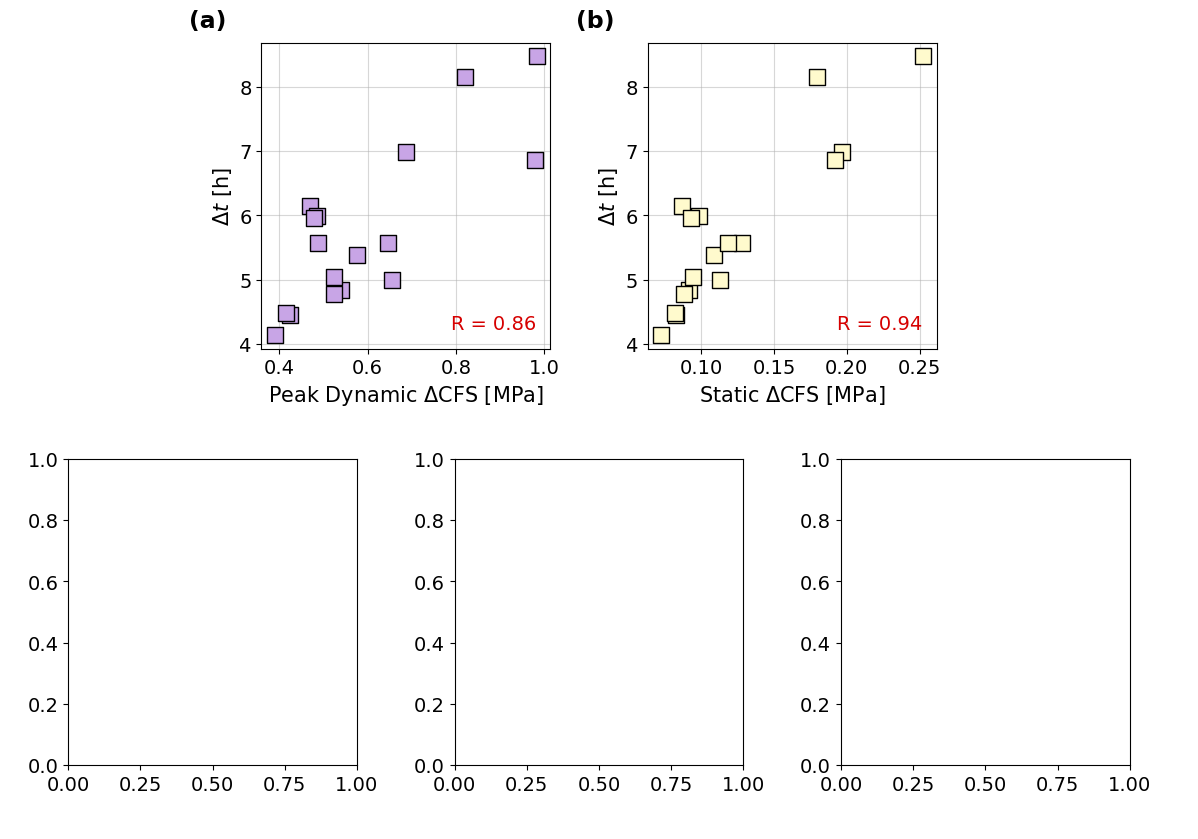

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from perturb_tools import PERTURB
import matplotlib.pylab as plt
import myplots
from string import ascii_lowercase
mp = myplots.Figpref()
plt.rcParams['font.size'] = '14'

save_on = 0
print_on = 0
delay_model = False
plot_corr = 1
law = 'aging'
abs_time_diff = False
if abs_time_diff: print('Absolute time mode')
axislab_fs = 15
figlab_fs = 17
txt_fs = 14
symbol_size=125
symbol_lw = 1

tvars = ['max_dCFS','static_dCFS']
# tvars = ['max_dCFS','static_dCFS','slip','sliprate','integrated_work']
colset = {'max_dCFS':mp.mylilac,'static_dCFS':'lemonchiffon','slip':mp.pptlightgreen,'sliprate':mp.mylightblue,'integrated_work':mp.mypalepink}
colset_delay = {'max_dCFS':mp.mydarkviolet,'static_dCFS':mp.pptorange,'slip':mp.myolive,'sliprate':mp.myblue,'integrated_work':mp.myburgundy}

def compute_indicators(model,target_var,base_model,mode):
    if not np.all(np.argsort(abs(model.dep)) == np.arange(len(model.dep))):
        print('Need sorting!!')
        model.dep = np.sort(model.dep)
    if not np.all(np.argsort(abs(model.dep)) == np.arange(len(model.dep))):
        raise SyntaxError('Need sorting!!')
    if target_var == 'work':
        shearT = abs(model.variables['shearT'].data)
        cumslip = model.variables['slip'].data[:,1:]
    elif target_var != 'dCFS': 
        var = model.variables[target_var].data

    if target_var == 'sliprate':
        value = np.log10(np.max(var))
    elif target_var == 'slip':
        value = max(var[:,-1]-var[:,0])*1e3
    elif target_var  in ['state','shearT','dCFS']:
        cumslip = model.variables['slip'].data[:,1:]
        netslip = np.array([cumslip[k,-1]-cumslip[k,0] for k in range(len(model.dep))])
        idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
        if len(np.where(base_model.system_wide == idx)[0]) == 1:
            lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
        # target_depth = base_model.evdep[idx]
        # target_depth = base_model.evdep[lead_fs_idx]
        # di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
        di = np.argmax(netslip)
        target_depth = model.dep[di]
        if target_var == 'shearT': var = -var
        elif target_var == 'dCFS':
            var = model.get_output_dCFS(target_depth,print_on=False)[0]
        if mode == 'max':
            if target_var == 'dCFS': value = np.max(var)  # Peak, at hypocenter depth
            else:
                value = np.max(var[di,:]) - var[di,0]  # Peak, at hypocenter depth
                # value = np.max(var)  # Peak, globally
        elif mode == 'min':
            if target_var == 'dCFS': value = np.min(var)  # Peak neg., at hypocenter depth
            else:  
                value = np.min(var[di,:]) - var[di,0]  # Peak neg., at hypocenter depth
                # value = np.min(var)  # Peak, globally
        elif mode == 'static':
            if target_var == 'dCFS': value = np.mean(var[-10:])  # Peak neg., at hypocenter depth
            else: value = np.mean(var[di,-10:]) - var[di,0]   # Static, at hypocenter depth
    elif target_var == 'work':
        from scipy import integrate
        G = []
        for di in range(len(model.dep)):
            target_depth = model.dep[di]
            slip = cumslip[di,:] - cumslip[di,0]
            ts = -model.get_output_dCFS(target_depth,print_on=False)[-1]
            # x = slip
            # y = ts*1e6
            x = slip[:400]
            y = ts[:400]*1e6
            area = integrate.simpson(y,x)
            G.append(area)
        if mode == 'integrated': 
            value = integrate.simpson(G,-model.dep*1e3)
        elif mode == 'average':
            value = np.mean(G)
        elif mode == 'hypo':
            idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
            target_depth = base_model.evdep[idx]
            di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
            # value = G[di]
            inc = 500
            lb,ub = di-inc,di+inc+1
            if di-inc < 0: lb = 0 #; print('di = %d; di-inc < 0'%(di))
            if di+inc+1 >= len(G): ub = len(G)-1 #; print('di = %d; di+inc+1 >= %d'%(di,len(G)))
            value = integrate.simpson(G[lb:ub],-model.dep[lb:ub]*1e3)
    else:
        raise SyntaxError('No definition for the target variable')
    return value

# --------- Load triggring responses
if law == 'aging': resp = pd.read_csv('perturb_stress/triggering_response_aging.csv',skiprows=1)
elif law == 'LnDaging': resp = pd.read_csv('perturb_stress/triggering_response_LnDaging.csv',skiprows=1)
target_IDs = resp['ID']
model_names = resp['Model\n Name']
strikes = resp['Strike\n [˚]']
triggering_responses = resp['Time \n Difference [h]']
if abs_time_diff: triggering_responses = abs(triggering_responses)

base_model = PERTURB('reference')
base_model.load_events()

dirs = glob('/export/dump/jyun/perturb_stress/pert*')
c = []

panel_margin = 0.08
panel_margin2 = 0.13
left_margin = 0.13
right_margin = 0.0
bottom_margin = 0.1
top_margin = 0.05
width = (1-panel_margin*2-right_margin-left_margin)/3
height = (1-panel_margin2-top_margin-bottom_margin)/2
margin1 = (1-width*2-panel_margin)/2
margin2 = (1-width*3-panel_margin*2)/2

fig, ax = plt.subplots(figsize=(12.2,8.5))
ax1 = fig.add_axes([margin1,bottom_margin+height+panel_margin2,width,height])
ax2 = fig.add_axes([margin1+width+panel_margin,bottom_margin+height+panel_margin2,width,height])
ax3 = fig.add_axes([margin2,bottom_margin,width,height])
ax4 = fig.add_axes([margin2+width+panel_margin,bottom_margin,width,height])
ax5 = fig.add_axes([margin2+width*2+panel_margin*2,bottom_margin,width,height])
ax.set_axis_off()

axset = {'max_dCFS':ax1,'static_dCFS':ax2,'slip':ax3,'sliprate':ax4,'integrated_work':ax5}
for kk in range(len(tvars)):
    target_var = tvars[kk]
    col = colset[target_var]
    col_delay = colset_delay[target_var]
    fign = target_var
    if abs_time_diff: fign += '_abs'
    mode = ''
    quant = 1e6*np.ones(triggering_responses.shape)
    print(target_var)
    if 'state' in target_var or 'shearT' in target_var or 'dCFS' in target_var or 'work' in target_var:
        if len(target_var.split('_')) > 1:
            mode = target_var.split('_')[0]
        target_var = target_var.replace(mode+'_','')

    for folders in np.array(dirs):
        branch_n = folders.split('/export/dump/jyun/perturb_stress/')[-1]
        if 'stress_dep' in branch_n or 'sliplaw' in branch_n or 'lowres' in branch_n or 'X' in branch_n or 'diffwavelength' in branch_n or 'h' in branch_n:
        # if 'pert18_vs340_lowres_spinup_aginglaw_reference' == branch_n:
        #     delay_model = True
        #     delay = 5.9550
        # elif 'stress_dep' in branch_n or 'sliplaw' in branch_n or 'lowres' in branch_n or 'X' in branch_n or 'diffwavelength' in branch_n or 'h' in branch_n:
            if print_on: print('%s: invalid names - skip'%(branch_n))
            continue

        model = PERTURB(branch_n)

        if not delay_model:
            crit1 = np.where(model_names == model.seissol_model_n)[0]
            crit2 = np.where(strikes == model.receivef_strike)[0]
            crit3 = np.where(target_IDs == model.target_eventid)[0]

            csv_idx = np.intersect1d(np.intersect1d(crit1,crit2),crit3)
            if len(csv_idx) == 0:
                if print_on: print('No matching data in the csv file for "%s"'%(branch_n))
                continue
            elif len(csv_idx) > 1:
                if print_on: print('More than one matching data in the csv file for "%s":'%(branch_n),csv_idx)
                continue
            csv_idx = csv_idx[0]

            model.load_output(print_on=False)
            quant[csv_idx] = compute_indicators(model,target_var,base_model,mode)
            # print(branch_n,'(%d)'%(csv_idx),'->',quant[csv_idx])
        else:
            model.load_output(print_on=False)
            delay_quant = compute_indicators(model,target_var,base_model,mode)
            # print(branch_n,'->',delay_quant)
            delay_model = False

    # ---------- Compute correlation coefficient, R
    X = np.stack((quant,-triggering_responses), axis=0)
    R = np.cov(X)[0,1]/(np.std(quant)*np.std(-triggering_responses))
    # X = np.stack((quant,triggering_responses), axis=0)
    # R = np.cov(X)[0,1]/(np.std(quant)*np.std(triggering_responses))

    # ---------- Plot
    if 'delay_quant' not in locals():
        axset[fign].scatter(quant,-triggering_responses,s=symbol_size,fc=col,ec='k',lw=symbol_lw,marker='s',zorder=3)
    else:
        axset[fign].scatter(quant,-triggering_responses,s=symbol_size,fc=col,ec='k',lw=symbol_lw,marker='s',zorder=3)
        axset[fign].scatter(delay_quant,-delay,s=symbol_size,fc=col_delay,ec='k',lw=symbol_lw,marker='^',zorder=3)
    if mode in ['static','min','max'] and target_var != 'dCFS':
        label = model.variables[target_var].label.split(' [')[0]
        unit = '[%s]'%(model.variables[target_var].label.split('[')[-1].split(']')[0])
    # if 'delay_quant' not in locals() and target_var in ['slip','work']: axset[fign].set_xscale('log')
    if target_var == 'sliprate':
        axset[fign].set_xlabel(r'$\log_{10}$(Peak '+model.variables[target_var].label+')',fontsize=axislab_fs)
    elif mode == 'static':
        if target_var == 'dCFS': axset[fign].set_xlabel(r'Static $\Delta$CFS [MPa]',fontsize=axislab_fs)
        else: axset[fign].set_xlabel('Static '+label+' Change '+unit,fontsize=axislab_fs)
    elif mode == 'min':
        if target_var == 'dCFS': axset[fign].set_xlabel(r'Peak Negative Dynamic $\Delta$CFS [MPa]',fontsize=axislab_fs)
        else: axset[fign].set_xlabel('Peak Negative '+label+' Change '+unit,fontsize=axislab_fs)
    elif target_var == 'work':
        if mode in 'integrated':
            axset[fign].set_xlabel('Work per Distance [J/m]',fontsize=axislab_fs)
        elif mode == 'average':
            axset[fign].set_xlabel('Average Work Density [J/m$^2$]',fontsize=axislab_fs)
        elif mode == 'hypo':
            axset[fign].set_xlabel('Work Density at Hypocenter [J/m$^2$]',fontsize=axislab_fs)
    elif target_var == 'slip': axset[fign].set_xlabel('Peak Slip [mm]',fontsize=axislab_fs)
    else:
        if target_var == 'dCFS': axset[fign].set_xlabel(r'Peak Dynamic $\Delta$CFS [MPa]',fontsize=axislab_fs)
        else: axset[fign].set_xlabel('Peak '+label+' Change '+unit,fontsize=axislab_fs)
    if abs_time_diff: 
        axset[fign].set_ylabel('$|\Delta t|$ [h]',fontsize=axislab_fs)
    else:
        axset[fign].set_ylabel('$\Delta t$ [h]',fontsize=axislab_fs)
        # axset[fign].set_ylabel('Mainshock Time difference ($\Delta t$) [h]',fontsize=axislab_fs)
    xl = axset[fign].get_xlim()
    yl = axset[fign].get_ylim()
    axset[fign].text(xl[0]-(xl[1]-xl[0])*0.25,yl[1]+(yl[1]-yl[0])*0.05,'(%s)'%(ascii_lowercase[kk]),fontsize=figlab_fs,fontweight='bold')
    if plot_corr: axset[fign].text(xl[1]-(xl[1]-xl[0])*0.05,yl[0]+(yl[1]-yl[0])*0.05,'R = %1.2f'%(R),fontsize=txt_fs,color=mp.myburgundy,ha='right',va='bottom')
    # if plot_corr: axset[fign].text(xl[1]-(xl[1]-xl[0])*0.05,yl[1]-(yl[1]-yl[0])*0.05,'R = %1.2f'%(R),fontsize=txt_fs,color=mp.myburgundy,ha='right',va='top')
    axset[fign].grid(True,alpha=0.5)
    
plt.tight_layout()
# plt.show()
if save_on:
    plt.savefig('/export/dump/jyun/perturb_stress/plots/basic_aging_law_summary/trigger_response_at_max_slip.png',bbox_inches='tight',dpi=350)


-0.22159488038196073

Actual static dCFS: -0.22159488038196073
Actual delay time: 5.955
Delay predicted from linear regression: 1.651252640758516


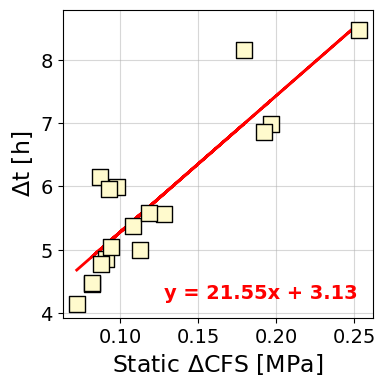

In [25]:
from scipy import stats
ii = np.where(np.logical_and(np.logical_or(abs(triggering_responses)<=7.5,abs(triggering_responses)>=8.2),np.logical_or(abs(triggering_responses)<=5.8,abs(triggering_responses)>=6.5)))[0]
# x = quant[ii]
# y = abs(triggering_responses)[ii]
x = quant
y = abs(triggering_responses)
res = stats.linregress(x, y)

print('Actual static dCFS:',delay_quant)
print('Actual delay time:',delay)
print('Delay predicted from linear regression:',abs(res.intercept + res.slope*delay_quant))
fig,ax=plt.subplots(figsize=(4,4))
plt.scatter(x,y,s=symbol_size,fc=col,ec='k',lw=symbol_lw,marker='s',zorder=3)
plt.plot(x, res.intercept + res.slope*x, 'r', lw=2)
# plt.scatter(delay_quant,-delay,s=symbol_size,fc=col_delay,ec='k',lw=symbol_lw,marker='^',zorder=3)
# x = np.hstack((quant,delay_quant))
# y = np.hstack((abs(triggering_responses),-delay))
# plt.plot(x, res.intercept + res.slope*x, 'r', lw=2)
xl = ax.get_xlim()
yl = ax.get_ylim()
plt.text(xl[1]-(xl[1]-xl[0])*0.05,yl[0]+(yl[1]-yl[0])*0.05,'y = %1.2fx + %1.2f'%(res.slope,res.intercept),fontweight='bold',color='r',ha='right',va='bottom',fontsize=14)
plt.xlabel('Static $\Delta$CFS [MPa]',fontsize=17)
plt.ylabel('$\Delta$t [h]',fontsize=17)
plt.grid(True,alpha=0.5)
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [15]:
-22.26*0.2+2.74

-1.7120000000000006

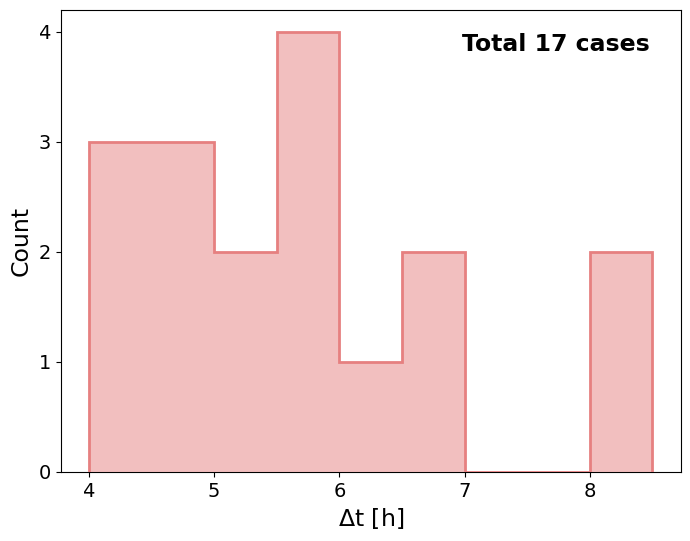

In [34]:
fig,ax=plt.subplots(figsize=(8,6))
bin = np.arange(4,8.6,0.5)
# bin = np.linspace(min(abs(triggering_responses)),max(abs(triggering_responses)),10)
plt.hist(abs(triggering_responses),fc=mp.mypink,bins=bin,alpha=0.5,zorder=3)
plt.hist(abs(triggering_responses),histtype='step',ec=mp.mypink,lw=2,bins=bin,zorder=3)
xl = ax.get_xlim()
yl = ax.get_ylim()
plt.text(xl[1]-(xl[1]-xl[0])*0.05,yl[1]-(yl[1]-yl[0])*0.05,'Total %d cases'%(len(triggering_responses)),fontweight='bold',color='k',ha='right',va='top',fontsize=17)
# plt.grid(True,alpha=0.5)
ax.set_yticks(ticks=[0,1,2,3,4])
plt.xlim(xl)
plt.ylim(yl)
plt.xlabel('$\Delta$t [h]',fontsize=17)
plt.ylabel('Count',fontsize=17)
plt.show()

integrated_work
pert31_vsflipstat_340
pert31_ds350
pert31_vs320


pert31_vsdyn_340
pert61_vs340_correct_slowVpl_reference
pert31_ds330
pert45_vs340
pert31_vsstatic_340
pert12_vs340
pert20_vs340
pert31_vf330
pert12_vf320
pert12_vs320
pert31_ds340
pert31_vs340
pert8_vs340
pert8_df320
pert12_df330
pert56_vs340
pert31_vf340
pert31_df340
363.1688588107803


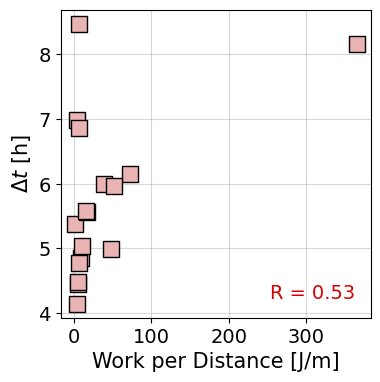

In [16]:
import numpy as np
import pandas as pd
from glob import glob
from perturb_tools import PERTURB
import matplotlib.pylab as plt
import myplots
from string import ascii_lowercase
mp = myplots.Figpref()
plt.rcParams['font.size'] = '14'

print_on = 0
delay_model = False
plot_corr = 1
law = 'aging'
abs_time_diff = False
if abs_time_diff: print('Absolute time mode')
axislab_fs = 15
figlab_fs = 17
txt_fs = 14
symbol_size=125
symbol_lw = 1

tvars = ['max_dCFS','static_dCFS','slip','sliprate','integrated_work']
colset = {'max_dCFS':mp.mylilac,'static_dCFS':'lemonchiffon','slip':mp.pptlightgreen,'sliprate':mp.mylightblue,'integrated_work':mp.mypalepink}
colset_delay = {'max_dCFS':mp.mydarkviolet,'static_dCFS':mp.pptorange,'slip':mp.myolive,'sliprate':mp.myblue,'integrated_work':mp.myburgundy}

def compute_indicators(model,target_var,base_model,mode):
    if not np.all(np.argsort(abs(model.dep)) == np.arange(len(model.dep))):
        print('Need sorting!!')
        model.dep = np.sort(model.dep)
    if not np.all(np.argsort(abs(model.dep)) == np.arange(len(model.dep))):
        raise SyntaxError('Need sorting!!')
    if target_var == 'work':
        shearT = abs(model.variables['shearT'].data)
        cumslip = model.variables['slip'].data[:,1:]
    elif target_var != 'dCFS': 
        var = model.variables[target_var].data

    if target_var == 'sliprate':
        value = np.log10(np.max(var))
    elif target_var == 'slip':
        value = max(var[:,-1]-var[:,0])*1e3
    elif target_var  in ['state','shearT','dCFS']:
        idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
        # target_depth = base_model.evdep[idx]
        if len(np.where(base_model.system_wide == idx)[0]) == 1:
            lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
        target_depth = base_model.evdep[lead_fs_idx]
        di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
        if target_var == 'shearT': var = -var
        elif target_var == 'dCFS':
            var = model.get_output_dCFS(target_depth,print_on=False)[0]
        if mode == 'max':
            if target_var == 'dCFS': value = np.max(var)  # Peak, at hypocenter depth
            else:
                value = np.max(var[di,:]) - var[di,0]  # Peak, at hypocenter depth
                # value = np.max(var)  # Peak, globally
        elif mode == 'min':
            if target_var == 'dCFS': value = np.min(var)  # Peak neg., at hypocenter depth
            else:  
                value = np.min(var[di,:]) - var[di,0]  # Peak neg., at hypocenter depth
                # value = np.min(var)  # Peak, globally
        elif mode == 'static':
            if target_var == 'dCFS': value = np.mean(var[-10:])
            else: value = np.mean(var[di,-10:]) - var[di,0]   # Static, at hypocenter depth
    elif target_var == 'work':
        from scipy import integrate
        G = []
        for di in range(len(model.dep)):
            target_depth = model.dep[di]
            slip = cumslip[di,:] - cumslip[di,0]
            ts = -model.get_output_dCFS(target_depth,print_on=False)[-1]
            # x = slip
            # y = ts*1e6
            x = slip[:400]
            y = ts[:400]*1e6
            area = integrate.simpson(y,x)
            G.append(area)
        if mode == 'integrated': 
            value = integrate.simpson(G,-model.dep*1e3)
        elif mode == 'average':
            value = np.mean(G)
        elif mode == 'hypo':
            idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
            target_depth = base_model.evdep[idx]
            di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
            # value = G[di]
            inc = 500
            lb,ub = di-inc,di+inc+1
            if di-inc < 0: lb = 0 #; print('di = %d; di-inc < 0'%(di))
            if di+inc+1 >= len(G): ub = len(G)-1 #; print('di = %d; di+inc+1 >= %d'%(di,len(G)))
            value = integrate.simpson(G[lb:ub],-model.dep[lb:ub]*1e3)
    else:
        raise SyntaxError('No definition for the target variable')
    return value

# --------- Load triggring responses
if law == 'aging': resp = pd.read_csv('perturb_stress/triggering_response_aging.csv',skiprows=1)
elif law == 'LnDaging': resp = pd.read_csv('perturb_stress/triggering_response_LnDaging.csv',skiprows=1)
target_IDs = resp['ID']
model_names = resp['Model\n Name']
strikes = resp['Strike\n [˚]']
triggering_responses = resp['Time \n Difference [h]']
if abs_time_diff: triggering_responses = abs(triggering_responses)

# base_model = PERTURB('reference')
# base_model.load_events()

dirs = glob('/export/dump/jyun/perturb_stress/pert*')
c = []

fig, ax = plt.subplots(figsize=(4,4))

axset = {'max_dCFS':ax,'static_dCFS':ax,'slip':ax,'sliprate':ax,'integrated_work':ax}
target_var = 'integrated_work'
col = colset[target_var]
col_delay = colset_delay[target_var]
fign = target_var
if abs_time_diff: fign += '_abs'
mode = ''
quant = 1e6*np.ones(triggering_responses.shape)
print(target_var)
if 'state' in target_var or 'shearT' in target_var or 'dCFS' in target_var or 'work' in target_var:
    if len(target_var.split('_')) > 1:
        mode = target_var.split('_')[0]
    target_var = target_var.replace(mode+'_','')

for folders in np.array(dirs):
    branch_n = folders.split('/export/dump/jyun/perturb_stress/')[-1]
    if 'stress_dep' in branch_n or 'sliplaw' in branch_n or 'lowres' in branch_n or 'X' in branch_n or 'diffwavelength' in branch_n or 'h' in branch_n:
    # if 'pert18_vs340_lowres_spinup_aginglaw_reference' == branch_n:
    #     delay_model = True
    #     delay = 5.9550
    # elif 'stress_dep' in branch_n or 'sliplaw' in branch_n or 'lowres' in branch_n or 'X' in branch_n or 'diffwavelength' in branch_n or 'h' in branch_n:
        if print_on: print('%s: invalid names - skip'%(branch_n))
        continue

    # print(branch_n)
    model = PERTURB(branch_n)

    if not delay_model:
        crit1 = np.where(model_names == model.seissol_model_n)[0]
        crit2 = np.where(strikes == model.receivef_strike)[0]
        crit3 = np.where(target_IDs == model.target_eventid)[0]

        csv_idx = np.intersect1d(np.intersect1d(crit1,crit2),crit3)
        if len(csv_idx) == 0:
            if print_on: print('No matching data in the csv file for "%s"'%(branch_n))
            continue
        elif len(csv_idx) > 1:
            if print_on: print('More than one matching data in the csv file for "%s":'%(branch_n),csv_idx)
            continue
        csv_idx = csv_idx[0]

        model.load_output(print_on=False)
        quant[csv_idx] = compute_indicators(model,target_var,base_model,mode)
        # print(branch_n,'(%d)'%(csv_idx),'->',quant[csv_idx])
    else:
        model.load_output(print_on=False)
        delay_quant = compute_indicators(model,target_var,base_model,mode)
        # print(branch_n,'->',delay_quant)
        delay_model = False

# ---------- Compute correlation coefficient, R
X = np.stack((quant,-triggering_responses), axis=0)
R = np.cov(X)[0,1]/(np.std(quant)*np.std(-triggering_responses))
# X = np.stack((quant,triggering_responses), axis=0)
# R = np.cov(X)[0,1]/(np.std(quant)*np.std(triggering_responses))

# ---------- Plot
if 'delay_quant' not in locals():
    axset[fign].scatter(quant,-triggering_responses,s=symbol_size,fc=col,ec='k',lw=symbol_lw,marker='s',zorder=3)
else:
    axset[fign].scatter(quant,-triggering_responses,s=symbol_size,fc=col,ec='k',lw=symbol_lw,marker='s',zorder=3)
    axset[fign].scatter(delay_quant,-delay,s=symbol_size,fc=col_delay,ec='k',lw=symbol_lw,marker='^',zorder=3)
if mode in ['static','min','max'] and target_var != 'dCFS':
    label = model.variables[target_var].label.split(' [')[0]
    unit = '[%s]'%(model.variables[target_var].label.split('[')[-1].split(']')[0])
# if 'delay_quant' not in locals() and target_var in ['slip','work']: axset[fign].set_xscale('log')
if target_var == 'sliprate':
    axset[fign].set_xlabel(r'$\log_{10}$(Peak '+model.variables[target_var].label+')',fontsize=axislab_fs)
elif mode == 'static':
    if target_var == 'dCFS': axset[fign].set_xlabel(r'Static $\Delta$CFS [MPa]',fontsize=axislab_fs)
    else: axset[fign].set_xlabel('Static '+label+' Change '+unit,fontsize=axislab_fs)
elif mode == 'min':
    if target_var == 'dCFS': axset[fign].set_xlabel(r'Peak Negative Dynamic $\Delta$CFS [MPa]',fontsize=axislab_fs)
    else: axset[fign].set_xlabel('Peak Negative '+label+' Change '+unit,fontsize=axislab_fs)
elif target_var == 'work':
    if mode in 'integrated':
        axset[fign].set_xlabel('Work per Distance [J/m]',fontsize=axislab_fs)
    elif mode == 'average':
        axset[fign].set_xlabel('Average Work Density [J/m$^2$]',fontsize=axislab_fs)
    elif mode == 'hypo':
        axset[fign].set_xlabel('Work Density at Hypocenter [J/m$^2$]',fontsize=axislab_fs)
elif target_var == 'slip': axset[fign].set_xlabel('Peak Slip [mm]',fontsize=axislab_fs)
else:
    if target_var == 'dCFS': axset[fign].set_xlabel(r'Peak Dynamic $\Delta$CFS [MPa]',fontsize=axislab_fs)
    else: axset[fign].set_xlabel('Peak '+label+' Change '+unit,fontsize=axislab_fs)
if abs_time_diff: 
    axset[fign].set_ylabel('$|\Delta t|$ [h]',fontsize=axislab_fs)
else:
    axset[fign].set_ylabel('$\Delta t$ [h]',fontsize=axislab_fs)
xl = axset[fign].get_xlim()
yl = axset[fign].get_ylim()
print(xl[1]-(xl[1]-xl[0])*0.05)
if plot_corr: axset[fign].text(xl[1]-(xl[1]-xl[0])*0.05,yl[0]+(yl[1]-yl[0])*0.05,'R = %1.2f'%(R),fontsize=txt_fs,color=mp.myburgundy,ha='right',va='bottom')
axset[fign].grid(True,alpha=0.5)
# plt.xlim(-10,100)
plt.show()

In [15]:
xl[1]-(xl[1]-xl[0])*0.05

94.5

In [14]:
xl

(-10.0, 100.0)

In [2]:
def compute_indicators(model,target_var,base_model,mode):
    if not np.all(np.argsort(abs(model.dep)) == np.arange(len(model.dep))):
        print('Need sorting!!')
        model.dep = np.sort(model.dep)
    if not np.all(np.argsort(abs(model.dep)) == np.arange(len(model.dep))):
        raise SyntaxError('Need sorting!!')
    if target_var == 'work':
        shearT = abs(model.variables['shearT'].data)
        cumslip = model.variables['slip'].data[:,1:]
    elif target_var != 'dCFS': 
        var = model.variables[target_var].data

    if target_var == 'sliprate':
        value = np.log10(np.max(var))
    elif target_var == 'slip':
        value = max(var[:,-1]-var[:,0])*1e3
    elif target_var  in ['state','shearT','dCFS']:
        idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
        # target_depth = base_model.evdep[idx]
        if len(np.where(base_model.system_wide == idx)[0]) == 1:
            lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
        target_depth = base_model.evdep[lead_fs_idx]
        di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
        if target_var == 'shearT': var = -var
        elif target_var == 'dCFS':
            var = model.get_output_dCFS(target_depth,print_on=False)[0]
        if mode == 'max':
            if target_var == 'dCFS': value = np.max(var)  # Peak, at hypocenter depth
            else:
                value = np.max(var[di,:]) - var[di,0]  # Peak, at hypocenter depth
                # value = np.max(var)  # Peak, globally
        elif mode == 'min':
            if target_var == 'dCFS': value = np.min(var)  # Peak neg., at hypocenter depth
            else:  
                value = np.min(var[di,:]) - var[di,0]  # Peak neg., at hypocenter depth
                # value = np.min(var)  # Peak, globally
        elif mode == 'static':
            if target_var == 'dCFS': value = np.mean(var[-10:])  # Peak neg., at hypocenter depth
            else: value = np.mean(var[di,-10:]) - var[di,0]   # Static, at hypocenter depth
    elif target_var == 'work':
        from scipy import integrate
        G = []
        for di in range(len(model.dep)):
            target_depth = model.dep[di]
            slip = cumslip[di,:] - cumslip[di,0]
            ts = -model.get_output_dCFS(target_depth,print_on=False)[-1]
            x = slip[:400]
            y = ts[:400]*1e6
            area = integrate.simpson(y,x)
            G.append(area)
        if mode == 'integrated': 
            print('integrated')
            value = integrate.simpson(G,-model.dep*1e3)
        elif mode == 'average':
            print('average')
            value = np.mean(G)
        elif mode == 'hypo':
            print('hypo')
            idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
            target_depth = base_model.evdep[idx]
            di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
            # value = G[di]
            inc = 500
            lb,ub = di-inc,di+inc+1
            if di-inc < 0: lb = 0 #; print('di = %d; di-inc < 0'%(di))
            if di+inc+1 >= len(G): ub = len(G)-1 #; print('di = %d; di+inc+1 >= %d'%(di,len(G)))
            value = integrate.simpson(G[lb:ub],-model.dep[lb:ub]*1e3)
    else:
        raise SyntaxError('No definition for the target variable')
    return value

In [6]:
target_var = 'work'
mode = 'integrated'
print(target_var)
branch_n = 'pert8_df320'
model = PERTURB(branch_n)
model.load_output(print_on=False)
shearT = abs(model.variables['shearT'].data)
cumslip = model.variables['slip'].data[:,1:]
quant = compute_indicators(model,target_var,base_model,mode)
print(branch_n,'->',quant)

work


pert8_df320 -> 364.9881540832828


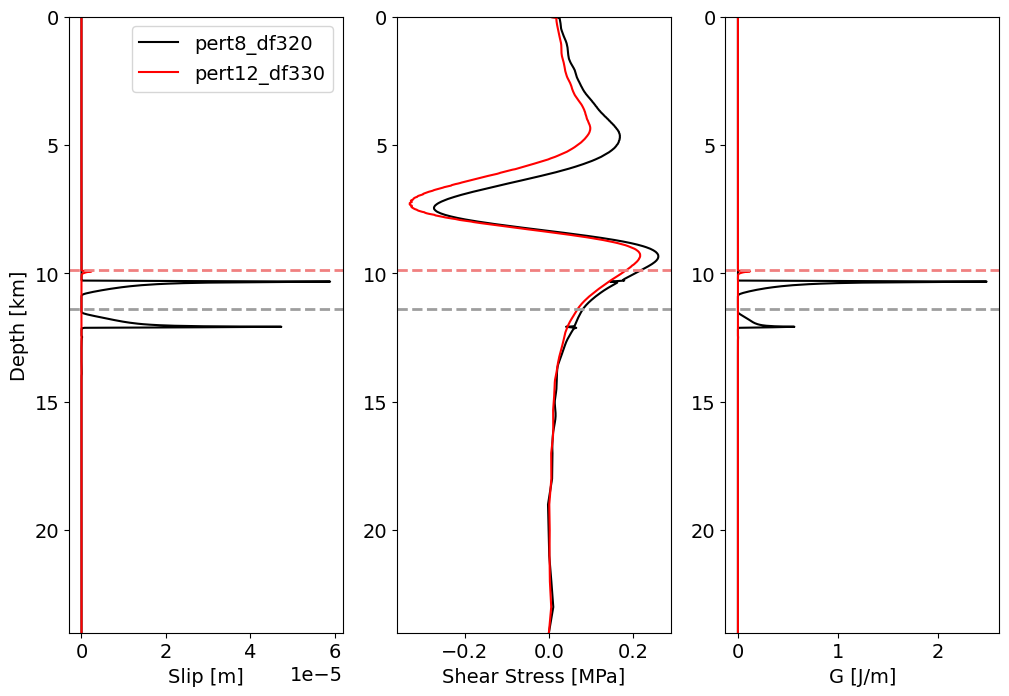

In [10]:
def get_vars(branch_n):
    model = PERTURB(branch_n)
    model.load_output(print_on=False)
    shearT = abs(model.variables['shearT'].data)
    cumslip = model.variables['slip'].data[:,1:]
    from scipy import integrate
    G = []
    for di in range(len(model.dep)):
        target_depth = model.dep[di]
        slip = cumslip[di,:] - cumslip[di,0]
        ts = -model.get_output_dCFS(target_depth,print_on=False)[-1]
        x = slip[:400]
        y = ts[:400]*1e6
        area = integrate.simpson(y,x)
        G.append(area)
    idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
    # target_depth = base_model.evdep[idx]
    if len(np.where(base_model.system_wide == idx)[0]) == 1:
        lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
    target_depth = base_model.evdep[idx]
    target_depth_fs = base_model.evdep[lead_fs_idx]
    # di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
    return cumslip,shearT,G,target_depth,target_depth_fs

cumslip,shearT,G1,target_depth1,target_depth_fs1 = get_vars('pert8_df320')
slip1 = [cumslip[di,-1] - cumslip[di,0] for di in range(len(model.dep))]
ts1 = [shearT[di,-1] - shearT[di,0] for di in range(len(model.dep))]
cumslip,shearT,G2,target_depth2,target_depth_fs2 = get_vars('pert12_df330')
slip2 = [cumslip[di,-1] - cumslip[di,0] for di in range(len(model.dep))]
ts2 = [shearT[di,-1] - shearT[di,0] for di in range(len(model.dep))]


fig,[ax1,ax2,ax3]=plt.subplots(figsize=(12,8),ncols=3)
ax1.plot(slip1,-model.dep,'k',label='pert8_df320')
ax1.plot(slip2,-model.dep,'r',label='pert12_df330')
xl = ax1.get_xlim()
ax1.hlines(target_depth_fs1,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
ax1.hlines(target_depth_fs2,xl[0],xl[1],color='lightcoral',lw=2,linestyles='--')
# ax1.hlines(target_depth1,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
# ax1.hlines(target_depth2,xl[0],xl[1],color='lightcoral',lw=2,linestyles='--')
ax1.set_xlim(xl)
ax1.legend()
ax1.set_xlabel('Slip [m]')
ax1.set_ylabel('Depth [km]')
ax1.set_ylim(0,24)
ax1.invert_yaxis()

ax2.plot(ts1,-model.dep,'k')
ax2.plot(ts2,-model.dep,'r')
xl = ax2.get_xlim()
ax2.hlines(target_depth_fs1,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
ax2.hlines(target_depth_fs2,xl[0],xl[1],color='lightcoral',lw=2,linestyles='--')
# ax2.hlines(target_depth1,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
# ax2.hlines(target_depth2,xl[0],xl[1],color='lightcoral',lw=2,linestyles='--')
ax2.set_xlim(xl)
ax2.set_xlabel('Shear Stress [MPa]')
ax2.set_ylim(0,24)
ax2.invert_yaxis()

ax3.plot(G1,-model.dep,'k')
ax3.plot(G2,-model.dep,'r')
xl = ax3.get_xlim()
ax3.hlines(target_depth_fs1,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
ax3.hlines(target_depth_fs2,xl[0],xl[1],color='lightcoral',lw=2,linestyles='--')
# ax3.hlines(target_depth1,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
# ax3.hlines(target_depth2,xl[0],xl[1],color='lightcoral',lw=2,linestyles='--')
ax3.set_xlim(xl)
ax3.set_xlabel('G [J/m]')
ax3.set_ylim(0,24)
ax3.invert_yaxis()
plt.show()

4.38
4.38


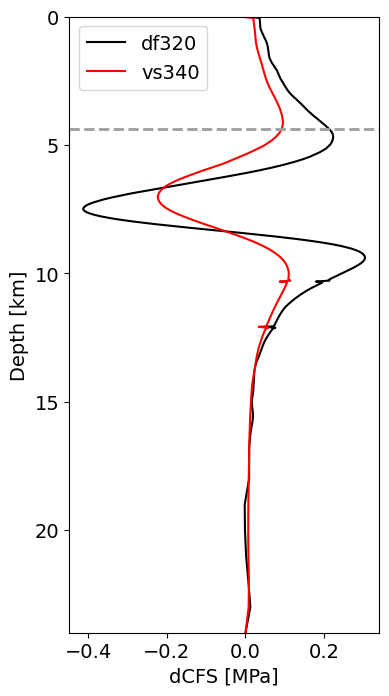

In [34]:
def get_vars(branch_n):
    model = PERTURB(branch_n)
    model.load_output(print_on=False)
    shearT = abs(model.variables['shearT'].data)
    cumslip = model.variables['slip'].data[:,1:]
    from scipy import integrate
    G = []
    # dcfs = []
    for di in range(len(model.dep)):
        target_depth = model.dep[di]
        slip = cumslip[di,:] - cumslip[di,0]
        ts = -model.get_output_dCFS(target_depth,print_on=False)[-1]
        x = slip[:400]
        y = ts[:400]*1e6
        area = integrate.simpson(y,x)
        G.append(area)
        # dcfs.append(model.get_output_dCFS(target_depth,print_on=False)[0])
    # dcfs = np.array(dcfs)
    idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
    if len(np.where(base_model.system_wide == idx)[0]) == 1:
        lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
    target_depth = base_model.evdep[idx]
    # target_depth = base_model.evdep[lead_fs_idx]
    di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
    dcfs = model.get_output_dCFS(target_depth,print_on=False)[0]
    return cumslip,shearT,G,target_depth,dcfs

cumslip,shearT,G1,target_depth,dcfs1 = get_vars('pert8_df320')
slip1 = [cumslip[di,-1] - cumslip[di,0] for di in range(len(model.dep))]
ts1 = [shearT[di,-1] - shearT[di,0] for di in range(len(model.dep))]
print(target_depth)
cumslip,shearT,G2,target_depth,dcfs2 = get_vars('pert8_vs340')
slip2 = [cumslip[di,-1] - cumslip[di,0] for di in range(len(model.dep))]
ts2 = [shearT[di,-1] - shearT[di,0] for di in range(len(model.dep))]
print(target_depth)


fig,ax1=plt.subplots(figsize=(4,8))
ax1.plot(dcfs1[:,-1],-model.dep,'k',label='df320')
ax1.plot(dcfs2[:,-1],-model.dep,'r',label='vs340')
xl = ax1.get_xlim()
ax1.hlines(target_depth,xl[0],xl[1],color='0.62',lw=2,linestyles='--')
ax1.set_xlim(xl)
ax1.legend()
ax1.set_xlabel('dCFS [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_ylim(0,24)
ax1.invert_yaxis()

plt.show()

In [30]:
np.array(dcfs1).shape

(858, 1501)

4.38


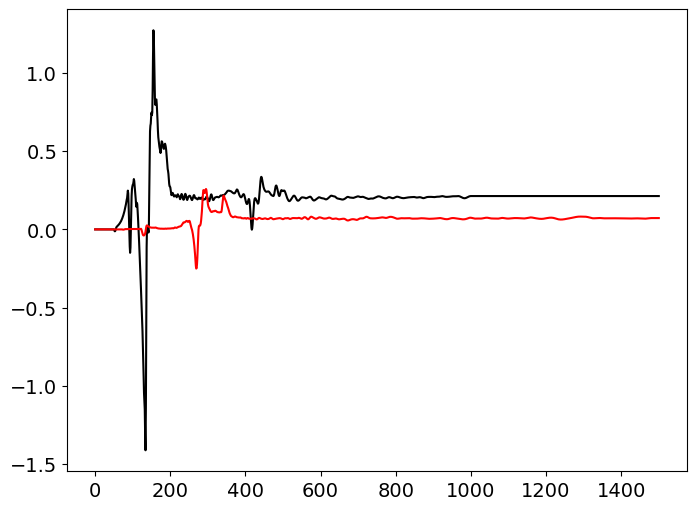

In [42]:
# di = 516

model = PERTURB('pert8_df320')
model.load_output(print_on=False)
idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
if len(np.where(base_model.system_wide == idx)[0]) == 1:
    lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
target_depth = base_model.evdep[idx]
# target_depth = base_model.evdep[lead_fs_idx]
di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
dcfs = model.get_output_dCFS(target_depth,print_on=False)[0]


print(-model.dep[di])
target_depth = model.dep[di]
slip = cumslip[di,:] - cumslip[di,0]
ts = -model.get_output_dCFS(target_depth,print_on=False)[-1]
x = slip
y = ts
# x = slip[:400]
# y = ts[:400]
fig,ax=plt.subplots(figsize=(8,6))
plt.plot(dcfs,'k')
# plt.plot(x,y,'k')
# plt.xlabel('Slip [m]')
# plt.ylabel('Shear Stress [MPa]')

model = PERTURB('pert8_vs340')
model.load_output(print_on=False)
idx = base_model.system_wide[base_model.system_wide>=base_model.spin_up_idx][model.target_eventid]
if len(np.where(base_model.system_wide == idx)[0]) == 1:
    lead_fs_idx = base_model.lead_fs[np.where(base_model.system_wide == idx)[0][0]]
# target_depth = base_model.evdep[idx]
target_depth = base_model.evdep[lead_fs_idx]
di = np.argmin(abs(abs(model.dep) - abs(target_depth)))
dcfs = model.get_output_dCFS(target_depth,print_on=False)[0]
plt.plot(dcfs,'r')

plt.show()

In [21]:
ts

array([-0.00000000e+00, -1.10374058e-05, -2.20748634e-05, ...,
        1.45542616e-01,  1.45528352e-01,  1.45514088e-01])

# Update params

In [2]:
from read_outputs import *
save_dir = '/export/dump/jyun/perturb_stress/after_pert8_vs340_87600h'
extract_from_lua(save_dir,save_on=True)

/home/jyun/Tandem/perturb_stress/matfric_Fourier_main_perturb.lua
Save data... done!


array({'a_b1': 0.012, 'a_b2': -0.004, 'a_b3': 0.015, 'a_b4': 0.024, 'b': 0.019, 'tau1': -10.0, 'tau2': -30.0, 'tau3': -22.5, 'sigma1': 10.0, 'sigma2': 50.0, 'Wf': 24.0, 'H': 12.0, 'h': 5.0, 'H2': 2.0, 'rho0': 2.67, 'V0': 1e-06, 'f0': 0.6, 'Dc': 0.002, 'nu': 0.25, 'mu': 20.0, 'Vp': 1e-09},
      dtype=object)

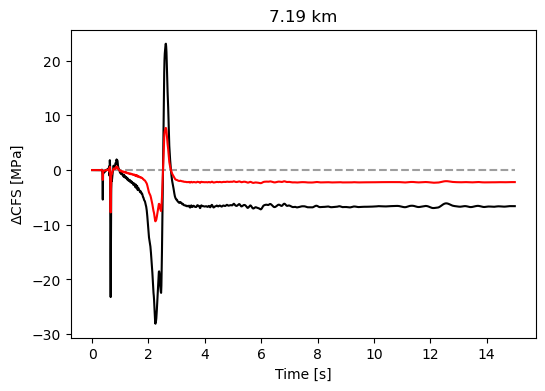

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm
import myplots
mp = myplots.Figpref()

mode = 4
receivef_strike = 340
model_n = 'vert_slow'
string = '_X30'
string2 = '_X10'
# string2 = '_dyn_X30'
mu = 0.4
lb=-.5; ub=.5
dt = 0.01
if receivef_strike == 340: ndt = 1501
else: ndt = 1001
save_dir = 'perturb_stress/seissol_outputs'

delPn = np.loadtxt('%s/ssaf_%s%s_Pn_pert_mu%02d_%d.dat'%(save_dir,model_n,string,int(mu*10),receivef_strike))
delTs = np.loadtxt('%s/ssaf_%s%s_Ts_pert_mu%02d_%d.dat'%(save_dir,model_n,string,int(mu*10),receivef_strike))
depth_range = np.loadtxt('%s/ssaf_%s%s_dep_stress_pert_mu%02d_%d.dat'%(save_dir,model_n,string,int(mu*10),receivef_strike))
dCFSt = delTs + mu*delPn

delPn2 = np.loadtxt('%s/ssaf_%s%s_Pn_pert_mu%02d_%d.dat'%(save_dir,model_n,string2,int(mu*10),receivef_strike))
delTs2 = np.loadtxt('%s/ssaf_%s%s_Ts_pert_mu%02d_%d.dat'%(save_dir,model_n,string2,int(mu*10),receivef_strike))
depth_range2 = np.loadtxt('%s/ssaf_%s%s_dep_stress_pert_mu%02d_%d.dat'%(save_dir,model_n,string2,int(mu*10),receivef_strike))
dCFSt2 = delTs2 + mu*delPn2

t = np.arange(0,ndt/100,dt)

fig,ax = plt.subplots(figsize=(6,4))
di = 700
plt.hlines(0,0,15,'0.62',linestyle='--')
# plt.vlines(2.43,-30,25,'lightblue',linestyle='--')
# plt.plot(t,delPn[:,di],'k')
# plt.plot(t,delPn2[:,di],'r')
# plt.plot(t,np.max(dCFSt,axis=1),'k')
# plt.plot(t,np.max(dCFSt2,axis=1),'r')
plt.plot(t,dCFSt[:,di],'k')
plt.plot(t,dCFSt2[:,di],'r')
plt.title('%1.2f km'%(-depth_range[di]))
plt.xlabel('Time [s]')
plt.ylabel('$\Delta$CFS [MPa]')
plt.show()


In [5]:
np.max(dCFSt),np.max(dCFSt2)

(23.621875955978105, 7.873958651992702)

# Test model name convention

In [3]:
import numpy as np

def code2name(code):
    # e.g., vs340, vsX2_350
    if code[0] == 'v': 
        model_n = 'vert'
    elif code[0] == 'd':
        model_n = 'dipping'
    if code[1] == 'f':
        model_n += '_fast'
    elif code[1] == 's':
        model_n += '_slow'
    if 'X' in code:
        model_n += '_X%d'%(int(code.split('X')[-1].split('_')[0]))
        strike = int(code.split('_')[-1])
    if 'dyn' in code:
        model_n += '%s'
        strike = int(code.split('_')[-1])
    elif 'static' in code:
        model_n += '_static'
        strike = int(code.split('_')[-1])
    elif 'flipstat' in code:
        model_n += '_flipstat'
        strike = int(code.split('_')[-1])
    if not 'strike' in locals():
        strike = int(code[2:])
    return model_n,strike

pert_name = 'pert8_vsX5_340_1h'
# base_model_tag = 'lowres_spinup_aginglaw_reference'
base_model_tag = None
if base_model_tag is None:
    branch_name = '%s'%(pert_name)
else:
    branch_name = '%s_%s'%(pert_name,base_model_tag)
print(branch_name)

model_tag = 'reference'
target_eventid,seissol_model_n,receivef_strike,multiply,time_diff_in_h,mu = None,None,None,None,None,None
if 'pert' in branch_name:
    print('pert in branch_name')
    multiply = int(1)
    time_diff_in_h = 16.2
    mu = 0.4
    target_eventid = int(branch_name.split('pert')[-1].split('_')[0])
    tails = branch_name.split('pert%d_'%(target_eventid))[-1]
    print(tails)
    if len(tails.split('_')) > 1:
        print('len(tails.split("'"_"'")) > 1')
        # if 'X' in tails and 'h' in tails:
        #     print('Both X and h in tails')

        if 'X' in tails:
            print('X in tails')
            seissol_model_code = tails.split('_')[0] + '_' + tails.split('_')[1]
            multiply = int(seissol_model_code.split('X')[-1].split('_')[0])
        if 'h' in tails:
            print('h in tails')
            if len(tails.split('h')[0].split('_')[-1]) <= 2 and len(tails.split('h')[0].split('_')[-1]) > 0: # varying_time
                time_diff_in_h = int(tails.split('h')[0].split('_')[-1])
            if len(tails.split('h')) > 2 or len(tails.split('h')[0].split('_')[-1]) > 2: # diffwavelength
                model_tag = tails.split('_')[-1].split('h')[0]+'h'
            elif 'hf' in tails: # hf10_reference
                model_tag = 'hf' + tails.split('hf')[-1]
            if 'X' not in tails:
                seissol_model_code = tails.split('h')[0].split('_')[0]
        if 'X' not in tails and 'h' not in tails:
            print('Both X and h not in tails')
            if 'dyn' in tails or 'stat' in tails:
                print('dyn or stat in tails')
                if len(tails.split('_')) > 2:
                    seissol_model_code = tails.split('_')[0]+'_'+tails.split('_')[1]
                else:
                    seissol_model_code = tails
            else:
                seissol_model_code = tails.split('_')[0]
            if tails.split(seissol_model_code+'_')[-1] != 'stress_dep':
                model_tag = tails.split(seissol_model_code+'_')[-1]
    else:
        print('len(tails.split("'"_"'")) <= 1')
        seissol_model_code = tails
    print(seissol_model_code)
    seissol_model_n,receivef_strike = code2name(seissol_model_code)
else:
    if branch_name != 'reference':
        model_tag = branch_name
print(seissol_model_n,receivef_strike,time_diff_in_h)

pert8_vsX5_340_1h
pert in branch_name
vsX5_340_1h
len(tails.split("_")) > 1
X in tails
h in tails
vsX5_340
vert_slow_X5 340 1


# Seissol2Tandem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm
import myplots
mp = myplots.Figpref()

mode = 4
receivef_strike = 340
model_n = 'vert_slow'
mu = 0.4
lb=-.5; ub=.5
dt = 0.01
if receivef_strike == 340: ndt = 1501
else: ndt = 1001
save_dir = 'perturb_stress/seissol_outputs'

delPn = np.load('%s/ssaf_%s_Pn_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
delTs = np.load('%s/ssaf_%s_Ts_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
depth_range = np.load('%s/ssaf_%s_dep_stress_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))

t = np.arange(0,ndt/100,dt)
T,Y = np.meshgrid(t,depth_range)
dCFSt = delTs + mu*delPn

def gaussian(x,a,b,c):
    return a*np.exp(-((x-b)**2/(2*c**2)))
    
if mode == 1:
    print('Mode 1: Original')
    new_dsn = delPn
    new_dtau = delTs
elif mode == 2:
    print('Mode 2: Ignore static change')
    char_decay_t = 1.5
    ti = np.where(t>=10)[0][0]
    new_dsn = np.array([np.hstack((delPn[:ti,di],gaussian(t[ti:],delPn[ti,di],t[ti],char_decay_t))) for di in range(delPn.shape[1])]).T
    new_dtau = np.array([np.hstack((delTs[:ti,di],gaussian(t[ti:],delTs[ti,di],t[ti],char_decay_t))) for di in range(delTs.shape[1])]).T
    ti = np.where(t>=14.5)[0][0]
    new_dsn[ti:,:] = np.zeros(new_dsn[ti:,:].shape)
    new_dtau[ti:,:] = np.zeros(new_dtau[ti:,:].shape)
elif mode == 3 or mode == 4:
    if mode == 3: print('Mode 3: Ignore dynamic change')
    char_decay_t = 2.25
    ti = np.where(t<=10)[0][-1]
    new_dsn = np.array([np.hstack((gaussian(t[:ti],delPn[ti,di],t[ti],char_decay_t),delPn[ti:,di])) for di in range(delPn.shape[1])]).T
    new_dtau = np.array([np.hstack((gaussian(t[:ti],delTs[ti,di],t[ti],char_decay_t),delTs[ti:,di])) for di in range(delTs.shape[1])]).T
    if mode == 4:
        new_dsn = -new_dsn
        new_dtau = -new_dtau
    ti = np.where(t<=2)[0][-1]
    new_dsn[:ti,:] = np.zeros(new_dsn[:ti,:].shape)
    new_dtau[:ti,:] = np.zeros(new_dtau[:ti,:].shape)

new_dCFSt = new_dtau + mu*new_dsn

fig,ax = plt.subplots(figsize=(6,4))
di = 700
plt.hlines(0,0,15,'0.62',linestyle='--')
plt.plot(t,dCFSt[:,di],'k')
plt.plot(t,new_dCFSt[:,di],'r')
plt.title('%1.2f km'%(-depth_range[di]))
plt.xlabel('Time [s]')
plt.ylabel('$\Delta$CFS [MPa]')
plt.show()

In [ ]:
cmap_n = mp.my_polar_cmap(lb,ub)
fig,ax = plt.subplots(figsize=(6,4))
pdcfs = ax.pcolormesh(T,-Y,new_dCFSt.T,cmap=cmap_n,vmin=lb,vmax=ub)
ax.set_xlabel('Time [s]',fontsize=11)
ax.set_ylabel('Depth [km]',fontsize=11)
ax.set_ylim(0,24)
ax.invert_yaxis()
cbaxes = fig.add_axes([0.93, 0.2, 0.018, 0.6])
cb = plt.colorbar(pdcfs,cax=cbaxes,extend='both').set_label('$\Delta$CFS [MPa]',fontsize=13,rotation=270,labelpad=20)
ax.tick_params('both',length=2.5)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(4,6))
# plt.plot(dCFSt[-1,:],-depth_range,'k')
# plt.plot(new_dCFSt[-1,:],-depth_range,'k')
plt.plot(new_dCFSt[200,:],-depth_range,'k')
plt.xlabel('$\Delta$CFS [MPa]')
plt.ylabel('Depth [km]')
plt.ylim(0,24)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch
import myplots
import pandas as pd
mp = myplots.Figpref()
plt.rcParams['font.size'] = '11'
# mpl.rcParams['axes.linewidth'] = 0.5

save_on = 1
csv_fname = 'faultp_fp391.csv'

axis_lab_fs = 11.5
figlab_fs = 15
tit_fs = 14
legend_fs = 9
txt_fs=9
lines_lw = 1.25
vline_lw = 1.5
xlmin,xlmax = -18*3600, 3*3600
basic_col = mp.mynavy
stressdep_col = mp.myblue
# stressdep_col = mp.mypink

fig,[ax1,ax2]=plt.subplots(ncols=2,figsize=(12,4.5),dpi=350,width_ratios=[2,1])
plt.subplots_adjust(wspace=4.)
# ----- Plot reference curve first
# ref_cumslip_outputs = np.load('models/perturb_stress/reference/cumslip_outputs_Vths_2e-01_srvar_010_rths_10_tcreep_2_tseis_05.npy',allow_pickle=True)
# tstart = ref_cumslip_outputs[0][0]
# ref_tstart = tstart[282]
ref_tstart = 82676613922.04477

# Load outputs and shift time
outputs = pd.read_csv('models/perturb_stress/reference/outputs/'+csv_fname,delimiter=',',skiprows=1).values
ref_time = outputs[1:,0] - ref_tstart
ref_sr = np.log10(abs(outputs[1:,4]))

# ----- Plot reference
i1 = np.where(np.logical_and(ref_time >= xlmin, ref_time <= xlmax))[0]
ax1.plot(ref_time,ref_sr,color='k',lw=lines_lw+0.5,label='Unperturbed',zorder=3)
ax1.add_patch(FancyArrowPatch((-16.2*3600,-13),(-16.2*3600,-15),arrowstyle='->',mutation_scale=10,color='0.62',lw=1.5,zorder=3))
ax1.text(-16.2*3600-360,-13,'Dynamic Perturbation',fontsize=txt_fs,fontweight='bold',color='0.62',ha='left',va='bottom')
xl = [xlmin,xlmax]
yl = [-16.5,2.]

basic_after_tstart = 82676597811.40453
basic_outputs = pd.read_csv('models/perturb_stress/perturbed/pert31_vs340/after/'+csv_fname,delimiter=',',skiprows=1).values
basic_time = basic_outputs[1:,0] - ref_tstart
basic_sr = np.log10(abs(basic_outputs[1:,4]))
ax1.plot(basic_time,basic_sr,color=basic_col,lw=lines_lw,label='Aging Law',zorder=3)
ax1.text(basic_after_tstart-ref_tstart,max(basic_sr),'%1.1f h'%(-(basic_after_tstart-ref_tstart)/3600),fontsize=txt_fs,color=basic_col,ha='right',va='bottom',fontweight='bold')

stressdep_after_tstart = 82676600608.1476
# stressdep_after_tstart = ref_tstart-3.6983*3600
stressdep_outputs = pd.read_csv('models/perturb_stress/perturbed/pert31_vs340_stress_dep/after/'+csv_fname,delimiter=',',skiprows=1).values
stressdep_time = stressdep_outputs[1:,0] - ref_tstart
stressdep_sr = np.log10(abs(stressdep_outputs[1:,4]))
ax1.plot(stressdep_time,stressdep_sr,color=stressdep_col,lw=lines_lw,label='Aging Law with Stress Dependence',zorder=3)
ax1.text(stressdep_after_tstart-ref_tstart,max(stressdep_sr),'%1.1f h'%(-(stressdep_after_tstart-ref_tstart)/3600),fontsize=txt_fs,color=stressdep_col,ha='left',va='bottom',fontweight='bold')

ax1.text(xl[0]-(xl[1]-xl[0])*0.135,yl[1]+(yl[1]-yl[0])*0.03,'(a)',fontweight='bold',fontsize=figlab_fs)
ax1.legend(fontsize=legend_fs,loc='upper left')
ax1.set_title('Event 282 (7.82 km); VSI, 340˚ Strike',fontsize=tit_fs,fontweight='bold')
xt = np.linspace(xlmin,xlmax,8)
xtl = ['%d'%(ixt/3600) for ixt in xt]
ax1.set_xticks(ticks=xt,labels=xtl)
ax1.set_xlabel('Time relative to the unperturbed event time [h]',fontsize=axis_lab_fs)
ax1.set_ylabel('$\log_{10}$(Slip Rate [m/s])',fontsize=axis_lab_fs)
ax1.grid(True,alpha=0.5)
ax1.set_xlim(xl)
ax1.set_ylim(yl)

#-------
abs_on = True
basic_tdiffs = np.array([-6.1473,-5.3792,-4.9969,-4.4749,-4.1468])
stress_dep_tdiffs = np.array([-5.5677,-4.2133,-4.3632,-3.6983,-3.254])
if abs_on:
    ax2.scatter(abs(basic_tdiffs),abs(stress_dep_tdiffs),s=100,fc='k',marker='s',zorder=3)
    newl = [3.0,6.5]
    # sym = '$|\Delta t|$'
    sym = '$\Delta t$'
else:
    ax2.scatter(basic_tdiffs,stress_dep_tdiffs,s=100,fc='k',marker='s',zorder=3)
    newl = [-6.5,-3.0]
    sym = '$\Delta t$'
# inc = 0.2
# xl = ax2.get_xlim()
# yl = ax2.get_ylim()
# newl = [min([min(xl),min(yl)])-inc,max([max(xl),max(yl)])+inc]
ax2.plot(newl,newl,c='0.62',linestyle='--',lw=lines_lw)
ax2.text(newl[0]-(newl[1]-newl[0])*0.25,newl[1]+(newl[1]-newl[0])*0.03,'(b)',fontweight='bold',fontsize=figlab_fs)
ax2.set_xlabel('%s, Aging Law [h]'%(sym),fontsize=axis_lab_fs)
ax2.set_ylabel('%s, Aging Law with Stress Dependence [h]'%(sym),fontsize=axis_lab_fs)
ax2.set_xlim(newl)
ax2.set_ylim(newl)
xt = ax2.get_yticks()
ax2.set_xticks(ticks=xt)
ax2.grid(True,alpha=0.5)

plt.tight_layout()
if save_on:
    plt.savefig('/Users/j4yun/Dropbox/Writing/Ridgecrest_trigger/Figures/candidates/basic_vs_stressdep.png',dpi=350)

In [ ]:
import numpy as np
import pandas as pd
import time
from glob import glob
import os

dir1 = '/export/dump/jyun/perturb_stress/lowres_spinup_aginglaw_reference_1/outputs'
dir2 = '/export/dump/jyun/perturb_stress/lowres_spinup_aginglaw_reference_2/outputs'
save_dir = '/export/dump/jyun/perturb_stress/outputs_lowres_spinup_aginglaw_reference'

fnames = glob('%s/faultp_*.csv'%(dir1))

fn_template = np.sort(fnames)[100]
csv_name = fn_template.split('/outputs')[-1]
fname1 = dir1+csv_name
fname2 = dir2+csv_name

dat1 = pd.read_csv(fname1,delimiter=',',skiprows=1)
dat2 = pd.read_csv(fname2,delimiter=',',skiprows=[0,2])
comment = pd.read_csv(fname1,nrows=0,sep='\t')


In [ ]:
dat1

In [ ]:
dat2

In [ ]:
import numpy as np
from perturb_tools import ROUTINE_PERTURB,PERTURB
from perturb_plots import fout_time_max,fout_time,pub_triggering_response
import matplotlib.pylab as plt
import matplotlib as mpl
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '11'

# save_on = 1
axis_lab_fs = 11.5
figlab_fs = 15
tit_fs = 14
legend_fs = 9
txt_fs=13
lines_lw1 = 1.25
lines_lw2 = 2.
vline_lw = 1.5

xlmin,xlmax = -32*3600, 4*3600

# ----- Plot reference curve first
# routine = ROUTINE_PERTURB('pert8_vs340')
fig,ax1=plt.subplots(figsize=(8,5),dpi=350)
target_depth = routine.ref.evdep[routine.ref.idx]
ref_outputs = np.copy(routine.ref.outputs)
ref_outputs[:,:,0] = ref_outputs[:,:,0] - routine.ref.tstart[routine.ref.idx]
i1 = np.where(np.logical_and(ref_outputs[0,:,0] >= xlmin, ref_outputs[0,:,0] <= xlmax))[0]
# ax1,_ = fout_time_max(ax1,ref_outputs[:,i1,:],'sliprate',plot_in_sec=True,lw=lines_lw1,col='k',lab='Unperturbed',fs=axis_lab_fs)
ax1 = fout_time(ax1,ref_outputs[:,i1,:],routine.ref.dep,target_depth,'sliprate',plot_in_sec=True,col='k',lab='Unperturbed',lw=lines_lw1,fs=axis_lab_fs,tit_fs=tit_fs,tit=None)
xl = [xlmin,xlmax]
yl = ax1.get_ylim()
ax1.vlines(x=0,ymin=yl[0]*2,ymax=yl[1]*2,lw=vline_lw,colors='0.5',linestyles='--',zorder=0)
ax1.text((xl[1]-xl[0])*0.01,-yl[1]*2.5,r'$\bf t_{ event}$',fontsize=txt_fs,color='0.5',fontweight='bold')

# ----- Plot
# cmap = mpl.colormaps['Blues']
# colset = {'30':cmap2(0.4),'20':cmap2(0.5),'16.2':cmap2(0.65),'5':cmap2(0.8),'1':cmap2(0.9)}
# # colset = {'30':'0.78','20':'0.7','16.2':'0.6','5':'0.5','1':'0.4'}
# # colset = {'30':mp.pptlightorange,'20':mp.mylightblue,'16.2':mp.myashblue,'5':mp.mylilac,'1':'lemonchiffon'}
# for tpert in [30,20,16.2,5,1]:
#     if tpert != 16.2:
#         after_pert = PERTURB('after_pert8_vs340_%dh'%(tpert))
#         after_pert.load_output()
#         after_pert.load_events(compute_on=True,save_on=False)
#         lab = 'Perturbed, $t_{interval}=$%dh'%(tpert)
#     else:
#         after_pert = routine.after_pert
#         lab = 'Perturbed, $t_{interval}=$%1.1fh'%(tpert)
#     line_col = colset['%g'%(tpert)]
#     txt_col = colset['%g'%(tpert)]
#     lag,noline,after_tstart = routine.estimate_triggering_response(routine.ref,after_pert)
#     if lag > 0: time_tag = "advance"
#     else: time_tag = "delay"

#     after_pert_outputs = np.copy(after_pert.outputs)
#     after_pert_outputs[:,:,0] = after_pert_outputs[:,:,0] - routine.ref.tstart[routine.ref.idx]
#     ax1,_ = fout_time_max(ax1,after_pert_outputs[:,1:,:],'sliprate',plot_in_sec=True,lw=lines_lw1,col=line_col,lab=lab,fs=axis_lab_fs)
#     ax1.vlines(x=after_tstart-routine.ref.tstart[routine.ref.idx],ymin=yl[0]*2,ymax=yl[1]*2,lw=vline_lw,colors=txt_col,linestyles='--',zorder=0)
#     ax1.text((after_tstart-routine.ref.tstart[routine.ref.idx])+(xl[1]-xl[0])*0.01,-yl[1]*2.5,r'$\bf t_{ event}^{ \delta}$',fontsize=txt_fs,color=txt_col,fontweight='bold')

# ax1.legend(fontsize=legend_fs,loc='upper left')
# ax1.set_title('Event 88',fontsize=tit_fs,fontweight='bold')
# xt = np.linspace(xlmin,xlmax,8)
# xtl = ['%d'%(ixt/3600) for ixt in xt]
# ax1.set_xticks(ticks=xt,labels=xtl)
# ax1.set_xlabel('Time relative to the unperturbed event time [hr]',fontsize=axis_lab_fs)
# ax1.grid(True,alpha=0.5)
# ax1.set_xlim(xl)
# ax1.set_ylim(yl)

plt.tight_layout()
# if save_on:
#     plt.savefig('/export/dump/jyun/perturb_stress/plots/compare_pert_time.png',dpi=350)

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '11'

import matplotlib as mpl
cmap2 = mpl.colormaps['Blues']
cmap = mpl.colormaps['Greens']

def gauss(x,b):
    a = 8
    c = 1
    f = a*np.exp(-(x-b)**2/(2*c*c))
    return f

# colset = {'30':cmap(0.9),'20':cmap(0.8),'16.2':cmap(0.65),'5':cmap(0.5),'1':cmap(0.4)}

# colset2 = {'30':cmap2(0.9),'20':cmap2(0.8),'16.2':cmap2(0.65),'5':cmap2(0.5),'1':cmap2(0.4)}
# colset = {'30':'0.4','20':'0.5','16.2':'0.6','5':'0.7','1':'0.8'}

colset2 = {'30':cmap2(0.4),'20':cmap2(0.5),'16.2':cmap2(0.65),'5':cmap2(0.8),'1':cmap2(0.9)}
colset = {'30':'0.78','20':'0.7','16.2':'0.6','5':'0.5','1':'0.4'}
# colset = {'30':mp.mydarkviolet,'20':mp.myteal,'16.2':mp.mynavy,'5':mp.myblue,'1':mp.mylightblue}
x = np.linspace(-32,3,1000)
fig,ax1=plt.subplots(figsize=(8,5))
ax1.plot(x,gauss(x,0),'k',lw=2,zorder=3)
for ii,b in enumerate([30,20,16.2,5,1]):
    ax1.plot(x,gauss(x,-b),color=colset['%g'%(b)],lw=2)
    ax1.vlines(-b,0,8,color=colset2['%g'%(b)],lw=2,linestyles='--')
plt.show()

In [ ]:
fig,ax1=plt.subplots(figsize=(8,5),dpi=350)
ref_outputs = np.copy(routine.ref.outputs)
after_pert_outputs = np.copy(p30.outputs)
ref_outputs[:,:,0] = ref_outputs[:,:,0] - routine.ref.tstart[routine.ref.idx]
after_pert_outputs[:,:,0] = after_pert_outputs[:,:,0] - routine.ref.tstart[routine.ref.idx]

xlmin,xlmax = -32*3600, 3*3600
i1 = np.where(np.logical_and(ref_outputs[0,:,0] >= xlmin, ref_outputs[0,:,0] <= xlmax))[0]
ax1,_ = fout_time_max(ax1,ref_outputs[:,i1,:],'sliprate',plot_in_sec=True,lw=lines_lw1,col='k',lab='Unperturbed',fs=axis_lab_fs)
ax1,_ = fout_time_max(ax1,after_pert_outputs[:,1:,:],'sliprate',plot_in_sec=True,lw=lines_lw1,col=mp.mynavy,lab='Perturbed',fs=axis_lab_fs)

In [ ]:
routine.ref.tstart[routine.ref.idx]-2.712101834139096e+10

In [ ]:
14400.0/3600

In [ ]:
import numpy as np
from perturb_tools import PERTURB
from perturb_plots import fout_time_max,fout_time,pub_triggering_response
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle,FancyArrowPatch
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '11'

# save_on = 1
axis_lab_fs = 11.5
figlab_fs = 15
tit_fs = 14
legend_fs = 9
txt_fs=13
lines_lw1 = 1.25
lines_lw2 = 2.
vline_lw = 1.5

xlmin,xlmax = -18*3600, 3*3600

# -----
# ref = PERTURB('reference')
# ref.load_output(short_idx=2)
# ref.load_events(compute_on=False,save_on=False)
# ref.get_idx(31)
# pert = PERTURB('pert31_vs340')
pert.load_output()

# ----- Plot
fig,ax1=plt.subplots(figsize=(8,4))

# 1. Big picture
ref_outputs = np.copy(ref.outputs)
pert_outputs = np.copy(pert.outputs)
ref_outputs[:,:,0] = ref_outputs[:,:,0] - ref.tstart[ref.idx]
pert_outputs[:,:,0] = pert_outputs[:,:,0] - ref.tstart[ref.idx]

i1 = np.where(np.logical_and(ref_outputs[0,:,0] >= xlmin, ref_outputs[0,:,0] <= xlmax))[0]
ax1 = fout_time(ax1,ref_outputs[:,i1,:],ref.dep,ref.evdep[ref.idx],'sliprate',plot_in_sec=True,lw=lines_lw1,col='k',lab='Unperturbed',fs=axis_lab_fs,tit='')
ax1 = fout_time(ax1,pert_outputs[:,1:,:],pert.dep,ref.evdep[ref.idx],'sliprate',plot_in_sec=True,lw=lines_lw1,col=mp.mypink,lab='Perturbation Period',fs=axis_lab_fs,tit='')
ax1.legend(fontsize=legend_fs,loc='upper left')
xt = np.linspace(xlmin,xlmax,8)
xtl = ['%d'%(ixt/3600) for ixt in xt]
ax1.set_xticks(ticks=xt,labels=xtl)
ax1.set_xlabel('Time relative to the unperturbed event time [hr]',fontsize=axis_lab_fs)
ax1.grid(True,alpha=0.5)

In [ ]:
import os
import numpy as np
save_dir = 'perturb_stress/seissol_outputs'
# model_n = 'vert_slow'
# receivef_strike = 340
# # range_model_n = ['vert_fast','vert_slow','dipping_fast','dipping_slow']
range_model_n = ['vert_slow']
range_receivef_strike = [340]
mu = 0.4

trunc_T = 3
print(trunc_T)
for model_n in range_model_n:
    for receivef_strike in range_receivef_strike:
        print('%s; %d'%(model_n,receivef_strike),end='')
        delPn = np.load('%s/ssaf_%s_Pn_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
        delTs = np.load('%s/ssaf_%s_Ts_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
        depth_range = np.load('%s/ssaf_%s_dep_stress_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
        np.savetxt("%s/short_ssaf_%s_Pn_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=delPn[:trunc_T,:],fmt='%.6f',delimiter='\t',newline='\n') 
        np.savetxt("%s/short_ssaf_%s_Ts_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=delTs[:trunc_T,:],fmt='%.6f',delimiter='\t',newline='\n') 
        np.savetxt("%s/short_ssaf_%s_dep_stress_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=depth_range,fmt='%.6f',newline='\n') 
        print(' - saved')

In [ ]:
aa = np.loadtxt('perturb_stress/seissol_outputs/short_ssaf_vert_slow_Pn_pert_mu04_340.dat')
print(aa.shape)

In [ ]:
import numpy as np

# fast = np.load('/export/dump/jyun/perturb_stress/reference/short_outputs_0.npy')
# slow = np.load('/export/dump/jyun/perturb_stress/correct_slowVpl_reference/outputs.npy')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
yr2sec = 60*60*24*365
def load_var(fname,ti):
    dat = pd.read_csv(fname,skiprows=1)
    time = dat.values[:,0]
    var = dat.values[:,ti]
    stloc = pd.read_csv(fname,nrows=1,header=None)
    dep = -float(stloc.values[0][-1].split(']')[0])
    return time,var,dep

def load_ckp(fname):
    dat = pd.read_csv(fname,skiprows=1)
    ts = np.sort(dat.values[:,0])
    time = np.sort(dat.values[:,1])
    return ts,time

idx = {'state': 1, 'slip': 2, 'shearT': 3, 'delshearT': 3, 'sliprate': 4, 'normalT': 5, 'delnormalT': 5} 
cb_dict = {'state': 'State Variable $\psi$', 'slip': 'Cumulative Slip [m]', 'shearT': 'Shear Traction [MPa]', 'delshearT': 'Shear Traction Change [MPa]', 'sliprate': 'Slip Rate [m/s]', 'normalT': 'Normal Stress [MPa]', 'delnormalT': 'Normal Stress Change [MPa]'} 
# ts3,ckptime3 = load_ckp('/export/dump/jyun/BP1/Base_QDGreen_aging/checkpoint_info.csv')

def plot_cell(ax,mode):
    # time1,var1,dep1 = load_var('/export/dump/jyun/BP1/outputs_step_decrease_1MPa_QD/faultp_fp075.csv',idx[mode])
    time1,var1,dep1 = load_var('/export/dump/jyun/BP1/outputs_step_decrease_1MPa/faultp_fp075.csv',idx[mode])
    time3,var3,_ = load_var('/export/dump/jyun/BP1/Base_QDGreen_aging/outputs/faultp_fp075.csv',idx[mode])
    if mode == 'shearT' or mode == 'sliprate':
        ax.plot((time3[1:]-time1[1]),var3[1:],'k',label='Basic Aging')
        ax.plot((time1[1:]-time1[1]),var1[1:],'r',label='Stress-dep')
    else:
        ax.plot((time3-time1[0]),var3,'k',label='Basic Aging')
        ax.plot((time1-time1[0]),var1,'r',label='Stress-dep')
    ax.legend()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(cb_dict[mode])
    ax.set_title('Depth = %1.2f km'%(dep1),fontweight='bold')
    if mode == 'shearT' or mode == 'sliprate':
        ax.set_xlim(-1,(time1[-1]-time1[1])+1)
        ax.set_ylim(np.min(var1[1:])*0.99,np.max(var1[1:])*1.01)
        if mode == 'sliprate':
            ax.set_yscale('log')
    else:
        ax.set_xlim(-1,(time1[-1]-time1[0])+1)
        ax.set_ylim(np.min(var1)*0.99,np.max(var1)*1.01)

fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize=(15,10))
plot_cell(ax[0,0],mode='normalT')
plot_cell(ax[0,1],mode='state')
plot_cell(ax[1,0],mode='sliprate')
plot_cell(ax[1,1],mode='shearT')
plt.show()

In [ ]:
t,V,dep = load_var('/export/dump/jyun/BP1/outputs_step_decrease_1MPa/faultp_fp075.csv',idx['sliprate'])
_,state,_ = load_var('/export/dump/jyun/BP1/outputs_step_decrease_1MPa/faultp_fp075.csv',idx['state'])
_,tau,_ = load_var('/export/dump/jyun/BP1/outputs_step_decrease_1MPa/faultp_fp075.csv',idx['shearT'])
_,sigma,_ = load_var('/export/dump/jyun/BP1/outputs_step_decrease_1MPa/faultp_fp075.csv',idx['normalT'])
a = 0.01
V0 = 1e-6
F = a*np.arcsinh(abs(V[1:])/(2*V0)*np.exp(state[1:]/a))

fig,ax = plt.subplots(figsize=(8,6))
ax.plot((t[1:]-t[1]),tau[1:],'k',label=r'$\tau$')
ax.plot((t[1:]-t[1]),-F*sigma[1:],'r',label='$F\sigma_n$',linestyle='--')
ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel(cb_dict['shearT'])
ax.set_title('Depth = %1.2f km'%(dep),fontweight='bold')
# ax.set_xlim(-1,(t[-1]-t[0])+1)
# ax.set_ylim(np.min(var1[1:])*0.99,np.max(var1[1:])*1.01)
plt.show()

In [ ]:
# local add_term = 0.0
# local sn = self:sn_pre(x, y) - self:delta_sn(x, y, t)
# local sn_t_1 = self:sn_pre(x, y) - self:delta_sn(x, y, t - self.dt)
# local dsn = sn - sn_t_1
# local sn_dot = dsn/self.dt
# local add_term = -self.alpha * sn_dot / sn
# return add_term
alpha = 0.3
sn = 49
sn_t_1 = 50
dsn = sn - sn_t_1
sn_dot = dsn/0.01
add_term = -alpha * sn_dot / sn
print(add_term*0.01)

In [ ]:
max(var1)-min(var1)

In [ ]:
import change_params
import setup_shortcut
ch = change_params.variate()
sc = setup_shortcut.setups()

# fid = open('fptest.txt','w')
# sc.write_faultprobe_loc([24, 12.0, 5.0, 2.0],fid,dmin=0.01,dmax=1.,dip=90,write_on=True)
# fid.close()
# prefix = 'perturb_stress/reference'
prefix = 'perturb_stress/diffwavelength'
fsigma,_ = ch.get_model_n(prefix,'v')
fab,_ = ch.get_model_n(prefix,'ab')
fdc,_ = ch.get_model_n(prefix,'Dc')
print(fsigma,fab,fdc)

In [ ]:
len(prefix.split('/')[-1].split('v'))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

yr2sec = 60*60*24*365

def load_u(dp):
    dat = pd.read_csv('/export/dump/jyun/perturb_stress/outputs_domain_test_slowVpl/domainp_dp%03d.csv'%(dp),skiprows=1)
    time = dat.values[:,0]
    u = dat.values[:,1]
    return time,u*1e3

synt = np.array([0.4,0.6])*yr2sec
Vpl_fast = 1e-9/2
Vpl_slow = 3.2*1e-11/2

# lab = ['%1.1f km'%(d) for d in np.arange(24,25.2,0.2)]
lab = ['20','24','25']
plt.figure(figsize=(8,6))
# for i,dp in enumerate([22,23,24,25,26,9]):
for i,dp in enumerate([21,22,9]):
    time,u = load_u(dp)
    plt.plot(time/yr2sec,u,label=lab[i])

yy = -4.5
yy2 = 1.5
tloc = 0.5
plt.plot(synt/yr2sec,synt*Vpl_fast*1e3+yy,'0.6',linestyle='--')
plt.text(tloc+0.05,Vpl_fast*tloc*yr2sec*1e3+yy,'$V_{pl}=10^{-9}$',va='bottom',color='0.6')
plt.plot(synt/yr2sec,synt*Vpl_slow*1e3+yy2,'0.3',linestyle='--')
plt.text(tloc,Vpl_slow*tloc*yr2sec*1e3+yy2,r'$V_{pl}=3.2\times10^{-11}$',va='top',color='0.3')
plt.legend()
plt.xlabel('Time [yrs]')
plt.ylabel('Displacement [mm]')
# plt.title('100 km from the fault, surface',fontweight='bold')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

yr2sec = 60*60*24*365

def load_u(fname):
    dat = pd.read_csv(fname,skiprows=1)
    time = dat.values[:,0]
    u = dat.values[:,1]
    return time,u*1e3

fn = 'domainp_dp022.csv'
time3,u3 = load_u('/export/dump/jyun/perturb_stress/outputs_domain_test_slowVpl/%s'%(fn))
# time1,u1 = load_u('/export/dump/jyun/perturb_stress/reference/outputs/%s'%(fn))
# time2,u2 = load_u('/export/dump/jyun/perturb_stress/slowVpl_reference_1/outputs/%s'%(fn))
# time3,u3 = load_u('/export/dump/jyun/perturb_stress/outputs_fix_slowVpl_reference_1/%s'%(fn))
synt = np.array([0.,0.5])*yr2sec
Vpl_fast = 1e-9/2
Vpl_slow = 3.2*1e-11/2

plt.figure(figsize=(8,6))
# plt.plot(time1[time1<=yr2sec]/yr2sec,u1[time1<=yr2sec],'r',label='$V_{init}=10^{-9}, V_{pl}=10^{-9}$')
# plt.plot(time2[time2<=yr2sec]/yr2sec,u2[time2<=yr2sec],'g',label=r'$V_{init}=10^{-9}, V_{pl}=3.2\times10^{-11}$',linestyle='--')
plt.plot(time3/yr2sec,u3,'k',label=r'$V_{init}=3.2\times10^{-11}, V_{pl}=3.2\times10^{-11}$')

yy = 0
yy2 = 00
tloc = 0.25
plt.plot(synt/yr2sec,synt*Vpl_fast*1e3+yy,'0.6',linestyle='--')
plt.text(tloc,Vpl_fast*tloc*yr2sec*1e3+yy,'$V_{pl}=10^{-9}$',va='bottom',color='0.6')
plt.plot(synt/yr2sec,synt*Vpl_slow*1e3+yy2,'0.3',linestyle='--')
plt.text(tloc,Vpl_slow*tloc*yr2sec*1e3+yy2,r'$V_{pl}=3.2\times10^{-11}$',va='top',color='0.3')
plt.legend(loc='center right')
plt.xlabel('Time [yrs]')
plt.ylabel('Displacement [mm]')
# plt.title('100 km from the fault, surface',fontweight='bold')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
yr2sec = 60*60*24*365
def load_sr(fname):
    dat = pd.read_csv(fname,skiprows=1)
    time = dat.values[:,0]
    sr = dat.values[:,4]
    return time,sr

time1,sr1 = load_sr('/export/dump/jyun/perturb_stress/reference/outputs/faultp_fp857.csv')
# time2,sr2 = load_sr('/export/dump/jyun/perturb_stress/slowVpl_reference_1/outputs/faultp_fp857.csv')
# time3,sr3 = load_sr('/export/dump/jyun/perturb_stress/outputs_fix_slowVpl_reference_1/faultp_fp857.csv')
time3,sr3 = load_sr('/export/dump/jyun/perturb_stress/faultp_fp857.csv')
plt.figure(figsize=(8,6))
# plt.plot(time1/yr2sec,np.log10(sr1),'r',label='$V_{init}=10^{-9}, V_{pl}=10^{-9}$')
# plt.plot(time2,np.log10(sr2),'g',label=r'$V_{init}=10^{-9}, V_{pl}=3.2\times10^{-11}$',linestyle='--')
# plt.plot(time3/yr2sec,np.log10(sr3),'k',label=r'$V_{init}=3.2\times10^{-11}, V_{pl}=3.2\times10^{-11}$')
plt.plot(time1/yr2sec,np.log10(sr1),'r',label='$V_{pl}=10^{-9}$')
plt.plot(time3/yr2sec,np.log10(sr3),'k',label=r'$V_{pl}=3.2\times10^{-11}$')
# plt.plot(time1/yr2sec,np.log10(sr1),'r',label='Fast Vpl')
# plt.plot(time3/yr2sec,np.log10(sr3),'k',label='Slow Vpl')
plt.legend(loc='upper right')
plt.xlabel('Time [yrs]')
plt.ylabel('$\log_{10}$ (Slip Rate [m/s])')
plt.title('Depth = 24 km',fontweight='bold')
plt.xlim(0,max(time3)/yr2sec)
# yl = plt.gca().get_ylim()
# plt.ylim(-9.01,-8.875)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
yr2sec = 60*60*24*365
def load_sr(fname):
    dat = pd.read_csv(fname,skiprows=1)
    stloc = pd.read_csv(fname,nrows=1,header=None)
    time = dat.values[:,0]
    sr = dat.values[:,4]
    dep = -float(stloc.values[0][-1].split(']')[0])
    return time,sr,dep

fname = 'faultp_fp350.csv'
# fname = 'faultp_fp6515.csv'
# fname = 'faultp_fp6000.csv'
# fname = 'faultp_fp8507.csv'
# fname = 'faultp_fp700.csv'
time1,sr1,dep1 = load_sr('/export/dump/jyun/perturb_stress/reference/outputs/%s'%(fname))
# time3,sr3,dep3 = load_sr('/export/dump/jyun/perturb_stress/%s'%(fname))
time3,sr3,dep3 = load_sr('/export/dump/jyun/perturb_stress/correct_slowVpl_reference/outputs/%s'%(fname))

scale = 1e-9/(3.2e-11)
plt.figure(figsize=(8,6))
# plt.plot(time1,np.log10(sr1),'k')
# plt.plot(time3/scale,np.log10(sr3),'r',linestyle='--')
# plt.xlabel('Time [s]')
plt.plot(time1/yr2sec,np.log10(sr1),'k',label='Fast Vpl')
# plt.plot(time3/yr2sec,np.log10(sr3),'r',linestyle='--')
plt.plot(time3/scale/yr2sec,np.log10(sr3),'r',linestyle='--',label='Slow Vpl')
plt.legend()
plt.xlabel('Time [yrs]')
plt.ylabel('$\log_{10}$ (Slip Rate [m/s])')
plt.title('Depth = %1.2f km'%(dep3),fontweight='bold')
plt.xlim(-50,time3.max()/scale/yr2sec+50)
# plt.xlim(max(time3)/yr2sec-1e-7,max(time3)/yr2sec)
# yl = plt.gca().get_ylim()
# plt.ylim(-9.01,-8.875)
plt.show()

In [ ]:

import numpy as np
import pandas as pd
import time
from glob import glob

write_on = 1
dir1 = '/export/dump/jyun/perturb_stress/hf10_reference_1/outputs'
dir2 = '/export/dump/jyun/perturb_stress/hf10_reference_2/outputs'
dir3 = '/export/dump/jyun/perturb_stress/hf10_reference_3/outputs'
dir4 = '/export/dump/jyun/perturb_stress/hf10_reference_4/outputs'
dir5 = '/export/dump/jyun/perturb_stress/hf10_reference_5/outputs'
save_dir = '/export/dump/jyun/perturb_stress/hf10_reference/outputs'
# dir1 = '/export/dump/jyun/perturb_stress/first_after_pert8_vsX10_340_stress_dep/outputs'
# dir2 = '/export/dump/jyun/perturb_stress/continue_after_pert8_vsX10_340_stress_dep/outputs'
# save_dir = '/export/dump/jyun/perturb_stress/after_pert8_vsX10_340_stress_dep/outputs'

ti = time.time()
csv_name = '/faultp_fp542.csv'
print('Processing file %s'%(csv_name[1:]))
fname1 = dir1+csv_name
fname2 = dir2+csv_name
fname3 = dir3+csv_name
fname4 = dir4+csv_name
fname5 = dir5+csv_name

dat1 = pd.read_csv(fname1,delimiter=',',skiprows=1)
dat2 = pd.read_csv(fname2,delimiter=',',skiprows=1)
dat3 = pd.read_csv(fname3,delimiter=',',skiprows=1)
dat4 = pd.read_csv(fname4,delimiter=',',skiprows=1)
dat5 = pd.read_csv(fname5,delimiter=',',skiprows=1,nrows=255398)
comment = pd.read_csv(fname1,nrows=0,sep='\t')

dat_concat = pd.concat([dat1,dat2,dat3,dat4,dat5],axis=0)
if dat1.shape[0]+dat2.shape[0]+dat3.shape[0]+dat4.shape[0]+dat5.shape[0] != dat_concat.shape[0]:
    raise ValueError('Something wrong!!')

if write_on:
    fid = open(save_dir+csv_name,'a')
    fid.write(comment.columns[0]+'\n')
    dat_concat.to_csv(fid,index=False,float_format='%1.15e')
    fid.close()
else:
    print('Write to %s'%(save_dir+csv_name))


In [ ]:
import numpy as np
import pandas as pd
from glob import glob

# long = -100
# fnames = glob('/export/dump/jyun/perturb_stress/hf10_reference/outputs/faultp_fp*.csv')
# for fn in fnames:
#     with open(fn) as f: newlong = sum(1 for line in f)
#     if long < 0 : long = newlong
#     if long != newlong: print('different length at %s'%(fn.split('outputs/')[-1]))
#     print(fn)
#     dat1 = pd.read_csv(fn,delimiter=',',skiprows=1)
# dat1 = pd.read_csv('/export/dump/jyun/perturb_stress/hf10_reference_5/outputs/faultp_fp271.csv',nrows=1,header=None)
# print(dat1)
# print('%1.15e'%(dat1.values[-1,0]))
with open('/export/dump/jyun/perturb_stress/hf10_reference/outputs/faultp_fp542.csv') as f: long = sum(1 for line in f)
with open('/export/dump/jyun/perturb_stress/hf10_reference/outputs/faultp_fp271.csv') as f: short = sum(1 for line in f)
print(long,short)

In [ ]:
dat1.values.shape

In [ ]:
import numpy as np
import argparse
import myplots
import change_params
import setup_shortcut
import matplotlib.pylab as plt

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

output_dir = '/export/dump/jyun/perturb_stress/pert45_vs340'
# --------- Computation
outputs = np.load('%s/outputs.npy'%(output_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(output_dir))

ii = np.flip(np.argsort(abs(dep)))
time = outputs[0,:,0]
sliprate = outputs[ii,1,4]
z = dep[ii]

# --------- Load modeling parameter
prefix = 'perturb_stress/pert12_vs340'
state_evolution_law = 'aging'
# state_evolution_law = 'slip'

y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

_ab = ch.same_length(a_b[1],a_b[0],z)
idx = np.where(_ab<0)[0]
b_a = -_ab[idx]
_a = ch.same_length(a_b[1],a,z)
a_ = _a[idx]
_Dc = ch.same_length(Dc[1],Dc[0],z)
D_c = _Dc[idx]

V = sliprate[idx]

# --------- Compute and visualize Tc
Tc = (D_c/V)*2*np.pi*np.sqrt(a_/(b_a))

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=2,figsize=(8,7))

ax[0].plot(V,-z[idx],color='k',lw=3,zorder=3)
ax[0].set_xlabel('Sliprate [m/s]',fontsize=17)
ax[0].set_ylabel('Depth [km]',fontsize=17)
xl = ax[0].get_xlim()
ax[0].set_ylim(0,24)
ax[0].invert_yaxis()
ax[0].set_xscale('log')
ax[0].grid(True)

ax[1].plot(Tc,-z[idx],color='k',lw=3,zorder=3)
ax[1].set_xlabel('$T_c$ [s]',fontsize=17)
xl = ax[1].get_xlim()
ax[1].set_ylim(0,24)
ax[1].invert_yaxis()
ax[1].set_xscale('log')
ax[1].grid(True)
# ax.vlines(x=sc.yr2sec/365/24,ymin=0,ymax=24,color=mp.mylavender,linestyle='--',lw=3)
# ax.text(sc.yr2sec/365/24*1.1,15,'1 hr',color=mp.mylavender,fontsize=17,ha='left',va='top')
# ax[1].vlines(x=sc.yr2sec/365,ymin=0,ymax=24,color=mp.myblue,linestyle='--',lw=3)
# ax[1].text(sc.yr2sec/365*1.1,15,'1 day',color=mp.myblue,fontsize=17,ha='left',va='top')
ax[1].vlines(x=sc.yr2sec,ymin=0,ymax=24,color=mp.myblue,linestyle='--',lw=3)
ax[1].text(sc.yr2sec*1.1,15,'1 yr',color=mp.myblue,fontsize=17,ha='left',va='top')
ax[1].vlines(x=10*sc.yr2sec,ymin=0,ymax=24,color=mp.mylavender,linestyle='--',lw=3)
ax[1].text(10*sc.yr2sec*1.1,20,'10 yrs',color=mp.mylavender,fontsize=17,ha='left',va='top')
plt.tight_layout()

plt.show()


In [ ]:
time[1]-time[0]

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import myplots
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

z,Dc = np.loadtxt('perturb_stress/BigDc_dc_profile_reference',unpack=True)
z02,Dc02 = np.loadtxt('perturb_stress/fractal_Dc_02',unpack=True)

plt.figure(figsize=(6,10))
plt.plot(Dc02*1e3,-z02,'0.62',lw=3,label='Dc [2mm]')
plt.plot(Dc02*1e3*4,-z02,'k',lw=3,label='Intended')
plt.scatter(Dc*1e3,-z,3,fc=mp.myburgundy,label='Output',zorder=3)
plt.legend(fontsize=13)
plt.xlabel('Dc [mm]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.xlim(0,11)
plt.ylim(0,24)
plt.gca().invert_yaxis()
locs, labels = plt.xticks()
x2 = ['%d'%(l*2) for l in locs]
plt.xticks(locs,x2)
plt.tight_layout()
plt.show()

In [ ]:
x2

In [ ]:
import numpy as np
import change_params
ch = change_params.variate()

output_save_dir = '/export/dump/jyun/perturb_stress/reference'
prefix_or_Hs = ch.extract_prefix(output_save_dir)
fid = open('fptest.txt','w')
dmin=0.02
dmax=1.
dip=90
write_on=True

if isinstance(prefix_or_Hs, str):
    Hs = ch.load_parameter(prefix_or_Hs)[1]
else:
    Hs = prefix_or_Hs
loc,c,d = [],0,0
if write_on: fid.write('probes = [\n')
if dip == 90:
    while d < Hs[0]:
        if write_on: 
            if abs(d - Hs[0]) < dmin*0.1:
                fid.write('    { name = "fp%03d", x = [0.0, %1.4f] }\n'%(c,-d))
            else:
                fid.write('    { name = "fp%03d", x = [0.0, %1.4f] },\n'%(c,-d))
        loc.append(-d)
        if d + dmin <= Hs[1]+Hs[2]+dmin*0.1:
            d += dmin
        else:
            d += dmax
        c += 1
else:
    dip = np.deg2rad(dip)
    while d <= Hs[0]:
        x = -d/np.tan(np.pi-dip)
        if write_on: fid.write('{ name = "fp%03d", x = [%1.4f, %1.4f] },\n'%(c,x,-d))
        loc.append([x,-d])
        if d < Hs[1]:
            d += dmin # 0.5
        else:
            d += dmax #5
        c += 1
if write_on: fid.write(']\n\n')

fid.close()

In [ ]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['font.size'] = '15'

# ii = 121946 # 1.10e10
# ii = 121936 # 1.09e10
# ii = 122695 # 1.117e10
ii = 123537 # 1.14e10
z_in,tau_in = np.loadtxt('perturb_stress/extract_shearT_%d.dat'%(ii),unpack=True)

z,tau = np.loadtxt('perturb_stress/tau_pre_profile',unpack=True)


fig,ax=plt.subplots(figsize=(6,10))
ax.set_ylabel('Depth [km]',fontsize=17)
ax.plot(tau_in,-z_in,lw=3,color='k')
ax.scatter(tau,-z,3,fc='r',zorder=3)
ax.set_xlabel(r'$\tau$ [MPa]',fontsize=17)
ax.set_ylim(0,24)
ax.invert_yaxis()


In [ ]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['font.size'] = '15'

ii = 121946 # 1.10e10
# ii = 121936 # 1.09e10
# ii = 122695 # 1.117e10
# ii = 123537 # 1.14e10
z,psi = np.loadtxt('perturb_stress/extract_state_%d.dat'%(ii),unpack=True)
z,tau = np.loadtxt('perturb_stress/extract_shearT_%d.dat'%(ii),unpack=True)
z,sr = np.loadtxt('perturb_stress/extract_sliprate_%d.dat'%(ii),unpack=True)
z,sn = np.loadtxt('perturb_stress/extract_normalT_%d.dat'%(ii),unpack=True)

fig,ax=plt.subplots(ncols=4,figsize=(24,10))
ax[0].plot(psi,-z,'k',lw=3)
ax[0].set_xlabel('$\psi$',fontsize=17)
ax[0].set_ylabel('Depth [km]',fontsize=17)
ax[0].set_ylim(0,24)
ax[0].invert_yaxis()

ax[1].plot(tau,-z,'k',lw=3)
xl = ax[1].get_xlim()
ax[1].hlines(y=-z[np.where(sr<0)[0]],xmin=xl[0],xmax=xl[1],color='r',linestyle='--',lw=3)
ax[1].set_xlabel(r'$\tau$ [MPa]',fontsize=17)
ax[1].set_xlim(xl)
ax[1].set_ylim(0,24)
ax[1].invert_yaxis()

ax[2].plot(sn,-z,'k',lw=3)
ax[2].set_xlabel('$\sigma$ [MPa]',fontsize=17)
ax[2].set_ylim(0,24)
ax[2].invert_yaxis()

# ax[3].plot(sr,-z,'k',lw=3)
ax[3].plot(np.log10(sr),-z,'k',lw=3)
xl = ax[3].get_xlim()
ax[3].hlines(y=-z[np.where(sr<0)[0]],xmin=xl[0],xmax=xl[1],color='r',linestyle='--',lw=3)
ax[3].set_xlabel('$log_{10}(V [m/s])$',fontsize=17)
ax[3].set_xlim(xl)
ax[3].set_ylim(0,24)
# ax[3].set_xscale('log',base=10)
ax[3].invert_yaxis()
plt.tight_layout()
plt.show()

# perturb_stress/extract_state_%d.dat

In [ ]:
z[np.where(sr<0)[0]]

In [ ]:
from cumslip_compute import compute_SSE_cumslip

compute_SSE_cumslip(outputs,dep,depth_range,cumslip_outputs,print_on=True)

In [ ]:
from read_outputs import load_domain_probe_outputs

save_dir = '/export/dump/jyun/perturb_stress/reference'
outputs,xyloc = load_domain_probe_outputs(save_dir,print_on=True)

In [ ]:
outputs.shape

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import myplots
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'

y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)
base_y,base_Hs,base_a,base_b,base_ab,base_tau0,base_sigma0,base_L,base_others = sc.base_val()

# -----------
save_on = 1
fs = 22
plt.rcParams['font.size'] = '19'
plt.figure(figsize=(9,7))
plt.plot(-base_tau0,-base_y,lw=2.5,color=mp.mynavy,label='Initial Shear Stress',zorder=3)
plt.plot(base_sigma0,-base_y,lw=2.5,color='0.4',label='Non-fractal Normal Stress',zorder=3)
plt.plot(sigma0[0],-sigma0[1],lw=2.5,color=mp.myburgundy,label='Fractal Normal Stress',zorder=3)
plt.xlabel('Stress [MPa]',fontsize=fs)
plt.ylabel('Depth [km]',fontsize=fs)
plt.ylim(0,Hs[0])
xl = plt.gca().get_xlim()
plt.hlines(y=Hs[1],xmax=max(xl)*1.2,xmin=min(xl)*0.8,color='0.62',lw=1.5,linestyles='--')
if len(Hs) > 3:
    plt.hlines(y=Hs[-1],xmax=max(xl)*1.2,xmin=min(xl)*0.8,color='0.62',lw=1.5,linestyles='--')
plt.legend(fontsize=18,loc='lower left')
plt.xlim(xl)
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()

if save_on:
    plt.savefig('models/%s/pub_fractal_stress_Fourier.png'%(prefix))

plt.show()

In [ ]:
ave_on = 1
fs,fsl = 22,18
plt.figure(figsize=(9,7))
plt.plot(base_ab,-base_y,lw=2.5,color='0.4',label='Non-fractal a-b',zorder=3)
plt.plot(a_b[0],-a_b[1],lw=2.5,color=mp.myburgundy,label='Fractal a-b',zorder=3)
plt.plot(base_b,-base_y,lw=2.5,color=mp.mynavy,label='b',zorder=3)
plt.xlabel('Velocity-dependent Parameters',fontsize=fs)
plt.ylabel('Depth [km]',fontsize=fs)
plt.ylim(0,Hs[0])
xl = plt.gca().get_xlim()
plt.hlines(y=Hs[1],xmax=max(xl)*1.2,xmin=min(xl)*1.2,color='0.62',lw=1.5,linestyles='--')
if len(Hs) > 3:
    plt.hlines(y=Hs[-1],xmax=max(xl)*1.2,xmin=min(xl)*1.2,color='0.62',lw=1.5,linestyles='--')
plt.legend(fontsize=fsl,loc='lower left')
plt.xlim(xl)
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
if save_on:
    plt.savefig('models/%s/pub_fractal_ab_Fourier.png'%(prefix))
plt.show()

In [ ]:
save_on = 1
fs,fsl = 22,18
plt.figure(figsize=(9,7))
plt.plot(2*np.ones(base_y.shape),-base_y,lw=2.5,color='0.4',label='Non-fractal Dc',zorder=3)
plt.plot(Dc[0]*1e3,-Dc[1],lw=2.5,color=mp.myburgundy,label='Fractal Dc',zorder=3)
plt.xlabel('Dc [mm]',fontsize=fs)
plt.ylabel('Depth [km]',fontsize=fs)
plt.ylim(0,Hs[0])
xl = plt.gca().get_xlim()
plt.hlines(y=Hs[1],xmax=max(xl)*1.2,xmin=0,color='0.62',lw=1.5,linestyles='--')
if len(Hs) > 3:
    plt.hlines(y=Hs[-1],xmax=max(xl)*1.2,xmin=0,color='0.62',lw=1.5,linestyles='--')
plt.legend(fontsize=fsl,loc='lower left')
plt.xlim(0,xl[1])
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
if save_on:
    plt.savefig('models/%s/pub_fractal_dc_Fourier.png'%(prefix))
plt.show()

In [ ]:
import numpy as np
import change_params
import setup_shortcut
import matplotlib.pyplot as plt
import myplots
mp = myplots.Figpref()

sc = setup_shortcut.setups()
ch = change_params.variate()

prefix = 'perturb_stress/no_cp_reference'
mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix) 

# ---------------------------------------
Hs = ch.load_parameter(prefix)[1]
work_dir = '/Users/j4yun/Dropbox/Codes/Ridgecrest_CSC/jeena-tandem/setup_files/%s'%(prefix.split('/')[0])

based_on_mesh = True
frac_y = ch.generate_mesh_points(based_on_mesh,start_y=0,end_y=24,npoints=2000)

# ----- Define constants
H = 0.7                     # Hurst coefficient
L = Hs[0]*1e3               # length of the fault [m]
# L = 24e3
lambdaMin = 500             # minimum wavelength [m]
lambdaMax = 2.5e3           # maximum wavelength [km]
alpha = 1.e-2
rho2 = 1670                  # kg/m3
targetHrms = alpha * L

# ----- Generate rough fault surface
h = ch.GenerateRoughTopography(frac_y, lambdaMin, lambdaMax, L, H, targetHrms)

# ----- Taper out perturbations in VS zones
for i in range(len(frac_y)):
    r = -frac_y[i]
    if r < Hs[-1]:
        h[i] *= r/Hs[-1]
    elif r > Hs[1]:
        h[i] *= ((Hs[0]-r)/(Hs[0]-Hs[1]))**2

# ---------------------------------------
# y = np.linspace(0,24,1000)
y = -frac_y
rho_c = 2670                  # kg/m3
g = 9.8                     # m/s2
litho_sn = rho_c*g*y*1e-3
rho_w = 1000
hydro_sn = rho_w*g*y*1e-3
gamma = 0.83
rho_f = gamma*rho_c
# fault_sn = rho_f*g*y*1e-3+10
fault_sn = litho_sn + 10
pp = fault_sn - 50
pp[abs(y)<=2] = fault_sn[abs(y)<=2]-20*y[abs(y)<=2]-10

eff_sn = fault_sn - pp
eff_sn_reduced = fault_sn - pp*0.7
het_sigma = eff_sn + rho2*g*h/1e6
reduced_het_sigma = eff_sn_reduced + rho2*g*h/1e6

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(6,10))
# plt.plot(litho_sn,y,lw=2.5,c='0.62',linestyle='--')
# plt.plot(hydro_sn,y,lw=2.5,c='0.62',linestyle='--')
plt.plot(fault_sn,y,lw=2.5,c=mp.mypink,label='$\sigma_{n}$ (lithostatic)')
plt.plot(pp,y,lw=2.5,c=mp.myblue,label='$P_f$',linestyle='--')
plt.plot(pp*0.7,y,lw=2.5,c=mp.myblue,label='Reduced $P_f$')
plt.plot(eff_sn,y,lw=2.5,c='k',label='$\sigma_{eff}$',linestyle='--')
plt.plot(eff_sn_reduced,y,lw=2.5,c='k',label='$\sigma_{eff}$ (reduced $P_f$)')

plt.legend(fontsize=13,loc='upper right')
plt.xlabel('Normal Stress [MPa]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.xlim(0,650)
plt.ylim(0,24)
ax.invert_yaxis()
plt.show()


In [ ]:
import numpy as np
from vtk import vtkXMLUnstructuredGridReader
from read_outputs import read_pvd
from glob import glob
import time

print_on = 1
save_on = 1
save_dir = '/export/dump/jyun/BP6/outputs_fine_sample_test_A_hf500m'

if print_on: print('No existing fault data - compute it...',end='')
ti = time.time()
# --- Read time info from pvd file
t = read_pvd('%s/fault.pvd'%(save_dir))
# --- Load individual vtu files and extract fault outputs
fnames = glob('%s/fault_*.vtu'%(save_dir))
if len(fnames) == 0:
    raise NameError('No such file found - check the input')
var,dep = [np.array([]) for k in range(t.shape[0])],[np.array([]) for k in range(t.shape[0])]
for file_name in fnames:
    if 'static' in file_name:
        continue
    # --- Read the source fileG
    reader = vtkXMLUnstructuredGridReader()
    reader.SetFileName(file_name)
    reader.Update()  # Needed because of GetScalarRange
    output = reader.GetOutput()
    k = int(file_name.split('fault_')[-1].split('_')[0])
    # --- Save into local variable
    var[k] = np.hstack((var[k],np.array(output.GetPointData().GetArray('slip-rate0'))))
    dep[k] = np.hstack((dep[k],np.array([output.GetPoint(k)[1] for k in range(output.GetNumberOfPoints())])))
# --- Convert the outputs into numpy array
var = np.array(var)
dep = np.array(dep)
# --- Sort them along depth
ind = np.argsort(dep,axis=1)
var = np.take_along_axis(var, ind, axis=1).T
dep = np.sort(dep,axis=1)[0]
if print_on: print('Done! (%2.4f s)'%(time.time()-ti))
if save_on:
    if print_on: print('Save the data')
    np.save('%s/fault_%s'%(save_dir,'slip_rate'),var)
    np.save('%s/fault_Time'%(save_dir),t)
    np.save('%s/fault_dep'%(save_dir),dep)

In [ ]:
len(t)

In [ ]:
from scipy import integrate
moment_rate = [integrate.simpson(mu*V[:,ti],dep*1e3) for ti in range(len(time))]

In [ ]:
def read_fault(self,target_var,print_on=True):
    vinfo = self.get_var_info(target_var,scenario=None)
    if not os.path.exists('%s/fault_%s.npy'%(save_dir,vinfo['field_name'])):
        fault_var,time,dep = self.save_fault(target_var,save_on=True,print_on=print_on)
    else:
        if print_on: print('Load saved data: %s/fault_%s.npy'%(save_dir,vinfo['field_name']))
        fault_var = np.load('%s/fault_%s.npy'%(save_dir,vinfo['field_name']))
        if print_on: print('Load saved data: %s/fault_Time.npy'%(save_dir))
        time = np.load('%s/fault_Time.npy'%(save_dir))
        if print_on: print('Load saved data: %s/fault_dep'%(save_dir))
        dep = np.load('%s/fault_dep'%(save_dir))
    return fault_var,time,dep

In [ ]:
write_on = 1
lf = 10
dz = 0.01
fid = open('BP6/fp.txt','w')
loc,d = [],-lf
if write_on: fid.write('probes = [\n')
while d <= lf:
    if d >= 0:
        sign = '+'
    else:
        sign = '-'
    if write_on: 
        fid.write('    { name = "%s%02d", x = [0.0, %1.2f] },\n'%(sign,np.round(abs(d)*100),d)) 
    d += dz
    loc.append(d)
if np.round(abs(d)*100) == lf*100:
    fid.write('    { name = "%s%02d", x = [0.0, %1.2f] }\n'%(sign,np.round(abs(d)*100),d))
if write_on: fid.write(']\n\n')
fid.close()

In [ ]:
import numpy as np
from seas_tools import SEAS
from glob import glob
import myplots
import matplotlib.pylab as plt
plt.rcParams['font.size'] = '15'

target_var = 'darcy_vel'

mp = myplots.Figpref()
yr2sec = 365*24*60*60
bp_ver = 6
scheme = 'qd'
mode = 's'
full_ver_name = 'bp%d-%s-%s'%(bp_ver,scheme,mode)

if mode == 'a':
    hf = 500
elif mode == 's':
    hf = 50

mine = SEAS('yun',full_ver_name,'k',hf)
dalzilio = SEAS('dalzilio',full_ver_name,mp.mypink,10)
kim = SEAS('kim',full_ver_name,mp.mygreen,10)
ozawa = SEAS('ozawa',full_ver_name,mp.myblue,10)
romanet = SEAS('romanet',full_ver_name,mp.myviolet,10)

stloc = 7.5e3
dalzilio.read_onfault_outputs(stloc)
ozawa.read_onfault_outputs(stloc)
kim.read_onfault_outputs(stloc)
romanet.read_onfault_outputs(stloc)
mine.read_onfault_outputs(stloc)

In [ ]:
import numpy as np
var = np.loadtxt('/export/dump/jyun/BP6/comparison/yun_S_50m/%s.dat'%(target_var),comments=['#','t','z'],unpack=True)
z = var[2:,0]
t = var[0,1:]
msr = var[1,1:]
xx = var[2:,1:]
dat = xx[np.argmin(abs(z-stloc)),:]

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
# if mode == 'a': 
#     scenario_list = [mine,marcum,romanet,ozawa,kim,dalzilio]
# else:
#     # scenario_list = [mine,kim]
#     scenario_list = [mine,romanet,ozawa,kim,dalzilio]
# mine.line_plot_macro(ax,stloc,scenario_list,'slip')
mine.line_plot_macro(ax,stloc,[mine],'%s'%(target_var))
ax.plot(t,dat,color=mp.myburgundy,lw=2.5,label='yun_evolution')
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from seas_tools import SEAS
from glob import glob
import myplots
import matplotlib.pylab as plt
plt.rcParams['font.size'] = '15'

mp = myplots.Figpref()
yr2sec = 365*24*60*60

save_dir = '/export/dump/jyun/BP6/outputs_fine_sample_test_S_hf050m'

dalzilio = SEAS('dalzilio','bp6-qd-s',mp.mypink,10)
kim = SEAS('kim','bp6-qd-s',mp.mygreen,10)
ozawa = SEAS('ozawa','bp6-qd-s',mp.myblue,10)
romanet = SEAS('romanet','bp6-qd-s',mp.myviolet,10)

In [ ]:
from vtk import vtkXMLUnstructuredGridReader
import os

def read_pvd(fname):
    if not os.path.exists(fname):
        raise NameError('No such file found - check the input')
    fid = open(fname,'r')
    lines = fid.readlines()
    time = []
    for line in lines:
        if line.split('<')[1].split()[0] == 'DataSet':
            time.append(float(line.split('\"')[1]))
    fid.close()
    time = np.array(time)
    return time

# --- Read time info from pvd file
time = read_pvd('%s/fault.pvd'%(save_dir))

# --- Load individual vtu files and extract fault outputs
fnames = glob('%s/fault_*.vtu'%(save_dir))
if len(fnames) == 0:
    raise NameError('No such file found - check the input')
sliprate,dep = [np.array([]) for k in range(time.shape[0])],[np.array([]) for k in range(time.shape[0])]
for file_name in fnames:
    if 'static' in file_name:
        continue
    # --- Read the source file
    reader = vtkXMLUnstructuredGridReader()
    reader.SetFileName(file_name)
    reader.Update()  # Needed because of GetScalarRange
    output = reader.GetOutput()
    k = int(file_name.split('fault_')[-1].split('_')[0])
    # --- Save into local variable
    sliprate[k] = np.hstack((sliprate[k],np.array(output.GetPointData().GetArray('slip-rate0'))))
    dep[k] = np.hstack((dep[k],np.array([output.GetPoint(k)[1] for k in range(output.GetNumberOfPoints())])))

# --- Convert the outputs into numpy array
sliprate = np.array(sliprate)
dep = np.array(dep)

# --- Sort them along depth
ind = np.argsort(dep,axis=1)
sliprate = np.take_along_axis(sliprate, ind, axis=1).T
dep = np.sort(dep,axis=1)[0]
print(sliprate.shape,dep.shape,time.shape)



In [ ]:
np.save('%s/fault_Time'%(save_dir),time)
# np.save('%s/fault_sliprate'%(save_dir),sliprate)
# np.save('%s/fault_dep'%(save_dir),dep)

In [ ]:
sri = np.argmax(sliprate,axis=0)
max_slip_rate = np.log10(np.max(sliprate,axis=0))
print(sri.shape,max_slip_rate.shape)

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(time,max_slip_rate,color='k',lw=2.5)
plt.xlabel('Time [s]',fontsize=17)
plt.ylabel('$\log_{10}$(Peak Slip Rate [m/s])',fontsize=17)
ax.grid(True,alpha=0.5)
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(time[1:],abs(dep[sri][1:]))
plt.xlabel('Time [s]',fontsize=17)
plt.ylabel('Depth of Peak Slip Rate [km]',fontsize=17)
plt.grid(True,alpha=0.5)
plt.show()

In [ ]:
# import pandas as pd
# fnames = glob('%s/fltst_*.csv'%(save_dir))
# normalT,dep=[],[]
# for fname in np.sort(fnames):
#     dat = pd.read_csv(fname,delimiter=',',skiprows=1,usecols=[0,5]).to_numpy()
#     stloc = pd.read_csv(fname,nrows=1,header=None)
#     dep.append(float(stloc.values[0][-1].split(']')[0]))
#     normalT.append(dat[:,1])

# time = dat[:,0]
# normalT = np.array(normalT)
# dep = np.array(dep)

# --- Sort along depth
ind = np.argsort(dep)
normalT = normalT[ind,:]
dep = np.sort(dep)

# --- Convert them into desired variables
p = (50 - normalT)*1e6
zloc = dep*1e3
print(time.shape,p.shape,zloc.shape)

kappa = 1e-13 # m2
eta = 1e-3 # Pa s

darcy_vel1 = np.array([-(kappa/eta)*np.gradient(p[:,t],zloc,edge_order=1) for t in range(len(time))])
darcy_vel2 = np.array([-(kappa/eta)*np.gradient(p[:,t],zloc,edge_order=2) for t in range(len(time))])

if save_on:
    print('Save data...',end=' ')
    np.save('%s/darcy_vel1'%(my_output_dir),darcy_vel1)
    np.save('%s/darcy_vel2'%(my_output_dir),darcy_vel2)
    np.save('%s/zloc'%(my_output_dir),zloc)

In [ ]:
np.save('%s/darcy_vel1'%(save_dir),darcy_vel1)
np.save('%s/darcy_vel2'%(save_dir),darcy_vel2)
np.save('%s/zloc'%(save_dir),zloc)

In [ ]:
save_dir

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
st_z = 1.0e3
sti = np.argmin(abs(zloc-st_z))
dalzilio.read_outputs(st_z)
ax.plot(time,darcy_vel1[:,sti],color='b',lw=2.5,linestyle='--',zorder=3,label='%s'%('Mine;O1'))
ax.plot(time,darcy_vel2[:,sti],color='g',lw=2.5,linestyle='--',zorder=3,label='%s'%('Mine;O2'))
ax.plot(dalzilio.time,dalzilio.darcy_vel,color=dalzilio.col,lw=2.5,label='%s'%(dalzilio.modeler))
ylab = 'Darcy Velocity [m/s]'
ax.legend(fontsize=15)
ax.set_xlabel('Time [s]',fontsize=17)
ax.set_ylabel(ylab,fontsize=17)
# ax.set_title('File: %s (z = %1.1f km)'%(mine.output_format(zloc[sti]),zloc[sti]/1e3),fontsize=21,fontweight='bold')
ax.grid(True,alpha=0.5)
plt.show()

In [ ]:
from perturb_tools import PERTURB
import numpy as np

# model_n = 'vert_fast'
# model_n = 'vert_slow_X30'
model_n = 'vert_slow'
# model_n = 'dipping_fast'
# model_n = 'dipping_slow'
mu = 0.4
# receivef_strike = 330
receivef_strike = 340
# receivef_strike = 350

org_evdep,new_evdep,trigg_response = [],[],[]
for target_eventid in [8,12,20,31,45,56]:
    pert = PERTURB(8,'vert_slow',340)
    pert.events_without_pert(print_on=False)
    pert.events_with_pert(print_on=False)
    if len(pert.system_wide) == 1:
        new_evdep.append(pert.evdep[pert.system_wide][0])
        trigg_response.append((pert.ref_tstart[pert.ref_idx]-pert.tstart[pert.system_wide])/3600)

print('Unperturbed Event Depth | Perturbed Event Depth | Triggering Response [h]')
for i in range(len(org_evdep)):
    print('  %1.2f   |   %1.2f  |   %1.4f  '%(org_evdep[i],new_evdep[i],trigg_response[i]))

In [ ]:
import numpy as np
import pandas as pd

fp = pd.read_csv('/export/dump/jyun/'+'BP1/outputs_typecheck/faultp_fp050.csv',delimiter=',',skiprows=1).to_numpy()
dp = pd.read_csv('/export/dump/jyun/'+'BP1/outputs_typecheck/domainp_dp050.csv',delimiter=',',skiprows=1).to_numpy()

import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

plt.figure(figsize=(12,6))
plt.plot(fp[1:,0],fp[1:,2]/dp[1:,1],'k',lw=2.5)
# plt.plot(fp[:,0],fp[:,2],'k',lw=2.5)
# plt.plot(dp[:,0],dp[:,1],'r',lw=2.5)
plt.xlabel('Time [s]',fontsize=17)
plt.ylabel('Cumslip []',fontsize=17)
plt.show()

In [ ]:
fp[:,2]/dp[:,1]

In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

save_dir = '/export/dump/jyun/'+'BP1/typecheck'
outputs,dep,params = load_fault_probe_outputs(save_dir)

In [ ]:
time = np.array(outputs[0,:,0])
slip = np.array([outputs[i][:,2] for i in np.argsort(abs(dep))])
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
analytic_slip = np.cumsum(np.diff(time)*sr[299,1:])

In [ ]:
print(np.max(analytic_slip),np.max(slip[299,:]))

In [ ]:
import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

plt.figure(figsize=(12,6))
plt.plot(time,slip[299,:],'k',lw=2.5)
plt.plot(time[1:],analytic_slip,'r',lw=2.5)
plt.xlabel('Time [s]',fontsize=17)
plt.ylabel('Cumslip []',fontsize=17)
plt.show()

In [ ]:
import numpy as np
# ------------------ Input
mu = 32.04e9               # Shear modulus [Pa]
a = 0.007
b0 = 0.005
C = 1                   # Constant of order 1
# muprime = mu            # For anti-plane

_a_b = a - b0
D_c = 0.004
sigma_n = 50*1e6                             # Effective normal stress [Pa]
muprime = mu            # For anti-plane

# ------------------ Input
lambda0 = C*mu*D_c/b0/sigma_n                          # Process zone / cohesive zone
hstar = np.pi*mu*b0*D_c/(2*sigma_n*(_a_b**2))          # Nucleation size for 0.5 < a/b < 1, aging law; Chen & Lapusta (2009)
Linf = b0*muprime*D_c/(np.pi*sigma_n*_a_b**2)          # Rubin and Ampuero (2005)

# ------- Tandem build related info.
polyd = 6
numcell = 6

print('C =',C,', mu =',mu/1e9,'GPa, b =',b0,'Dc =',D_c)
print('Min. process zone size: %2.2f m'%(lambda0))
print('Min. nucleation size: %2.2f m'%(hstar))
print('Max. element size to sample critical length by %d cells: %2.2f m'%(int(numcell),polyd*min(lambda0,hstar)/numcell))

print(lambda0/1e3,hstar/1e3,Linf/1e3)

In [ ]:
import numpy as np
import setup_shortcut
from scipy import special
sc = setup_shortcut.setups()

lf = 20e3
time = np.linspace(0,2*sc.yr2sec,1000)
z = -1e3

q0 = 1.25e-6 # m/s
beta = 1e-8 # Pa-1
phi = 0.1
alpha = 0.1 # m2/s
toff = 100*60*60*24 # s

def getG(z,t,alpha):
    if t > 0:
        Gterm1 = np.exp(-np.square(z)/(4*alpha*t))/np.sqrt(np.pi)
        Gterm2 = (np.abs(z)/np.sqrt(4*alpha*t))*(1-special.erf(np.abs(z)/np.sqrt(4*alpha*t)))
        G = np.sqrt(t)*(Gterm1-Gterm2)
    else:
        G = 0
    return G

q = []
mult = q0/beta/phi/np.sqrt(alpha)
for t in time:
    if t < 0:
        q_zt = 0
    else:
        Gt = getG(z,t,alpha)
        if t <= toff:
            q_zt = mult*Gt
        else:
            Gttoff = getG(z,t-toff,alpha)
            q_zt = mult*(Gt - Gttoff)
    q.append(q_zt)

q = np.array(q)

# ---
tout = np.loadtxt('BP6/time.dat')
qout = np.loadtxt('BP6/qout.dat')

import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

plt.figure(figsize=(12,6))
plt.plot(time,q/1e6,'k',lw=2.5)
plt.plot(tout,qout,'r',lw=2.5)
plt.xlabel('Time [s]',fontsize=17)
plt.ylabel('Pore fluid pressure change [MPa]',fontsize=17)
plt.show()

In [ ]:
1.60319e+10/sc.yr2sec

In [ ]:
import numpy as np
import setup_shortcut
from scipy import special
sc = setup_shortcut.setups()

def getG(z,t,alpha):
    if t > 0:
        Gterm1 = np.exp(-np.square(z)/(4*alpha*t))/np.sqrt(np.pi)
        Gterm2 = (np.abs(z)/np.sqrt(4*alpha*t))*(1-special.erf(np.abs(z)/np.sqrt(4*alpha*t)))
        G = np.sqrt(t)*(Gterm1-Gterm2)
    else:
        G = 0
    return G

def delta_sn(x,z,t):
    q0 = 1.25e-6 # m/s
    beta = 1e-8 # Pa-1
    phi = 0.1
    alpha = 0.1 # m2/s
    toff = 100*60*60*24 # s
    mult = q0/beta/phi/np.sqrt(alpha)
    if t < 0:
        q_zt = 0
    else:
        Gt = getG(z,t,alpha)
        if t <= toff:
            q_zt = mult*Gt
        else:
            Gttoff = getG(z,t-toff,alpha)
            q_zt = mult*(Gt - Gttoff)
    return q_zt,Gt

z = 1e3
t = 4e7
q,Gt = delta_sn(0,z,t)
print("Gt at t =",t,"=>",Gt)
print("q at t =",t,"=>",q/1e6)


In [ ]:
import numpy as np
import setup_shortcut
from scipy import special
sc = setup_shortcut.setups()

lf = 20e3
t = np.linspace(0,2*sc.yr2sec,1000)
# z = np.linspace(-lf,lf,1000)
z = 1e3

q0 = 1.25e-6 # m/s
beta = 1e-8 # Pa-1
phi = 0.1
alpha = 0.1 # m2/s
toff = 100*60*60*24 # s

def getG(z,t,alpha):
    valid_indx = np.where(t>0)[0]
    G = np.zeros(len(t))
    Gterm1 = np.exp(-np.square(z)/(4*alpha*t[valid_indx]))/np.sqrt(np.pi)
    Gterm2 = (np.abs(z)/np.sqrt(4*alpha*t[valid_indx]))*(1-special.erf(np.abs(z)/np.sqrt(4*alpha*t[valid_indx])))
    G[valid_indx] = np.sqrt(t[valid_indx])*(Gterm1-Gterm2)
    return G

mult = q0/beta/phi/np.sqrt(alpha)
Gt = getG(z,t,alpha)
Gttoff = getG(z,t-toff,alpha)
# Gterm1 = np.exp(-np.square(z)/(4*alpha*(t-toff)))/np.sqrt(np.pi)
# Gterm2 = (np.abs(z)/np.sqrt(4*alpha*(t-toff)))*special.erf(np.abs(z)/np.sqrt(4*alpha*(t-toff)))
# Gttoff = np.sqrt(t-toff)*(Gterm1-Gterm2)

Ht = np.heaviside(t,0)
Httoff = np.heaviside(t-toff,0)

q = mult*(Gt*Ht - Gttoff*Httoff)
# q = np.hstack(([0],q))


In [ ]:
import numpy as np
import setup_shortcut
from scipy import special
sc = setup_shortcut.setups()

lf = 20e3
time = np.linspace(0,2*sc.yr2sec,1000)
z = 7.5e3

q0 = 1.25e-6 # m/s
beta = 1e-8 # Pa-1
phi = 0.1
alpha = 0.1 # m2/s
toff = 100*60*60*24 # s

def getG(z,t,alpha):
    if t > 0:
        Gterm1 = np.exp(-np.square(z)/(4*alpha*t))/np.sqrt(np.pi)
        Gterm2 = (np.abs(z)/np.sqrt(4*alpha*t))*(1-special.erf(np.abs(z)/np.sqrt(4*alpha*t)))
        G = np.sqrt(t)*(Gterm1-Gterm2)
    else:
        G = 0
    return G

q = []
mult = q0/beta/phi/np.sqrt(alpha)
for t in time:
    if t < 0:
        q_zt = 0
    else:
        Gt = getG(z,t,alpha)
        if t <= toff:
            q_zt = mult*Gt
        else:
            Gttoff = getG(z,t-toff,alpha)
            q_zt = mult*(Gt - Gttoff)
    q.append(q_zt)

q = np.array(q)
# q = np.hstack(([0],q))


In [ ]:
import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

plt.figure(figsize=(12,6))
plt.plot(time,q/1e6,'r',lw=2.5)
# plt.plot(t,Httoff,'r',lw=2.5)
# plt.plot(t,mult*Gt*Ht,'r',lw=2.5)
# plt.plot(t,mult*Gt*Ht/1e6,'b',lw=2.5)
# plt.plot(t,mult*Gttoff*Httoff,'b',lw=2.5)
# plt.plot(t,Gttoff,'r',lw=2.5)
# plt.vlines(x=toff,ymin=0,ymax=3.5,color='g')
plt.xlabel('Time [s]',fontsize=17)
plt.ylabel('Pore fluid pressure change [MPa]',fontsize=17)
plt.show()

In [ ]:
import numpy as np
mu = 32.04
cs = 3.464
rho = 2.670
eta1 = mu/2/cs
eta2 = np.sqrt(mu*rho)/2
print(eta1,eta2)

In [ ]:
import setup_shortcut
sc = setup_shortcut.setups()

# 30*3600
1.31957e+10/sc.yr2sec

In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()


from cumslip_compute import analyze_events,compute_cumslip
cumslip_dir = '/export/dump/jyun/'+'perturb_stress/reference'
if 'v6_ab2_Dc2' in cumslip_dir:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in cumslip_dir:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

if os.path.exists('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(cumslip_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10)):
    cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(cumslip_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
    spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(cumslip_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
    tstart,tend,evdep = cumslip_outputs[0][0],cumslip_outputs[0][1],cumslip_outputs[1][1]
    # system_wide = analyze_events(cumslip_outputs,rths)[2]
    rupture_length,av_slip,system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,rths)
    print('Loaded pre-saved cumslip outputs')
else:
    print('No pre-saved cumslip outputs')

org_evdep,new_evdep = [],[]
target_eventid = 8

# model_n = 'vert_fast'
model_n = 'vert_slow_X30'
# model_n = 'vert_slow'
# model_n = 'dipping_fast'
# model_n = 'dipping_slow'
mu = 0.4
# receivef_strike = 330
receivef_strike = 340
# receivef_strike = 350

idx = system_wide[system_wide>=spin_up_idx][target_eventid]
org_evdep = evdep[idx]
save_dir3 = '/export/dump/jyun/'+'perturb_stress/pert%d_%s%d'%(target_eventid,sc.model_code(model_n),receivef_strike)
# save_dir3 = '/export/dump/jyun/'+'perturb_stress/after_pert%d_%s%d'%(target_eventid,sc.model_code(model_n),receivef_strike)
if 'save_dir3' in locals(): outputs3,dep3,params3 = load_fault_probe_outputs(save_dir3)

cumslip_outputs3 = compute_cumslip(outputs3,dep3,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
tstart3,tend3,evdep3 = cumslip_outputs3[0][0],cumslip_outputs3[0][1],cumslip_outputs3[1][1]
system_wide3 = analyze_events(cumslip_outputs3,rths)[2]
new_evdep = evdep3[system_wide3][0]

print('Unperturbed Event Depth | Perturbed Event Depth')
print('  %1.2f   |   %1.2f  '%(org_evdep,new_evdep))

In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

# model_n = 'vert_fast'
# model_n = 'vert_slow_X30'
model_n = 'vert_slow'
# model_n = 'dipping_fast'
# model_n = 'dipping_slow'
mu = 0.4
# receivef_strike = 330
receivef_strike = 340
# receivef_strike = 350

from cumslip_compute import analyze_events,compute_cumslip
cumslip_dir = '/export/dump/jyun/'+'perturb_stress/reference'
if 'v6_ab2_Dc2' in cumslip_dir:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in cumslip_dir:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

if os.path.exists('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(cumslip_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10)):
    cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(cumslip_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
    spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(cumslip_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
    tstart,tend,evdep = cumslip_outputs[0][0],cumslip_outputs[0][1],cumslip_outputs[1][1]
    # system_wide = analyze_events(cumslip_outputs,rths)[2]
    rupture_length,av_slip,system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,rths)
    print('Loaded pre-saved cumslip outputs')
else:
    print('No pre-saved cumslip outputs')

org_evdep,new_evdep,trigg_response = [],[],[]
for target_eventid in [8,12,20,31,45,56]:
    idx = system_wide[system_wide>=spin_up_idx][target_eventid]
    org_evdep.append(evdep[idx])
    save_dir3 = '/export/dump/jyun/'+'perturb_stress/after_pert%d_%s%d'%(target_eventid,sc.model_code(model_n),receivef_strike)
    if 'save_dir3' in locals(): outputs3,dep3,params3 = load_fault_probe_outputs(save_dir3)
    cumslip_outputs3 = compute_cumslip(outputs3,dep3,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
    tstart3,tend3,evdep3 = cumslip_outputs3[0][0],cumslip_outputs3[0][1],cumslip_outputs3[1][1]
    system_wide3 = analyze_events(cumslip_outputs3,rths)[2]
    if len(system_wide3) == 1:
        new_evdep.append(evdep3[system_wide3][0])
        trigg_response.append((tstart[idx]-tstart3[system_wide3])/3600)

print('Unperturbed Event Depth | Perturbed Event Depth | Triggering Response [h]')
for i in range(len(org_evdep)):
    print('  %1.2f   |   %1.2f  |   %1.4f  '%(org_evdep[i],new_evdep[i],trigg_response[i]))

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import myplots
import pandas as pd
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

itarget = np.array([21,20,16,19,18]) - 9

resp = pd.read_csv('perturb_stress/triggering_response_aging.csv')
perturb_timing = resp['Perturbation Time Before Mainshock [h]'].values[itarget]
t_response = resp['Time \n Difference [h]'].values[itarget]
time_advance_portion = abs(t_response)/perturb_timing*100

fig,ax=plt.subplots(figsize=(8,6))
# plt.scatter(perturb_timing,time_advance_portion,150,fc='k',marker='s',zorder=3)
plt.scatter(perturb_timing,abs(t_response),150,fc='k',marker='s',zorder=3)
plt.xlabel('Perturbation Time Before Mainshock [hr]',fontsize=17)
# plt.ylabel('Time advance percentage [%]',fontsize=17)
plt.ylabel('Triggering Response [hr]',fontsize=17)
ax.set_xticks(perturb_timing)
plt.grid(True,alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
np.arange(9,17)

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import myplots
import pandas as pd
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

itarget = np.arange(9,17) - 9

resp = pd.read_csv('perturb_stress/triggering_response_aging.csv')
# peak%samic = resp['Peak Dynamic \n dCFS [MPa]'][itarget]
# static = resp['Static \n dCFS [MPa]'][itarget]
t_response = resp['Time \n Difference [h]'][itarget]
resp_LnD = pd.read_csv('perturb_stress/triggering_response_LnDaging.csv')
peak%samic_LnD = resp['Peak Dynamic \n dCFS [MPa]']
static_LnD = resp['Static \n dCFS [MPa]']
t_response_LnD = resp['Time \n Difference [h]']

plt.subplots(figsize=(11,8))
cb = plt.scatter(peak%samic_LnD,static_LnD,150,c=t_response_LnD,vmin=t_response.min(),vmax=t_response.max(),ec='k',marker='s',cmap='PuBu_r',zorder=3)
plt.colorbar(cb).set_label('Triggering Response [hr]',fontsize=17,rotation=270,labelpad=30)
plt.xlabel('Peak Dynamic Stress Change at the Hypocenter [MPa]',fontsize=17)
plt.ylabel('Static Stress Change at the Hypocenter [MPa]',fontsize=17)
plt.grid(True,alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from cumslip_compute import analyze_events
from stress_model_tools import fixed_event
import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'
# import pandas as pd

evid = [31,31,31,8,12,20,31,45,56]
model_n = ['vert_fast','vert_slow','dipping_slow','vert_slow','vert_slow','vert_slow','vert_slow','vert_slow','vert_slow']
strike = [330,340,350,340,340,340,340,340,340]
t_response = abs(np.array([-17988.84,-16109.64,-14928.48,-22230.0,-19367.64,-21666.24,-16109.64,-16050.96,-21566.88]))
# /3600

cumslip_outputs = np.load('/export/dump/jyun/perturb_stress/reference/cumslip_outputs_Vths_2e-01_srvar_015_rths_10_tcreep_2_tseis_05.npy',allow_pickle=True)
spin_up_idx = np.load('/export/dump/jyun/perturb_stress/reference/spin_up_idx_Vths_2e-01_srvar_015_rths_10_tcreep_2_tseis_05.npy')
tstart,tend,evdep = cumslip_outputs[0][0],cumslip_outputs[0][1],cumslip_outputs[1][1]
rupture_length,av_slip,system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,10)

hyp_dep,peak%samic,static = np.zeros(len(evid)),np.zeros(len(evid)),np.zeros(len(evid))
for i,target_eventid in enumerate(evid):
    idx = system_wide[system_wide>=spin_up_idx][target_eventid]
    hyp_dep[i] = evdep[idx]
    peak%samic[i],static[i] = fixed_event('perturb_stress/seissol_outputs',[model_n[i]],[strike[i]],evdep[idx],[1],0.4,True)

plt.subplots(figsize=(11,8))
cb = plt.scatter(peak%samic,static,150,c=t_response,vmin=t_response.min(),vmax=t_response.max(),ec='k',marker='s',cmap='PuBu_r')
plt.colorbar(cb).set_label('Triggering Response [hr]',fontsize=17,rotation=270,labelpad=30)
plt.xlabel('Peak Dynamic Stress Change at the Hypocenter [MPa]',fontsize=17)
plt.ylabel('Static Stress Change at the Hypocenter [MPa]',fontsize=17)
plt.grid(True,alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
evdep[idx]

In [ ]:
import pandas as pd

# evid = [31,31,31,8,12,20,31,45,56]
# model_n = ['vert_fast','vert_slow','dipping_slow','vert_slow','vert_slow','vert_slow','vert_slow','vert_slow','vert_slow']
# strike = [330,340,350,340,340,340,340,340,340]
# t_response = abs(np.array([-17988.84,-16109.64,-14928.48,-22230.0,-19367.64,-21666.24,-16109.64,-16050.96,-21566.88]))/3600

# hyp_dep[i] = evdep[idx]
# peak%samic[i],static[i] = fixed_event('perturb_stress/seissol_outputs',[model_n[i]],[strike[i]],evdep[idx],[1],0.4,True)
# with open('triggering_result.csv', 'w') as f:
#     # using csv.writer method from CSV package
#     write = csv.writer(f)     
#     write.writerow(['event num','event id','depth [km]','model name','strike','peak dynamic stress [MPa]','static stress [MPa]','triggering response [s]'])
#     for i,target_eventid in enumerate(evid):
#         idx = system_wide[system_wide>=spin_up_idx][target_eventid]
#         write.writerows([])

trigger = {'event num':idx,'event id':evid,'depth [km]':evdep[idx],'model name':model_n,'strike':strike,'peak dynamic stress [MPa]':peak%samic,'static stress [MPa]':static,'triggering response [s]':t_response}

df = pd.DataFrame(trigger)
print(df)
# saving the dataframe
df.to_csv('perturb_stress/triggering_result.csv')

In [ ]:
t_response

In [ ]:
import numpy as np

dt = 0.01
init_time = 1.388691105528479908e+06 + 15
times = np.linspace(0,5,int(5e5)) + init_time
pert = np.arange(501)
# ti = np.floor((t-init_time)/dt+0.5) + 1
pert_at_t = [pert[int(np.floor((t-init_time)/dt+0.5))] for t in times]


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(pert))*dt,pert,'k',lw=2.5)
plt.scatter(times-init_time,pert_at_t,50,fc='r')
plt.show()


In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

save_dir = '/export/dump/jyun/'+'BP1/outputcheck_base_QDG'
outputs,dep,params = load_fault_probe_outputs(save_dir)

In [ ]:
def phi2theta(prefix,raw_phi,dep,dep_index):
    import change_params
    ch = change_params.variate()
    y,_,_,raw_b,a_b,_,_,raw_Dc,others = ch.load_parameter(prefix,print_on=False)
    if dep_index is None:
        phi = np.max(raw_phi,axis=0)
        dep_index = np.argmax(raw_phi,axis=0)
    else:
        phi = raw_phi[dep_index,:]
    if len(raw_Dc) == 2:
        L = ch.same_length(raw_Dc[1],raw_Dc[0],dep[dep_index])
    else:
        L = ch.same_length(y,raw_Dc,dep[dep_index])
    if isinstance(dep_index,np.int64): L = L*np.ones(len(phi))
    if abs(np.mean(np.diff(raw_b)))<1e-3:
        b = raw_b[0]*np.ones(len(phi))
    # else:
    #     if len(a_b) == 2:
    #         b = ch.same_length(a_b[1],raw_b,dep[dep_index])
    #     else:
    #         b = ch.same_length(y,raw_b,dep[dep_index])
    f0 = others[-1]*np.ones(len(phi))
    V0 = others[-2]*np.ones(len(phi))

    theta = np.exp(np.divide(phi-f0,b) - np.log(V0)+np.log(L))
    return theta

def get_var(outputs,dep,target_depth,target_var,plot_in_sec,abs_on,prefix=None):
    if target_depth == None:
        print('Mode: Maximum along fault')
        indx = None
    else:
        indx = np.argmin(abs(abs(dep) - abs(target_depth)))
        print('Depth = %1.1f [km]'%abs(dep[indx]))

    if target_var == 'state':
        var_idx,ylab,fign = 1,'log$_{10}$(State Variable [s])','state'
        theta = phi2theta(prefix,np.array(outputs[:,:,var_idx]),dep,indx)
    elif target_var == 'slip':
        var_idx,ylab,fign = 2,'Cumulative Slip [m]','cumslip'
    elif target_var == 'shearT':
        var_idx,ylab,fign = 3,'Shear Stress [MPa]','shearT'
    elif target_var == 'sliprate':
        var_idx,ylab,fign = 4,'log$_{10}$(Slip Rate [m/s])','sliprate'
    elif target_var == 'normalT':
        var_idx,ylab,fign = 5,'Normal Stress [MPa]','normalT'

    if target_depth == None:
        if var_idx == 1:
            var = np.log10(theta)
            ylab = 'log$_{10}$(Peak State Variable [s])'
        elif var_idx == 4:
            var = np.log10(np.max(np.array(outputs[:,:,var_idx]),axis=0))
            ylab = 'log$_{10}$(Peak Slip Rate [m/s])'
        else:
            var = np.max(np.array(outputs[:,:,var_idx]),axis=0)
            ylab = 'Peak ' + ylab
    else:
        if var_idx == 1:
            var = np.log10(theta)
        elif var_idx == 4:
            if np.all(np.array(outputs[indx])[:,var_idx]>0):
                var = np.log10(np.array(outputs[indx])[:,var_idx])
            else:
                print('Negative slip rate - taking absolute')
                var = np.log10(abs(np.array(outputs[indx])[:,var_idx]))
        else:
            var = np.array(outputs[indx])[:,var_idx]
    if abs_on:
        var = abs(var)
        ylab = 'Absolute ' + ylab
    if plot_in_sec:
        time = np.array(outputs[0])[:,0]
        xlab = 'Time [s]'
    else:
        time = np.array(outputs[0])[:,0]/yr2sec
        xlab = 'Time [yrs]'
    return time,var,xlab,ylab,fign,indx

In [ ]:
prefix = 'BP1/outputcheck_base_QDG'
raw_phi = outputs[:,:,1]
dep_index = np.argmin(abs(abs(dep) - abs(7.5)))
# dep_index = None

import change_params
ch = change_params.variate()
y,_,_,raw_b,a_b,_,_,raw_Dc,others = ch.load_parameter(prefix,print_on=False)
if dep_index is None:
    phi = np.max(raw_phi,axis=0)
    dep_index = np.argmax(raw_phi,axis=0)
else:
    phi = raw_phi[dep_index,:]
if len(raw_Dc) == 2:
    L = ch.same_length(raw_Dc[1],raw_Dc[0],dep[dep_index])
else:
    L = ch.same_length(y,raw_Dc,dep[dep_index])
if isinstance(dep_index,np.int64): L = L*np.ones(len(phi))
if abs(np.mean(np.diff(raw_b)))<1e-3:
    b = raw_b[0]*np.ones(len(phi))
# else:
#     if len(a_b) == 2:
#         b = ch.same_length(a_b[1],raw_b,dep[dep_index])
#     else:
#         b = ch.same_length(y,raw_b,dep[dep_index])
f0 = others[-1]*np.ones(len(phi))
V0 = others[-2]*np.ones(len(phi))

theta = np.exp(np.divide(phi-f0,b) - np.log(V0)+np.log(L))

In [ ]:
isinstance(dep_index,np.int64)

In [ ]:
# from faultoutputs_vs_time import fout_time,get_var
from faultoutputs_vs_time import fout_time
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(15,7))
# time,sv,_,_,_,indx = get_var(outputs,dep,7.5,'state',plot_in_sec=True,abs_on=False,prefix='BP1/outputcheck_base_QDG')
fout_time(save_dir,outputs,dep,7.5,'state',plot_in_sec=True,prefix='BP1/outputcheck_base_QDG',save_on=False)
# time,sv,_,_,_,indx = get_var(outputs,dep,target_depth=7.5,target_var='state',plot_in_sec=True,abs_on=False)
plt.show()

In [ ]:
plt.plot(time,sv)

In [ ]:
f0 = 0.6
V0 = 1e-6
L = 8e-3
b = 0.015
# phi = f0 + b*ln(V0*theta/L)
# p-f = bln(VT/L)
# (p-f)/b = ln(VT/L)
# (p-f)/b = ln(V)+ln(T)-ln(L)
# (p-f)/b-ln(V)+ln(L) = ln(T)
np.log10(np.exp((max(sv)-f0)/b - np.log(V0)+np.log(L)))

In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

target_eventid = 8
save_dir = 'perturb_stress/seissol_outputs'
mu = 0.4
receivef_strike = 340

save_dir1 = '/export/dump/jyun/'+'perturb_stress/reference'
start_time = np.load('%s/short_outputs_start_time.npy'%(save_dir1))
outputs1,dep1,params1 = load_short_fault_probe_outputs(save_dir1,0)

from cumslip_compute import analyze_events
if 'v6_ab2_Dc2' in save_dir:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in save_dir:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

if os.path.exists('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir1,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10)):
    cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir1,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
    spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir1,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
    tstart,tend,evdep = cumslip_outputs[0][0],cumslip_outputs[0][1],cumslip_outputs[1][1]
    system_wide = analyze_events(cumslip_outputs,rths)[2]
    idx = system_wide[system_wide>=spin_up_idx][target_eventid]
    print('Loaded pre-saved cumslip outputs')
else:
    print('No pre-saved cumslip outputs')

In [ ]:
import matplotlib.pylab as plt
import matplotlib as mpl
import myplots
mp = myplots.Figpref()

mult_range = [1,2,3,5,10,30]
target_depth = evdep[idx]
cmap = mpl.colormaps['gnuplot']

plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(10,6))
# ax.set_prop_cycle('color',[cmap(i) for i in np.linspace(0.5,0.9,len(mult_range))])
for i in mult_range:
    if i == 1:
        model_n = 'vert_slow'
    else:
        model_n = 'vert_slow_X%d'%(i)
    save_dir2 = '/export/dump/jyun/'+'perturb_stress/pert%d_%s%d'%(target_eventid,sc.model_code(model_n),receivef_strike)
    outputs2,dep2,params2 = load_fault_probe_outputs(save_dir2)

    indx = np.argmin(abs(abs(dep2) - abs(target_depth)))
    if i == 1: print('Depth: %1.2f km'%(-dep2[indx]))
    pure_Ts = np.array(outputs2[indx])[:,3]
    pure_Pn = np.array(outputs2[indx])[:,5]
    rel_time = np.array(outputs2[indx])[:,0] - np.array(outputs2[indx])[0,0]

    if i == 1: 
        plt.plot(rel_time,-pure_Ts/pure_Pn,'k',lw=2.5,label='Base')
    else:
        plt.plot(rel_time,-pure_Ts/pure_Pn,lw=2.5,label='X%d'%(i))

plt.xlabel('Time [s]',fontsize=17)
plt.ylabel(r'$\tau/\sigma$',fontsize=17)
plt.legend(fontsize=13,loc='lower right')
plt.title('Vertical, slow initiation (340˚)',fontsize=20,fontweight='bold')
plt.grid(True,alpha=0.5)
plt.ylim(0.3,0.8)
plt.show()

In [ ]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import myplots
mp = myplots.Figpref()

target_eventid = 8
multiply = 30
save_dir = 'perturb_stress/seissol_outputs'
model_n = 'vert_slow'
mu = 0.4
receivef_strike = 340
target_depth = 4.38
delPn = np.loadtxt('%s/ssaf_%s_Pn_pert_mu%02d_%d.dat'%(save_dir,model_n,int(mu*10),receivef_strike))
delTs = np.loadtxt('%s/ssaf_%s_Ts_pert_mu%02d_%d.dat'%(save_dir,model_n,int(mu*10),receivef_strike))
depth_range = np.loadtxt('%s/ssaf_%s_dep_stress_pert_mu%02d_%d.dat'%(save_dir,model_n,int(mu*10),receivef_strike))
dCFSt = delTs + mu*delPn
t = np.linspace(0,delPn.shape[0]*0.01,delPn.shape[0])

delPn_at_D = np.array([interpolate.interp1d(depth_range,delPn[ti])(-target_depth) for ti in range(dCFSt.shape[0])])
delTs_at_D = np.array([interpolate.interp1d(depth_range,delTs[ti])(-target_depth) for ti in range(dCFSt.shape[0])])
dcfs_at_D = np.array([interpolate.interp1d(depth_range,dCFSt[ti])(-target_depth) for ti in range(dCFSt.shape[0])])

In [ ]:
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(nrows=3,figsize=(10,12))
ax[0].plot(t,delPn_at_D,c='k',lw=2.5)
ax[0].plot(t,delPn_at_D*multiply,c='k',lw=2.5,linestyle='--')
ax[0].grid(True,alpha=0.5)
ax[0].set_ylabel('Noraml Stress Change [MPa]',fontsize=17)

ax[1].plot(t,delTs_at_D,c='k',lw=2.5)
ax[1].plot(t,delTs_at_D*multiply,c='k',lw=2.5,linestyle='--')
ax[1].grid(True,alpha=0.5)
ax[1].set_ylabel('Shear Stress Change [MPa]',fontsize=17)

ax[2].plot(t,dcfs_at_D,c='k',lw=2.5)
ax[2].plot(t,dcfs_at_D*multiply,c='k',lw=2.5,linestyle='--')
ax[2].grid(True,alpha=0.5)
ax[2].set_ylabel('dCFS [MPa]',fontsize=17)
ax[2].set_xlabel('Time [s]',fontsize=17)

plt.tight_layout()
plt.show()

In [ ]:
t = np.linspace(0,delPn.shape[0]*0.01,delPn.shape[0])
print(np.diff(t))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import myplots
mp = myplots.Figpref()

y = np.linspace(0,24,1000)
rho_c = 2670                  # kg/m3
g = 9.8                     # m/s2
litho_sn = rho_c*g*y*1e-3
rho_w = 1000
hydro_sn = rho_w*g*y*1e-3
gamma = 0.83
rho_f = gamma*rho_c
# fault_sn = rho_f*g*y*1e-3+10
fault_sn = litho_sn + 10
pp = fault_sn - 50
pp[y<=2] = fault_sn[y<=2]-20*y[y<=2]-10

eff_sn = fault_sn - pp
eff_sn_reduced = fault_sn - pp*0.7

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(6,10))
# plt.plot(litho_sn,y,lw=2.5,c='0.62',linestyle='--')
# plt.plot(hydro_sn,y,lw=2.5,c='0.62',linestyle='--')
plt.plot(fault_sn,y,lw=2.5,c=mp.mypink,label='$\sigma_{n}$ (lithostatic)')
plt.plot(pp,y,lw=2.5,c=mp.myblue,label='$P_f$',linestyle='--')
plt.plot(pp*0.7,y,lw=2.5,c=mp.myblue,label='Reduced $P_f$')
plt.plot(eff_sn,y,lw=2.5,c='k',label='$\sigma_{eff}$',linestyle='--')
plt.plot(eff_sn_reduced,y,lw=2.5,c='k',label='$\sigma_{eff}$ (reduced $P_f$)')

plt.legend(fontsize=13,loc='upper right')
plt.xlabel('Normal Stress [MPa]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.xlim(0,650)
plt.ylim(0,24)
ax.invert_yaxis()
plt.show()


In [ ]:
12

In [ ]:
from scipy import interpolate
import numpy as np

# ----- Set input parameters
target_depth = 4.38
mu = 0.4

save_dir = 'perturb_stress/seissol_outputs'
print('Depth: %1.2f [km]'%(target_depth))
model_n = 'vert_slow'
receivef_strike = 340
print('Multiply    Peak dynamic dCFS [MPa]  Static dynamic dCFS [MPa]')
for i in [1,2,3,5,10,30]:
    delPn = np.load('%s/ssaf_%s_Pn_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
    delTs = np.load('%s/ssaf_%s_Ts_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
    depth_range = np.load('%s/ssaf_%s_dep_stress_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
    delTs *= i
    delPn *= i
    dCFSt = delTs + mu*delPn
    dcfs_at_D = [interpolate.interp1d(depth_range,dCFSt[ti])(-target_depth) for ti in range(dCFSt.shape[0])]
    print('   X%d\t\t     %1.4f\t\t     %1.4f'%(i,np.max(dcfs_at_D),np.mean(dcfs_at_D[-10:])))

In [ ]:
from scipy import interpolate
import numpy as np

# ----- Set input parameters
target_depth = 4.38
mu = 0.4

save_dir = 'perturb_stress/seissol_outputs'
print('Depth: %1.2f [km]'%(target_depth))
model_n = 'vert_slow_X2'
receivef_strike = 340
print('Multiply    Peak dynamic dCFS [MPa]  Static dynamic dCFS [MPa]')
delPn = np.loadtxt('%s/ssaf_%s_Pn_pert_mu%02d_%d.dat'%(save_dir,model_n,int(mu*10),receivef_strike))
delTs = np.loadtxt('%s/ssaf_%s_Ts_pert_mu%02d_%d.dat'%(save_dir,model_n,int(mu*10),receivef_strike))
depth_range = np.loadtxt('%s/ssaf_%s_dep_stress_pert_mu%02d_%d.dat'%(save_dir,model_n,int(mu*10),receivef_strike))
dCFSt = delTs + mu*delPn
dcfs_at_D = [interpolate.interp1d(depth_range,dCFSt[ti])(-target_depth) for ti in range(dCFSt.shape[0])]
print('   %s\t     %d\t     %1.4f\t\t     %1.4f'%(model_n,receivef_strike,np.max(dcfs_at_D),np.mean(dcfs_at_D[-10:])))

In [ ]:
import numpy as np
import setup_shortcut
import change_params
import os
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

model_n = 'perturb_stress'
seissol_model_n = 'vert_slow'
fcoeff = 0.4
strike = 340
multiply = 2

print('MULTIPLY ON: SeisSol model %s multiplied by %1.2f'%(seissol_model_n,multiply))
new_seissol_model_n = seissol_model_n + '_X%d'%(multiply)
if not os.path.exists("/home/jyun/Tandem/%s/seissol_outputs/ssaf_%s_Pn_pert_mu%02d_%d.dat"%(model_n,new_seissol_model_n,int(fcoeff*10),strike)):
    delPn = np.loadtxt("/home/jyun/Tandem/%s/seissol_outputs/ssaf_%s_Pn_pert_mu%02d_%d.dat"%(model_n,seissol_model_n,int(fcoeff*10),strike))
    depth_range = np.loadtxt("/home/jyun/Tandem/%s/seissol_outputs/ssaf_%s_dep_stress_pert_mu%02d_%d.dat"%(model_n,seissol_model_n,int(fcoeff*10),strike))
    # np.savetxt("/home/jyun/Tandem/%s/seissol_outputs/ssaf_%s_Pn_pert_mu%02d_%d.dat"%(model_n,new_seissol_model_n,int(fcoeff*10),strike),X=delPn*multiply,fmt='%.20f',delimiter='\t',newline='\n')

In [ ]:
import matplotlib.pyplot as plt
from cmcrameri import cm

lb,ub = -2,2
t = np.arange(0,delPn.shape[0]/100,0.01)
T,Y = np.meshgrid(t,depth_range)

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(14,15))
ppn = ax[0].pcolormesh(T,-Y,delPn.T,cmap=cm.vik,vmin=lb,vmax=ub)
ax[0].set_xlabel('Time [s]',fontsize=17)
ax[0].set_ylabel('Depth [km]',fontsize=17)
ax[0].set_title('Normal Stress Perturbation (Strike = %d$\degree$)'%(strike),fontsize=20,fontweight='bold')
ax[0].set_ylim(0,24)
ax[0].invert_yaxis()

pts = ax[1].pcolormesh(T,-Y,delPn.T*multiply,cmap=cm.vik,vmin=lb,vmax=ub)
ax[1].set_xlabel('Time [s]',fontsize=17)
ax[1].set_ylabel('Depth [km]',fontsize=17)
ax[1].set_title('Normal Stress Perturbation X %d (Strike = %d$\degree$)'%(multiply,strike),fontsize=20,fontweight='bold')
ax[1].set_ylim(0,24)
ax[1].invert_yaxis()

cbaxes = fig.add_axes([0.93, 0.29, 0.021, 0.4])
cb = plt.colorbar(pts,cax=cbaxes,extend='both').set_label('Stress Change [MPa]',fontsize=17,rotation=270,labelpad=30)

plt.show()

In [ ]:
import numpy as np
from read_outputs import *

ckp_dat4 = load_checkpoint_info('/export/dump/jyun/perturb_stress/reference_3')
# ii = np.random.randint(0,len(np.sort(ckp_dat4,axis=0)[:,0])-1)
# ii = 15950
# ii = int(15950/2)
ii = np.where(ckp_dat4[:,0]==int((70550)/50)*50)[0]
# ii = np.where(ckp_dat4[:,0]==int(269175/50)*50)[0]
print('Index %d'%(ii))
print('[%d  %1.18e s  %1.2f yrs]'%(np.sort(ckp_dat4,axis=0)[ii,0],np.sort(ckp_dat4,axis=0)[ii,1],np.sort(ckp_dat4,axis=0)[ii,1]/sc.yr2sec))
print('To max steps %d'%(np.sort(ckp_dat4,axis=0)[ii,0]+100))

In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

save_dir1 = '/export/dump/jyun/'+'BP1/outputcheck_base_QDG'
# save_dir1 = '/export/dump/jyun/'+'BP1/QD_with_GF_base'
# save_dir1 = '/export/dump/jyun/'+'BP1/QD_no_GF_base'
outputs1,dep1,params1 = load_fault_probe_outputs(save_dir1)

In [ ]:
import matplotlib.pylab as plt
from scipy import signal,interpolate
import myplots
mp = myplots.Figpref()

def along_fault_at_transition(save_dir,outputs,dep,target_var,ls='-',col='k',lab='',print_on=True,save_on=True):
    if print_on:
        print('At time %1.4f s'%(outputs[0,0]))
    if target_var == 'state':
        var = np.array(outputs[:,1])
        ylab = 'State Variable'
        fign = 'state'
    elif target_var == 'slip':
        var = np.array(outputs[:,2])
        ylab = 'Cumulative Slip [m]'
        fign = 'cumslip'
    elif target_var == 'shearT':
        var = abs(np.array(outputs[:,3]))
        ylab = 'Absolute Shear Stress [MPa]'
        fign = 'shearT'
    elif target_var == 'sliprate':
        if np.all(np.array(outputs[:,4])>0):
            var = np.log10(np.array(outputs[:,4]))
        else:
            print('Negative slip rate - taking absolute')
            var = np.log10(abs(np.array(outputs[:,4])))
        ylab = 'log$_{10}$(Slip Rate [m/s])'
        fign = 'sliprate'
    elif target_var == 'normalT':
        var = abs(np.array(outputs[:,5]))
        ylab = 'Absolute Normal Stress [MPa]'
        fign = 'normalT'

    plt.plot(var,-dep,color=col, lw=2.5,label=lab,linestyle=ls)
    plt.xlabel(ylab,fontsize=17)
    plt.ylabel('Depth [km]',fontsize=17)
    plt.ylim(min(abs(dep)),max(abs(dep)))    
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/%s_at_transition.png'%(save_dir,fign))

def get_var(outputs,dep,target_depth,target_var,plot_in_sec,abs_on):
    if target_depth == None:
        print('Mode: Maximum along fault')
        indx = None
    else:
        indx = np.argmin(abs(abs(dep) - abs(target_depth)))
        print('Depth = %1.1f [km]'%abs(dep[indx]))

    if target_var == 'state':
        var_idx,ylab,fign = 1,'State Variable','state'
    elif target_var == 'slip':
        var_idx,ylab,fign = 2,'Cumulative Slip [m]','cumslip'
    elif target_var == 'shearT':
        var_idx,ylab,fign = 3,'Shear Stress [MPa]','shearT'
    elif target_var == 'sliprate':
        var_idx,ylab,fign = 4,'log$_{10}$(Slip Rate [m/s])','sliprate'
    elif target_var == 'normalT':
        var_idx,ylab,fign = 5,'Normal Stress [MPa]','normalT'

    if target_depth == None:
        if var_idx == 4:
            var = np.log10(np.max(np.array(outputs[:,:,var_idx]),axis=0))
            # var = np.max(np.log10(np.array(outputs[:,:,var_idx])),axis=0)
        else:
            var = np.max(np.array(outputs[:,:,var_idx]),axis=0)
        ylab = 'Peak ' + ylab
    else:
        if var_idx == 4:
            if np.all(np.array(outputs[indx])[:,var_idx]>0):
                var = np.log10(np.array(outputs[indx])[:,var_idx])
            else:
                print('Negative slip rate - taking absolute')
                var = np.log10(abs(np.array(outputs[indx])[:,var_idx]))
        else:
            var = np.array(outputs[indx])[:,var_idx]
    if abs_on:
        var = abs(var)
        ylab = 'Absolute ' + ylab
    if plot_in_sec:
        time = np.array(outputs[0])[:,0]
        xlab = 'Time [s]'
    else:
        time = np.array(outputs[0])[:,0]/sc.yr2sec
        xlab = 'Time [yrs]'
    return time,var,xlab,ylab,fign,indx

def get_lag(base_t,var1,t1,var2,t2,print_on=False):
    dat1 = interpolate.interp1d(t1,var1)(base_t) 
    dat2 = interpolate.interp1d(t2,var2)(base_t)
    dat1 -= np.mean(dat1)
    dat2 -= np.mean(dat2)
    corr = signal.correlate(dat1,dat2)
    lags = signal.correlation_lags(len(dat1),len(dat2))
    dat_corr = corr/max(abs(corr))
    dt = np.diff(base_t)[0]
    lag = lags[np.argmax(dat_corr)]*dt
    if print_on:
        if lag > 0:
            print('Time advance of %1.4f s'%lag)
        elif lag == 0:
            print('No change in event time')
        else:
            print('Time delay of %1.4f s'%lag)
    return lag

def fout_time(save_dir,outputs,dep,target_depth,target_var,plot_in_sec,ls='-',col='k',lab='',abs_on=False,save_on=True):
    time,var,xlab,ylab,fign,indx = get_var(outputs,dep,target_depth,target_var,plot_in_sec,abs_on)
    plt.plot(time,var,color=col, lw=2.5,label=lab,linestyle=ls)
    plt.xlabel(xlab,fontsize=17)
    plt.ylabel(ylab,fontsize=17)
    if target_depth < 1e-1:
        plt.title('Depth = surface',fontsize=20,fontweight = 'bold')
    else:
        plt.title('Depth = %1.1f [km]'%abs(dep[indx]),fontsize=20,fontweight = 'bold')
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/%s.png'%(save_dir,fign))

def fout_time_max(save_dir,outputs,target_var,plot_in_sec,toff=0,ls='-',col='k',lab='',abs_on=False,save_on=True):
    time,var,xlab,ylab,fign,_ = get_var(outputs,None,None,target_var,plot_in_sec,abs_on)
    if abs(toff) > 0: time += toff
    plt.plot(time,var,color=col, lw=2,label=lab,linestyle=ls)
    plt.xlabel(xlab,fontsize=17)
    plt.ylabel(ylab,fontsize=17)
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/%s.png'%(save_dir,fign))

def fout_time_max_diff(save_dir,outputs,outputs2,target_var,plot_in_sec,ls='-',col='k',lab='',abs_on=False,save_on=True):
    time1,var1,xlab,ylab,fign,_ = get_var(outputs,None,None,target_var,plot_in_sec,abs_on)
    time2,var2,_,_,_,_ = get_var(outputs2,None,None,target_var,plot_in_sec,abs_on)
    plt.plot(time,var2-var1,color=col, lw=2,label=lab,linestyle=ls)
    plt.xlabel(xlab,fontsize=17)
    plt.ylabel(ylab,fontsize=17)
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/%s.png'%(save_dir,fign))

def stress_pert_at_depth(save_dir,ref_outputs,dep,delVar,depth_range,target_depth,target_var,plot_in_sec,dt=0.01,ls='-',col='k',lab='',abs_on=False,print_on=True,save_on=True):
    indx = np.argmin(abs(abs(dep) - abs(target_depth)))
    print('Depth = %1.1f [km]'%abs(dep[indx]))
    t0 = ref_outputs[0,0,0]
    time = np.linspace(t0,t0+delVar.shape[0]*dt,delVar.shape[0])
    di = np.argmin(abs(depth_range+target_depth))
    if target_var == 'shearT':
        if abs_on:
            var = abs(np.array(ref_outputs[indx])[:,3])
            ylab = 'Absolute Shear Stress [MPa]'
        else:
            var = np.array(ref_outputs[indx])[:,3]
            ylab = 'Shear Stress [MPa]'
        fign = 'shearT'
    elif target_var == 'normalT':
        if abs_on:
            var = abs(np.array(ref_outputs[indx])[:,5])
            ylab = 'Absolute Normal Stress [MPa]'
        else:
            var = np.array(ref_outputs[indx])[:,5]
            ylab = 'Normal Stress [MPa]'
        fign = 'normalT'
    if plot_in_sec:        # --- Plot in seconds
        plt.plot(time,delVar[:,di]+var[0],color=col,lw=2.5,label=lab,linestyle=ls)
        # plt.plot(time,delVar[:,di]+var[1],color=col,lw=2.5,label=lab,linestyle=ls)
        plt.xlabel('Time [s]',fontsize=17)
        otime = time
    else:        # --- Plot in years
        plt.plot(time/sc.yr2sec,delVar[:,di]+var[0],color=col, lw=2.5,label=lab,linestyle=ls)
        # plt.plot(time/sc.yr2sec,delVar[:,di]+var[1],color=col, lw=2.5,label=lab,linestyle=ls)
        plt.xlabel('Time [yrs]',fontsize=17)
        otime = time/sc.yr2sec
    plt.ylabel(ylab,fontsize=17)
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/%s.png'%(save_dir,fign))
    return otime,delVar[:,di]+var[1]

def dCFS_at_depth(save_dir,outputs,dep,dCFSt_seissol,depth_range,target_depth,mu,dt=0.01,ls1='-',ls2='-',col1='k',col2=mp.myburgundy,lab1='',lab2='',save_on=True):
    from scipy import interpolate
    indx = np.argmin(abs(abs(dep) - abs(target_depth)))
    print('Depth = %1.2f [km]'%abs(dep[indx]))
    pn = np.array(outputs[indx])[:,5]-np.array(outputs[indx])[0,5]
    ts = np.array(outputs[indx])[:,3]-np.array(outputs[indx])[0,3]
    dCFSt_in = [interpolate.interp1d(depth_range,dCFSt_seissol[ti])(-target_depth) for ti in range(dCFSt_seissol.shape[0])]
    dCFSt_out = -ts - mu*pn
    # dCFSt_out = -ts + mu*pn
    time_in = np.linspace(0,dCFSt_seissol.shape[0]*dt,dCFSt_seissol.shape[0])
    time_out = np.array(outputs[indx])[:,0]-np.array(outputs[indx])[0,0]
    plt.plot(time_in,dCFSt_in,color=col1,lw=2,label='Input Perturbation'+lab1,linestyle=ls1)
    plt.plot(time_out,dCFSt_out,color=col2,lw=2,label='Output Perturbation'+lab2,linestyle=ls2)
    plt.xlabel('Time [s]',fontsize=17)
    plt.ylabel('dCFS [Mpa]',fontsize=17)
    plt.grid(True,alpha=0.5)
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/dCFS_model.png'%(save_dir))

In [ ]:
save_dir2 = '/export/dump/jyun/'+'BP1/outputcheck_debug2_QDG'
if 'save_dir2' in locals(): outputs2,dep2,params2 = load_fault_probe_outputs(save_dir2)

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(15,6))
tvar = 'shearT'
inc1 = 1e8
inc2 = inc1
i1 = np.where(np.logical_and(outputs1[0,:,0]>=outputs2[0,0,0]-inc1,outputs1[0,:,0]<=outputs2[0,-1,0]+inc2))[0]
print(len(i1))
# i2 = np.where(outputs2[0,:,0]<=outputs2[0,0,0]+inc2)[0]
fout_time_max(save_dir1,outputs1[:,i1,:],tvar,lab='BP1_base',plot_in_sec=True,col='k',abs_on=False,save_on=False)
# fout_time_max(save_dir1,outputs1,tvar,lab='BP1_base',plot_in_sec=False,col='k',abs_on=False,save_on=False)
fout_time_max(save_dir2,outputs2,tvar,lab='ckp_step50',plot_in_sec=True,col=mp.mypink,abs_on=False,save_on=False)
# fout_time_max(save_dir2,outputs2[:,i2,:],tvar,lab='Reference 1',plot_in_sec=True,col=mp.mypink,abs_on=False,save_on=False)
# plt.xlim(outputs2[0,0,0]-inc1,outputs2[0,-1,0]+inc2)
# plt.xlim(0,2e8)
# plt.ylim(-26.65,-26.2)
# plt.xlim(271.606859,271.606861)
# plt.xlim(200,400)
plt.legend(fontsize=15,loc='lower left')
plt.show()

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(15,6))
tvar = 'shearT'
tdep = 7.5
inc1 = 1
inc2 = inc1
i1 = np.where(np.logical_and(outputs1[0,:,0]>=outputs2[0,0,0]-inc1,outputs1[0,:,0]<=outputs2[0,-1,0]+inc2))[0]
print(len(i1))
# i2 = np.where(outputs2[0,:,0]<=outputs2[0,0,0]+inc2)[0]
fout_time(save_dir1,outputs1[:,i1,:],dep1,target_var=tvar,target_depth=tdep,lab='BP1_base',plot_in_sec=True,col='k',abs_on=False,save_on=False)
# fout_time_max(save_dir1,outputs1,tvar,lab='BP1_base',plot_in_sec=False,col='k',abs_on=False,save_on=False)
fout_time(save_dir2,outputs2,dep2,target_var=tvar,target_depth=tdep,lab='ckp_step29500',plot_in_sec=True,col=mp.mypink,abs_on=False,save_on=False)
# fout_time_max(save_dir2,outputs2[:,i2,:],tvar,lab='Reference 1',plot_in_sec=True,col=mp.mypink,abs_on=False,save_on=False)
# plt.xlim(0,2e8)
# plt.xlim(271.606859,271.606861)
# plt.xlim(200,400)
# plt.ylim(-26.65,-26.2)
plt.legend(fontsize=15,loc='lower left')
plt.show()

In [ ]:
# np.argmax(np.array(outputs2[:,:,3]),axis=0)
# np.array(outputs2[0,0,3])
target_var = 'shearT'
if target_var == 'state':
    var_idx,ylab,fign = 1,'State Variable','state'
elif target_var == 'slip':
    var_idx,ylab,fign = 2,'Cumulative Slip [m]','cumslip'
elif target_var == 'shearT':
    var_idx,ylab,fign = 3,'Shear Stress [MPa]','shearT'
elif target_var == 'sliprate':
    var_idx,ylab,fign = 4,'log$_{10}$(Slip Rate [m/s])','sliprate'
elif target_var == 'normalT':
    var_idx,ylab,fign = 5,'Normal Stress [MPa]','normalT'
for di in range(len(dep1)):
    print('Depth = %1.2f km'%(dep1[di]))
    ti = np.argmin(abs(outputs1[di,:,0]-np.array(outputs2[di,0,0])))
    diff = outputs1[di,ti,var_idx]-outputs2[di,0,var_idx]
    print('Difference in %s = %1.8f'%(target_var,diff))

In [ ]:
700*sc.yr2sec

In [ ]:
import numpy as np
import change_params
ch = change_params.variate()

model_n = 'perturb_stress'
output_branch_n = 'reference'
write_on = True

# Perturbation related parameters
time_diff_in_sec = 58320   # 16 h 12 m
output_save_dir = '/export/dump/jyun/%s/%s'%(model_n,output_branch_n)

# 1. Load event outputs
from cumslip_compute import analyze_events
if 'v6_ab2_Dc2' in output_save_dir:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in output_save_dir:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(output_save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(output_save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
system_wide = analyze_events(cumslip_outputs,rths)[2]


In [ ]:
# for target_eventid in [8,12,16,31,45,56]:
for target_eventid in [14,15,16,17,18,19,20,21,22,23]:
    idx = system_wide[system_wide>=spin_up_idx][target_eventid]
    evdep = cumslip_outputs[1][1]
    print('Event %d -> Hypocenter depth = %1.2f km'%(idx,evdep[idx]))

In [ ]:
import numpy as np
from read_outputs import *

save_dir1 = '/export/dump/jyun/'+'perturb_stress/reference'

start_time = []
for i in [0,1,2,3]:
    outputs1,dep1,params1 = load_short_fault_probe_outputs(save_dir1,i)
    print(outputs1[0,0,0])
    start_time.append(outputs1[0,0,0])
    del outputs1,dep1,params1
start_time = np.array(start_time)
print(start_time)
np.save('%s/short_outputs_start_time.npy'%(save_dir1),start_time)

In [ ]:
import numpy as np
import change_params
import setup_shortcut
ch = change_params.variate()
sc = setup_shortcut.setups()

model_n = 'perturb_stress'
output_branch_n = 'reference'
write_on = True

# Perturbation related parameters
target_eventid = 45        # Between 0 to 63
time_diff_in_sec = 58320   # 16 h 12 m

# Execution file parameters
n_node = 40
ckp_freq_step = 1
ckp_freq_ptime = 1000000000
ckp_freq_cputime = 60
dstep = 50000

# Path and file names
run_branch_n = 'match%d'%(target_eventid)
output_save_dir = '/export/dump/jyun/%s/%s'%(model_n,output_branch_n)
fname_toml = '/home/jyun/Tandem/%s/parameters_match_time.toml'%(model_n)
fname_shell = '/home/jyun/Tandem/match_time_run_tandem.sh'

# 1. Load event outputs
from cumslip_compute import analyze_events
if 'v6_ab2_Dc2' in output_save_dir:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in output_save_dir:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(output_save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(output_save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
system_wide = analyze_events(cumslip_outputs,rths)[2]
idx = system_wide[system_wide>=spin_up_idx][target_eventid]

# 2. Extract exact init time at the time of the checkpoint
from read_outputs import load_checkpoint_info
ckp_dat = load_checkpoint_info(output_save_dir)
T_foreshock = tstart[idx]-time_diff_in_sec
ckp_idx = np.where(ckp_dat[:,1]>=T_foreshock)[0][0]-1
stepnum = int(ckp_dat[ckp_idx][0])
init_time = ckp_dat[ckp_idx][1]
print('Difference in time between real foreshock and the checkpoint: %1.4f s'%(T_foreshock - init_time))

print('Spinned-up system-size events index: %d / Event index: %d'%(target_eventid,idx))
print('Nearest checkpoint #: %d'%(stepnum))
print('Nearest checkpoint time: %1.18f'%(init_time))
print('Foreshock start time: %1.18f'%(T_foreshock))

save_dir2 = '/export/dump/jyun/'+'perturb_stress/match45'
ckp_dat2 = load_checkpoint_info(save_dir2)

print('Final point of match45 run: %1.18f'%(np.sort(ckp_dat2,axis=0)[-1][-1]))
print('-----------')
print('Final difference: %1.18f'%(abs(T_foreshock-np.sort(ckp_dat2,axis=0)[-1][-1])))

In [ ]:
import numpy as np
import change_params
ch = change_params.variate()

model_n = 'perturb_stress'
output_branch_n = 'reference'

output_save_dir = '/export/dump/jyun/%s/%s'%(model_n,output_branch_n)
seissol_model_n = 'vert_slow'
strike = 340
fcoeff = 0.4
dt = 0.01
target_eventid = 55 # Between 0 to 63
run_branch_n = 'pert%d'%(target_eventid)

fname_lua = '/home/jyun/Tandem/%s/scenario_perturb.lua'%(model_n)
fname_toml = '/home/jyun/Tandem/%s/parameters_perturb_scenario.toml'%(model_n)
fname_shell = '/home/jyun/Tandem/scenario_run_tandem.sh'


# 1. Load event outputs
if 'v6_ab2_Dc2' in output_save_dir:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in output_save_dir:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(output_save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(output_save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
from cumslip_compute import analyze_events
# rupture_length,av_slip,system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,rths)
system_wide = analyze_events(cumslip_outputs,rths)[2]
idx = system_wide[system_wide>=spin_up_idx][target_eventid]

# 2. Extract exact init time at the time of the checkpoint
from read_outputs import load_checkpoint_info
hours13 = 13*60*60
ckp_dat = load_checkpoint_info(output_save_dir)
ckp_idx = np.where(ckp_dat[:,1]>=tstart[idx]-hours13)[0][0]-1
# ckp_idx = np.where(ckp_dat[:,1]>=tstart[idx])[0][0]-1
stepnum = int(ckp_dat[ckp_idx][0])
init_time = ckp_dat[ckp_idx][1]
# init_time = tstart[target_eventid]
maxstep = int(stepnum + 15/dt + 1)
print('Difference in time between real foreshock and the checkpoint: %1.4f s'%(tstart[idx]-hours13 - init_time))
print(stepnum)

In [ ]:
ckp_dat[np.where(ckp_dat[:,1]>=tstart[idx])[0][0]][0]-stepnum

In [ ]:
(8793350 - 8791850)*0.01
(8791851 - 8791850)*0.01

In [ ]:
160*40000/1500/60/60

In [ ]:
8793350+40000

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from faultoutputs_image import *
import setup_shortcut
import change_params
import myplots
from read_outputs import load_checkpoint_info

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'perturb_stress/reference'
# prefix = 'perturb_stress/no_cp_reference'

# ----------
save_dir = '/export/dump/jyun/'+prefix


if 'v6_ab2_Dc2' in prefix:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in prefix:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
ckp_dat = load_checkpoint_info(save_dir)
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
system_wide = analyze_events(cumslip_outputs,rths)[2]

In [ ]:
hours13 = 58320
spup_tstart = tstart[system_wide[system_wide>=spin_up_idx]]
T_foreshock = spup_tstart - hours13
tdiff = [tf-ckp_dat[np.where(ckp_dat[:,1]>=tf)[0][0]-1,1] for tf in T_foreshock]
print(min(tdiff),max(tdiff))
print(np.argmin(tdiff),np.argmax(tdiff))
print(spup_tstart[np.argmin(tdiff)]/sc.yr2sec,spup_tstart[np.argmax(tdiff)]/sc.yr2sec)
randi = np.random.randint(0,len(tdiff)-1)
while tdiff[randi] <= 75000 and system_wide[system_wide>=spin_up_idx][randi] <= 300:
    randi = np.random.randint(0,len(tdiff)-1)
print(randi,tdiff[randi],spup_tstart[randi]/sc.yr2sec,system_wide[system_wide>=spin_up_idx][randi])

In [ ]:
idx = 45
print('Spinned-up system-size events index: %d / Event index: %d'%(idx,system_wide[system_wide>=spin_up_idx][randi]))
print('Nearest checkpoint #: %d'%(ckp_dat[np.where(ckp_dat[:,1]>=T_foreshock[idx])[0][0]-1,0]))
print('Nearest checkpoint time: %1.18f'%(ckp_dat[np.where(ckp_dat[:,1]>=T_foreshock[idx])[0][0]-1,1]))
print('Foreshock start time: %1.18f'%(T_foreshock[idx]))
print('Mainshock start time: %1.18f'%(tstart[system_wide[system_wide>=spin_up_idx][randi]]))

In [ ]:
plt.hist(tdiff)
plt.xlabel('Time difference to the nearest checkpoint [s]')
plt.ylabel('Count')
# plt.show()

In [ ]:
sc.sec2hms(2200.1)

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import setup_shortcut
import change_params
import myplots
from read_outputs import *

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

save_dir3 = '/export/dump/jyun/'+'perturb_stress/reference'

ckp_dat3 = load_checkpoint_info(save_dir3)

In [ ]:
ckp_dat3[:,0]

In [ ]:
print(np.where(ckp_dat3[:,0]==41450.)[0])
print(ckp_dat3[827])
print(ckp_dat3[np.where(ckp_dat3[:,1]>=1381263.35)[0][0]])
print(ckp_dat3[829])

In [ ]:
i1,i2=828,1596
print(sc.sec2hms(ckp_dat3[i2][1]-ckp_dat3[i1][1]))
print(int(ckp_dat3[i2][0]-ckp_dat3[i1][0]))

In [ ]:
41450+40000

# Convert npy to dat

In [ ]:
import numpy as np
import os

save_dir = 'perturb_stress/seissol_outputs'
# model_n = 'vert_slow'
# receivef_strike = 340
range_model_n = ['vert_fast','vert_slow','dipping_fast','dipping_slow']
range_receivef_strike = [320]
mu = 0.4

for model_n in range_model_n:
    for receivef_strike in range_receivef_strike:
        print('%s; %d'%(model_n,receivef_strike),end='')
        if not os.path.exists("%s/ssaf_%s_Pn_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike)):
            delPn = np.load('%s/ssaf_%s_Pn_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
            delTs = np.load('%s/ssaf_%s_Ts_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
            depth_range = np.load('%s/ssaf_%s_dep_stress_pert_mu%02d_%d.npy'%(save_dir,model_n,int(mu*10),receivef_strike))
            np.savetxt("%s/ssaf_%s_Pn_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=delPn,fmt='%.20f',delimiter='\t',newline='\n') 
            np.savetxt("%s/ssaf_%s_Ts_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=delTs,fmt='%.20f',delimiter='\t',newline='\n') 
            np.savetxt("%s/ssaf_%s_dep_stress_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=depth_range,fmt='%.20f',newline='\n') 
            print(' - saved')
        else:
            print(' exists - skip')

In [ ]:
import numpy as np
import change_params
import setup_shortcut
ch = change_params.variate()
sc = setup_shortcut.setups()

model_n = 'perturb_stress'
output_branch_n = 'reference'
write_on = True

# Perturbation related parameters
seissol_model_n = 'vert_fast'
strike = 330
fcoeff = 0.4
dt = 0.01
target_eventid = 45        # Between 0 to 63
time_diff_in_sec = 58320   # 16 h 12 m

# Execution file parameters
n_node = 40
ckp_freq_step = 50
ckp_freq_ptime = 1000000000
ckp_freq_cputime = 60
dstep = 50000

# Path and file names
output_save_dir = '/export/dump/jyun/%s/%s'%(model_n,output_branch_n)
run_branch_n = 'pert%d_%s%d'%(target_eventid,sc.model_code(seissol_model_n),strike)
print(run_branch_n)

In [ ]:
# np.savetxt("%s/ssaf_%s_Pn_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=delPn,fmt='%.20f',delimiter='\t',newline='\n') 
np.savetxt("%s/ssaf_%s_Ts_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=delTs,fmt='%.20f',delimiter='\t',newline='\n') 
np.savetxt("%s/ssaf_%s_dep_stress_pert_mu%02d_%d.dat"%(save_dir,model_n,int(mu*10),receivef_strike),X=depth_range,fmt='%.20f',newline='\n') 

In [ ]:
import matplotlib.pylab as plt
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(15,6))

target_depth = 7.5
di = np.argmin(abs(depth_range+target_depth))
delPn[:,di]

In [ ]:
evdep

In [ ]:
import numpy as np
import setup_shortcut
import change_params
from read_outputs import *
sc = setup_shortcut.setups()
ch = change_params.variate()

target_eventid = 31
save_dir = 'perturb_stress/seissol_outputs'
# model_n = 'vert_fast'
# model_n = 'vert_slow_X30'
model_n = 'vert_slow'
# model_n = 'dipping_fast'
# model_n = 'dipping_slow'
mu = 0.4
# receivef_strike = 330
receivef_strike = 340
# receivef_strike = 350

save_dir = '/export/dump/jyun/'+'perturb_stress/pert%d_%s%d'%(target_eventid,sc.model_code(model_n),receivef_strike)
outputs,dep,params = load_fault_probe_outputs(save_dir)
Ts = outputs[:,-1,3]
Pn = outputs[:,-1,5]
print(Pn.shape,len(dep))
ii = np.argsort(dep)
Ts = Ts[ii]
Pn = Pn[ii]
dep = dep[ii]
fid = open('/home/jyun/Tandem/'+'perturb_stress/stress_pert%d_%s%d.dat'%(target_eventid,sc.model_code(model_n),receivef_strike),'w')
[fid.write('%1.2f\t%1.18e\t%1.18e\n'%(dep[i],Ts[i],Pn[i])) for i in range(len(dep))]
fid.close()
# odep,oTs,oPn = np.loadtxt('/home/jyun/Tandem/'+'perturb_stress/stress_pert%d_%s%d.dat'%(target_eventid,sc.model_code(model_n),receivef_strike),unpack=True,)

In [ ]:
fid = open('/home/jyun/Tandem/'+'perturb_stress/stress_pert%d_%s%d.dat'%(target_eventid,sc.model_code(model_n),receivef_strike),'w')
[fid.write('%1.2f\t%1.18e\t%1.18e\n'%(dep[i],Ts[i],Pn[i])) for i in range(len(dep))]
fid.close()
# odep,oTs,oPn = np.loadtxt('/home/jyun/Tandem/'+'perturb_stress/stress_pert%d_%s%d.dat'%(target_eventid,sc.model_code(model_n),receivef_strike),unpack=True,)

In [ ]:
import matplotlib.pylab as plt
plt.figure(figsize=(5,8))
plt.plot(Pn,-dep,'k',lw=2.5)
plt.plot(oPn,-odep,'r',lw=2.5,linestyle='--')
plt.xlabel('Stress [MPa]')
plt.ylabel('Depth [km]')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import pandas as pd

fname = '/export/dump/jyun/'+'perturb_stress/reference_1/outputs/faultp_fp010.csv'
dat = pd.read_csv(fname,delimiter=',',skiprows=1)
stloc = pd.read_csv(fname,nrows=1,header=None)
dat
print(float(stloc.values[0][-1].split(']')[0]))

In [ ]:
import numpy as np
import setup_shortcut
import change_params
import myplots
from read_outputs import *

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

save_dir = '/export/dump/jyun/'+'perturb_stress/reference_3'
outputs,dep,params = load_fault_probe_outputs(save_dir)


In [ ]:
print("%1.18e"%(outputs[0,0,0]))
print(outputs.shape[1])

In [ ]:
save_on = 1
inc = 4.5e5
c = 0
while c + inc <= outputs.shape[1]:
    if c + 2*inc <= outputs.shape[1]:
        short_outputs = outputs[:,int(c):int(c+inc),:]
        print(int(c),':',int(c+inc),';',short_outputs.shape[1])
    else:
        short_outputs = outputs[:,int(c):,:]
        print(int(c),':',';',short_outputs.shape[1])
    if save_on:
        print('Save in %s/short_outputs_%d'%(save_dir,c/inc))
        np.save('%s/short_outputs_%d'%(save_dir,c/inc),short_outputs)
    else:
        print('%s/short_outputs_%d'%(save_dir,c/inc))
    c += inc

In [ ]:
import pandas as pd

raw_dir = '/export/dump/jyun/read_time/'
save_dir = '/export/dump/jyun/perturb_stress/reference_3/'

dat = pd.read_csv(raw_dir+'checkpoint_info_3.csv',delimiter=',').sort_values(by='# step_number')
dat.to_csv(save_dir+'checkpoint_info.csv',index=False,float_format='%1.18e')

In [ ]:
import pandas as pd
import time

raw_dir = '/export/dump/jyun/read_time/'
save_dir = '/export/dump/jyun/perturb_stress/reference/'

ti = time.time()
fname1 = raw_dir+'checkpoint_info_1.csv'
fname2 = raw_dir+'checkpoint_info_2.csv'
fname3 = raw_dir+'checkpoint_info_3.csv'

dat1 = pd.read_csv(fname1,delimiter=',').sort_values(by='# step_number')
dat2 = pd.read_csv(fname2,delimiter=',').sort_values(by='# step_number')
dat3 = pd.read_csv(fname3,delimiter=',').sort_values(by='# step_number')

dat123 = pd.concat([dat1,dat2,dat3],axis=0)
if dat1.shape[0]+dat2.shape[0]+dat3.shape[0] != dat123.shape[0]:
    print('Something wrong!!')
dat123.to_csv(save_dir+'checkpoint_info.csv',index=False,float_format='%1.18e')

print('============ SUMMARY ============')
print('Run time: %2.4f s'%(time.time()-ti))
print('=================================')

In [ ]:
dat123

In [ ]:
import numpy as np
import pandas as pd
import time
from glob import glob

dir1 = '/export/dump/jyun/perturb_stress/outputs_reference_1'
dir2 = '/export/dump/jyun/perturb_stress/outputs_reference_2'
dir3 = '/export/dump/jyun/perturb_stress/outputs_reference_3'
# save_dir = '/export/dump/jyun/perturb_stress/concat_test'
save_dir = '/export/dump/jyun/perturb_stress/outputs_reference'

fnames = glob('%s/faultp_*.csv'%(dir3))

ti = time.time()
for fname3 in np.sort(fnames):
    csv_name = fname3.split('outputs_reference_3')[-1]
    print('Processing file',csv_name[1:])
    fname1 = dir1+csv_name
    fname2 = dir2+csv_name

    dat1 = pd.read_csv(fname1,delimiter=',',skiprows=1)
    dat2 = pd.read_csv(fname2,delimiter=',',skiprows=1)
    dat3 = pd.read_csv(fname3,delimiter=',',skiprows=1)
    comment = pd.read_csv(fname1,nrows=0,sep='\t')

    dat123 = pd.concat([dat1,dat2,dat3],axis=0)
    # if fname3 == fnames[0]:
    #     print('dat1.shape:',dat1.shape)
    #     print('dat2.shape:',dat2.shape)
    #     print('dat3.shape:',dat3.shape)
    #     print('dat123.shape:',dat123.shape)
    if dat1.shape[0]+dat2.shape[0]+dat3.shape[0] != dat123.shape[0]:
        print('Something wrong!!')
        break

    # fid = open(save_dir+csv_name,'a')
    # fid.write(comment.columns[0]+'\n')
    # dat123.to_csv(fid,index=False,float_format='%1.15e')
    # fid.close()


print('============ SUMMARY ============')
print('Run time: %2.4f s'%(time.time()-ti))
print('=================================')

In [ ]:
fname3 = fnames[100]
csv_name = fname3.split('outputs_reference_3')[-1]
fname1 = dir1+csv_name
fname2 = dir2+csv_name
save_dir+csv_name

In [ ]:
import pandas as pd

save_dir = '/export/dump/jyun/perturb_stress/concat_test'

dat1 = pd.read_csv(save_dir+'/short_faultp_fp160_1.csv',delimiter=',',skiprows=1)
dat1.shape

In [ ]:
import numpy as np
import pandas as pd

save_dir = '/export/dump/jyun/perturb_stress/concat_test'

# ------ Step 1: Make a copy of real output file
# dat1 = pd.read_csv('/export/dump/jyun/perturb_stress/outputs_reference_1/faultp_fp160.csv',delimiter=',',skiprows=1,nrows=10)
# comment = pd.read_csv(fdir1+'/faultp_fp160.csv',nrows=0,sep='\t')
# fid = open(save_dir+'/short_faultp_fp160_1.csv','a')
# fid.write(comment.columns[0]+'\n')
# dat1.to_csv(fid,index=False,float_format='%1.15e')
# fid.close()

# dat2 = pd.read_csv('/export/dump/jyun/perturb_stress/outputs_reference_2/faultp_fp160.csv',delimiter=',',skiprows=1,nrows=7)
# comment = pd.read_csv(fdir2+'/faultp_fp160.csv',nrows=0,sep='\t')
# fid = open(save_dir+'/short_faultp_fp160_2.csv','a')
# fid.write(comment.columns[0]+'\n')
# dat2.to_csv(fid,index=False,float_format='%1.15e')
# fid.close()

# ------ Step 2: Merge the two csv file
# dat1 = pd.read_csv(save_dir+'/short_faultp_fp160_1.csv',delimiter=',',skiprows=1)
# dat2 = pd.read_csv(save_dir+'/short_faultp_fp160_2.csv',delimiter=',',skiprows=1)
# comment = pd.read_csv(save_dir+'/short_faultp_fp160_1.csv',nrows=0,sep='\t')

# dat12 = pd.concat([dat1,dat2],axis=0)

# fid = open(save_dir+'/short_faultp_fp160_together.csv','a')
# fid.write(comment.columns[0]+'\n')
# dat12.to_csv(fid,index=False,float_format='%1.15e')
# fid.close()


In [ ]:
comment.columns

In [ ]:
dat1

In [ ]:
import numpy as np

# isloading = True
# fname = 'perturb_stress/messages_reference_2.log'

def read_TS_from_log(fname,isloading):
    if isloading:
        skh = 44
    else:
        skh = 41
    TS,dt,raw_phys_time = np.genfromtxt(fname,skip_header=skh,skip_footer=12,comments='[',usecols = (0,3,5),dtype=float,unpack=True)
    phys_time = raw_phys_time[0] + np.cumsum(dt[:-1])
    phys_time = np.insert(phys_time,0,raw_phys_time[0])
    return TS,dt,phys_time,raw_phys_time

TS1,dt1,phys_time1,raw_phys_time1 = read_TS_from_log('perturb_stress/messages_reference_1.log',False)
print(TS1[-1],dt1[-1],phys_time1[-1],raw_phys_time1[-1])
# print(sum(dt1[:-1]))
# TS2,dt2,phys_time2 = read_TS_from_log('perturb_stress/messages_reference_2.log',True)

In [ ]:
idx =150
print(TS1[idx],dt1[idx],phys_time1[idx])

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from faultoutputs_image import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'perturb_stress/no_cp_reference'
# prefix = 'DZ_curve/new_result'

# ----------
save_dir = '/export/dump/jyun/'+prefix
# plot_dir = prefix

print('Load saved data: %s/short_outputs_0'%(save_dir))
outputs = np.load('%s/short_outputs_0.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

In [ ]:
outputs[223][-1,:]

In [ ]:
from read_outputs import load_fault_probe_outputs
outputs_short,dep_short = load_fault_probe_outputs('/export/dump/jyun/perturb_stress/reference')

In [ ]:
def plot_compare(ax,ivar,idep,dep,out1,out2,lab1,lab2,plot_in_sec=False,c1='k',c2=mp.myburgundy):
    t1,t2 = out1[idep,:,0].copy(),out2[idep,:,0].copy()
    xlab = 'Time [s]'
    if not plot_in_sec:
        t1 /= sc.yr2sec
        t2 /= sc.yr2sec
        xlab = 'Time [yrs]'
    var1,var2 = out1[idep,:,ivar].copy(),out2[idep,:,ivar].copy()
    if ivar==1:
        var_type = 'State Variable'
        ylab = 'State Variable [s$^{-1}$]'
    elif ivar==2:
        var_type = 'Slip'
        ylab = 'Slip [m]'
    elif ivar==3:
        var_type = 'Shear Traction'
        var1 = abs(var1)
        var2 = abs(var2)
        ylab = 'Shear Traction [MPa]'
    elif ivar==4:
        var_type = 'log Slip Rate'
        var1 = np.log10(abs(var1))
        var2 = np.log10(abs(var2))
        ylab = '$log_{10}$(Slip Rate [m/s])'
    elif ivar==5:
        var_type = 'Normal Stress'
        ylab = 'Normal Stress [MPa]'
    ax.plot(t1,var1,color=c1,lw=2.5,label=lab1)
    ax.plot(t2,var2,color=c2,lw=2.5,label=lab2)
    ax.set_xlim(-min(t1.max(),t2.max())*0.1,min(t1.max(),t2.max())*1.1)
    ax.set_ylim(min(var1.min(),var2.min())*0.9,min(var1.max(),var2.max())*1.1)
    ax.set_xlabel(xlab,fontsize=17)
    ax.set_ylabel(ylab,fontsize=17)
    ax.legend(fontsize=14)
    ax.set_title('%s at %1.2f km'%(var_type,abs(dep)[idep]),fontsize=21,fontweight='bold')


In [ ]:
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,6))
plot_compare(ax,4,224,dep,outputs,outputs_short,'Reference','Failed run',plot_in_sec=True)
plt.tight_layout()
plt.show()

In [ ]:
outputs_short[224,-1,:].shape

In [ ]:
outputs_short[224][-1,:]

In [ ]:
import numpy as np

fname = 'perturb_stress/ridgecrest_hf25.msh'
fid = open(fname,'r')
lines = fid.readlines()
here = False
xyz = []
wfid = open('perturb_stress/ridgecrest_hf25_nodes.dat','w')
for line in lines:
    if here:
        comps = line.split()
        if len(comps) > 1:
            xyz.append([float(comps[1]),float(comps[2]),float(comps[3])]) 
            wfid.write('%4.20f\t%4.20f\t%4.20f\n'%(float(comps[1]),float(comps[2]),float(comps[3])))
        if 'EndNodes' in line:
            here = False
            break
    if 'Nodes' in line:
        here = True
xyz = np.array(xyz)
fid.close()
wfid.close()

In [ ]:
np.save()

In [ ]:

fid.close()

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from glob import glob
import setup_shortcut
import change_params
import myplots
from read_outputs import read_fault_probe_outputs
# from read_outputs import read_fault_probe_outputs,read_domain_probe_outputs

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

def make_save_dir(prefix):
    save_dir = '/export/dump/jyun/'+prefix
    return save_dir

import pandas as pd
# fnames = glob('checkpoint_test/domainp_*.csv')
# if len(fnames) == 0:
#     raise NameError('No domain probe output found - check the input')
# outputs,xyloc=[],[]
# for fname in np.sort(fnames):
#     dat = pd.read_csv(fname,delimiter=',',skiprows=2)
#     stloc = pd.read_csv(fname,nrows=1,header=None)
#     xyloc.append([float(stloc.values[0][0].split('[')[-1]),float(stloc.values[0][-1].split(']')[0])])
#     outputs.append(dat.values)
# outputs = np.array(outputs)
# xyloc = np.array(xyloc)

outputs_without_cp,dep_without_cp = read_fault_probe_outputs(make_save_dir('checkpoint_test/BP1_base_nocp'),save_on=False)
outputs_view,dep_view = read_fault_probe_outputs(make_save_dir('checkpoint_test/BP1_base'),save_on=False)
# Use checkpoint at 1280 TS dt 71.1116 time 6.08953e+09
outputs_load,dep_load = read_fault_probe_outputs(make_save_dir('checkpoint_test/BP1_load'),save_on=True)

In [ ]:
def fout_time(save_dir,outputs,dep,target_depth,target_var,plot_in_sec,ls='-',col='k',lab='',save_on=True):
    indx = np.argmin(abs(abs(dep) - abs(target_depth)))
    print('Depth = %1.1f [km]'%abs(dep[indx]))
    time = np.array(outputs[indx])[:,0]
    if target_var == 'state':
        var = np.array(outputs[indx])[:,1]
        ylab = 'State Variable'
        fign = 'state'
    elif target_var == 'slip':
        var = np.array(outputs[indx])[:,2]
        ylab = 'Cumulative Slip [m]'
        fign = 'cumslip'
    elif target_var == 'shearT':
        var = abs(np.array(outputs[indx])[:,3])
        ylab = 'Absolute Shear Stress [MPa]'
        fign = 'shearT'
    elif target_var == 'sliprate':
        if np.all(np.array(outputs[indx])[:,4]>0):
            var = np.log10(np.array(outputs[indx])[:,4])
        else:
            print('Negative slip rate - taking absolute')
            var = np.log10(abs(np.array(outputs[indx])[:,4]))
        ylab = 'log$_{10}$(Slip Rate [m/s])'
        fign = 'sliprate'
    elif target_var == 'normalT':
        var = abs(np.array(outputs[indx])[:,5])
        ylab = 'Absolute Normal Stress [MPa]'
        fign = 'normalT'

    if plot_in_sec:        # --- Plot in seconds
        plt.plot(time,var,color=col, lw=2.5,label=lab,linestyle=ls)
        plt.xlabel('Time [s]',fontsize=17)
    else:        # --- Plot in years
        plt.plot(time/sc.yr2sec,var, color=col, lw=2.5,label=lab,linestyle=ls)
        plt.xlabel('Time [s]',fontsize=17)
    plt.ylabel(ylab,fontsize=17)
    if target_depth < 1e-1:
        plt.title('Depth = surface',fontsize=20,fontweight = 'bold')
    else:
        plt.title('Depth = %1.1f [km]'%abs(dep[indx]),fontsize=20,fontweight = 'bold')
    plt.tight_layout()
    if save_on:
        plt.savefig('%s/%s.png'%(save_dir,fign))

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
tvar,tdep = 'slip',2.5
fout_time(make_save_dir('checkpoint_test/BP1_base_nocp'),outputs_without_cp,dep_without_cp,tdep,tvar,lab='No checkpoint',plot_in_sec=False,save_on=False)
fout_time(make_save_dir('checkpoint_test/BP1_base'),outputs_view,dep_view,tdep,tvar,lab='Checkpoint View',ls='--',plot_in_sec=False,col=mp.myblue,save_on=False)
fout_time(make_save_dir('checkpoint_test/BP1_load'),outputs_load,dep_load,tdep,tvar,lab='Checkpoint Load (TS 1280)',plot_in_sec=False,col=mp.mypink,save_on=False)
plt.legend(fontsize=15)
plt.show()

In [ ]:
time = outputs[:,:,0]
u = outputs[:,:,1]
xloc = xyloc[:,0]

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
for ti in np.linspace(0,time.shape[1],5,dtype=int)[0:-1]:
    plt.plot(xloc,u[:,ti]*1e3,lw=2.5,label='t = %d yrs'%(time[0][ti]/sc.yr2sec))
plt.plot(xloc,u[:,-1]*1e3,'k',lw=2.5,label='t = %d yrs'%(time[0][-1]/sc.yr2sec))
plt.legend(fontsize=15)
plt.xlabel('Distance from Fault [km]',fontsize=17)
plt.ylabel('Displacement [m]',fontsize=17)
plt.tight_layout()
plt.savefig('checkpoint_test/disp_along_x.png')
plt.show()


In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,6))
for i in np.arange(0,len(xloc),4)[0:-1]:
    plt.plot(time[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]/sc.yr2sec,u[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]*1e3,lw=2.5,label='x = %1.1f km'%(xloc[i]))
i = len(xloc)-1
plt.plot(time[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]/sc.yr2sec,u[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]*1e3,'k',lw=2.5,label='x = %1.1f km'%(xloc[-1]))
plt.legend(fontsize=15,bbox_to_anchor=(1.42,1.))
plt.xlabel('Time [yr]',fontsize=17)
plt.ylabel('Displacement [m]',fontsize=17)
plt.tight_layout()
plt.savefig('checkpoint_test/disp_over_time.png')
plt.show()

In [ ]:
u[15]

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from faultoutputs_image import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'perturb_stress/no_cp_reference'
# prefix = 'DZ_curve/new_result'

# ----------
save_dir = '/export/dump/jyun/'+prefix

# ----------
y,Hs,a,b,_a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)
if len(_a_b) == 2:
    a_b = _a_b[0]
    y_in = _a_b[1]
else:
    a_b = _a_b
    y_in = y

asp = abs(y_in[a_b>0])
c = 0
vs_start,vs_end = [],[]
for k,z in enumerate(abs(y_in)):
    # if a_b[k]>0 and z>Hs[3] and z<Hs[1]+Hs[2]:
    if a_b[k]>0:
        if c == 0:
            # vs_start.append(z)
            vs_end.append(z)
            c = 1
    else:
        if c == 1:
            # vs_end.append(abs(y_in)[k-1])
            vs_start.append(abs(y_in)[k-1])
            c = 0
vs_start.append(0)
print(vs_start,vs_end)

L = [vs_start[i]-vs_end[i+1] for i in range(len(vs_start)-1)]
print(L)

# ----------
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b = SS_xy / SS_xx
    a = m_y - b*m_x
 
    return (a, b)

Mtype = 0
L = np.array(L)
# print(min(L),max(L),np.argmin(L),np.argmax(L))
match Mtype:
    case 0:
        print('case 0')
        Mw = np.log10(((L*1e3)**3))
        fname = ''
        xlab = r'log$(L^3)$'
        ylab = 'N (length >= L)'
    case 1:
        print('case 1')
        M0 = ((L*1e3)**3)*mu
        Mw = 2/3*(np.log10(M0)-9.1)
        fname = '_to_Mw'
        xlab = r'Mw ($L^3$)'
        ylab = 'N (events >= Mw)'
    case 2:
        print('case 2')
        stress_drop = np.mean(avssd)
        # stress_drop = np.mean(avdsd)
        r = (L*1e3)/2
        M0 = (r**3)*stress_drop*16/7
        Mw = np.log10(M0)
        # Mw = 2/3*(np.log10(M0)-9.1)
        fname = '_to_Mw_with_SD'
        xlab = r'Mw ($r^3\Delta\sigma$)'
        ylab = 'N (events >= Mw)'

print(min(Mw),max(Mw))
baseval = Mw
# baseval = np.linspace(min(Mw),max(Mw),50)[:-1]
N = np.array([sum(Mw >= mag) for mag in baseval])
x = baseval; y = np.log10(N)
# ii = np.where(baseval<=5000)[0][-1]+1; x = baseval[0:ii]; y = np.log10(N[0:ii])
# ii = np.where(np.logical_and(baseval<=8.3,baseval>=6.5))[0]; x = baseval[ii]; y = np.log10(N[ii])
a,b = estimate_coef(x,y)
yN = np.power(10,a + b*x)

In [ ]:
save_on = 0
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
ver_info = ch.version_info(prefix)
plt.plot(x,yN,color=mp.myburgundy,lw=2)
plt.scatter(baseval,N,s=50,color='k',edgecolors='k',lw=0.5)
plt.text(min(baseval),min(N),'b = %2.3f'%(-b),ha='left',va='bottom',fontsize=17,fontweight='bold',color=mp.myburgundy)
plt.title(ver_info,fontsize=20,fontweight='bold')
plt.xlabel(xlab,fontsize=17)
plt.ylabel(ylab,fontsize=17)
# print(plt.gca().get_yticklabels())
plt.yscale('log')
plt.tight_layout()
if save_on:
    plt.savefig('%s/GRrelation_VWL%s.png'%(save_dir,fname),dpi=300)

In [ ]:
import numpy as np
from glob import glob
import time
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()

prefix = 'perturb_stress/no_cp_reference'
save_dir = '/export/dump/jyun/'+prefix

save_on = 0
def read_domain_probe_outputs(save_dir,save_on=True):
    import pandas as pd
    fnames = glob('%s/outputs/domainp_*.csv'%(save_dir))
    if len(fnames) == 0:
        raise NameError('No domain probe output found - check the input')
    outputs,xyloc=[],[]
    for fname in np.sort(fnames):
        dat = pd.read_csv(fname,delimiter=',',skiprows=2)
        stloc = pd.read_csv(fname,nrows=1,header=None)
        xyloc.append([float(stloc.values[0][0].split('[')[-1]),float(stloc.values[0][-1].split(']')[0])])
        outputs.append(dat.values)
    outputs = np.array(outputs)
    xyloc = np.array(xyloc)
    if save_on:
        print('Save data...',end=' ')
        np.save('%s/domain_probe_outputs'%(save_dir),outputs)
        np.save('%s/domain_probe_outputs_xyloc'%(save_dir),xyloc)
        print('done!')
    return outputs,xyloc

def load_domain_probe_outputs(save_dir):
    print('Load saved data: %s/domain_probe_outputs.npy'%(save_dir))
    outputs = np.load('%s/domain_probe_outputs.npy'%(save_dir))
    print('Load saved data: %s/domain_probe_outputs_xyloc.npy'%(save_dir))
    xyloc = np.load('%s/domain_probe_outputs_xyloc.npy'%(save_dir))
    return outputs,xyloc

if save_on:
    outputs,xyloc = read_domain_probe_outputs(save_dir,save_on)
else:
    outputs,xyloc = load_domain_probe_outputs(save_dir)

In [ ]:
time = outputs[:,:,0]
u = outputs[:,:,1]
xloc = xyloc[:,0]

In [ ]:
import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
for ti in np.linspace(0,np.max(time)*0.8,5):
    plt.plot(xloc,u[:,-1]*1e3,lw=2.5,label='t = %d yrs'%(ti/sc.yr2sec))
plt.plot(xloc,u[:,-1]*1e3,'k',lw=2.5,label='t = %d yrs'%(time[0][-1]/sc.yr2sec))
plt.legend(fontsize=15)
plt.xlabel('Distance from Fault [km]',fontsize=17)
plt.ylabel('Displacement [m]',fontsize=17)
plt.tight_layout()
plt.savefig('%s/disp_along_x.png'%(save_dir))
plt.show()


In [ ]:
print(u.shape)
print(np.diff(u,axis=1).shape)

In [ ]:
dt = np.diff(time,axis=1)
du = np.diff(u,axis=1)
v = du/dt
print(v.shape)

In [ ]:
import matplotlib.pylab as plt
import myplots
mp = myplots.Figpref()

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
for ti in np.linspace(0,np.max(time),5):
    plt.plot(xloc,v[:,-1]*1e3,lw=2.5,label='t = %d yrs'%(ti/sc.yr2sec))
plt.plot(xloc,v[:,-1]*1e3,'k',lw=2.5,label='t = %d yrs'%(time[0][-1]/sc.yr2sec))
plt.legend(fontsize=15)
plt.xlabel('Distance from Fault [km]',fontsize=17)
plt.ylabel('Velocity [km/s]',fontsize=17)
plt.tight_layout()
# plt.savefig('%s/disp_along_x.png'%(save_dir))
plt.show()


In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,6))
for i in np.arange(0,len(xloc),4):
    plt.plot(time[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]/sc.yr2sec,u[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]*1e3,lw=2.5,label='x = %1.1f km'%(xloc[i]))
i = len(xloc)-1
plt.plot(time[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]/sc.yr2sec,u[i][np.linspace(0,len(u[i])-1,int(len(u[i])/5),dtype=int)]*1e3,'k',lw=2.5,label='x = %1.1f km'%(xloc[-1]))
plt.legend(fontsize=15,bbox_to_anchor=(1.42,1.))
plt.xlabel('Time [yr]',fontsize=17)
plt.ylabel('Displacement [m]',fontsize=17)
plt.tight_layout()
plt.savefig('%s/disp_over_time.png'%(save_dir))
plt.show()

In [ ]:
x = np.linspace(0,100,21)
x0 = 18.346
D = 36.011
v0 = 45.515
vx = v0/np.pi*np.arctan((x-x0)/D)

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
plt.plot(x,vx,'k',lw=2.5)
# plt.legend(fontsize=15)
plt.xlabel('Distance from Fault [km]',fontsize=17)
plt.ylabel('v(x) [m/s]',fontsize=17)
plt.tight_layout()
# plt.savefig('%s/disp_along_x.png'%(save_dir))
plt.show()

In [ ]:
x = np.linspace(0,100,21)
x0 = 18.346
D = 36.011
v0 = 45.515
vx = v0/np.pi*np.arctan((x-x0)/D)

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
plt.plot(x,vx,'k',lw=2.5)
# plt.legend(fontsize=15)
plt.xlabel('Distance from Fault [km]',fontsize=17)
plt.ylabel('v(x) [m/s]',fontsize=17)
plt.tight_layout()
# plt.savefig('%s/disp_along_x.png'%(save_dir))
plt.show()

In [ ]:
import numpy as np
fn = '/home/jyun/Tandem/perturb_stress/messages_reference.log'
file = open(fn,'r')
data = file.readlines()
print(data)
# while data:
#     print(data)
#     data = file.read()
file.close()

In [ ]:
type(file)

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import change_params
import myplots

mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'perturb_stress/reference'

# ----------
save_dir = '/export/dump/jyun/'+prefix
# plot_dir = prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

z = np.sort(abs(dep))

# ----------
y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

In [ ]:
from cumslip_compute import *

image = 'sliprate'
# image = 'shearT'
print('Image %s figure'%(image))

if image == 'sliprate':
    vmin,vmax = 1e-12,1e1
elif image == 'shearT':
    vmin,vmax = -5,5
else:
    vmin,vamx = None,None

if 'v6_ab2_Dc2' in prefix:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in prefix:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,rths)[2:]
if len(major_pr) > 0: major_pr = event_cluster[major_pr][:,1]
if len(minor_pr) > 0: minor_pr = event_cluster[minor_pr][:,1]
evdep = cumslip_outputs[1][1]
spin_up_idx = compute_spinup(outputs,dep,cuttime,cumslip_outputs,['yrs',200],rths)[-1]

# time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
# cumslip = np.array([outputs[i][:,2] for i in np.argsort(abs(dep))])
# shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
# normalT = abs(np.array([outputs[i][:,5] for i in np.argsort(abs(dep))]))
# sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
# z = np.sort(abs(dep))

print('Total number of events: %d / Spin-up index: %d'%(len(tstart),spin_up_idx))
print('System-size indexes:',system_wide)

In [ ]:
from misc_plots import *
rl,avD = analyze_events(cumslip_outputs,rths)[0:2]
Mw = compute_M0(save_dir,rl,avD,mode='approx2d',Mw=True)

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
plt.scatter(Mw[system_wide[system_wide>=spin_up_idx]],evdep[system_wide[system_wide>=spin_up_idx]],16,c=np.arange(sum(system_wide>=spin_up_idx)))
plt.xlabel('Magnitude [Mw]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(system_wide)),evdep[system_wide],)
plt.xticks(ticks=np.arange(len(system_wide)),labels=['%d'%(i) for i in system_wide])
# plt.gca().set_xticklabels(['%d'%(i) for i in system_wide])
plt.xlabel('Event Index',fontsize=17)
plt.ylabel('Depth',fontsize=17)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from cumslip_compute import analyze_events
from matplotlib.patches import Rectangle

save_on = 1
print('Rupture length criterion:',rths,'m')
rupture_length,av_slip,system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)[0:4]

Hs = ch.load_parameter(prefix)[1]
ver_info = ch.version_info(prefix)

# ------ Define figure properties
plt.rcParams['font.size'] = '15'
fig,ax1=plt.subplots(figsize=(15,6))

evdep = cumslip_outputs[1][1]
rect=plt.Rectangle(xy=(-0.5,0),width=np.where(system_wide>=spin_up_idx)[0][0]+1,height=max(evdep[system_wide])+1,facecolor='0.9',linewidth=2,edgecolor='0.62')
ax1.add_patch(rect)
plt.text(np.where(system_wide>=spin_up_idx)[0][0]+1,max(evdep[system_wide])+1,'Spin-up phase',fontsize=15,fontweight='bold',color='0.5',ha='left',va='bottom')
markers, stemlines, baseline = ax1.stem(np.arange(len(system_wide)),evdep[system_wide])
plt.setp(stemlines, color='k', linewidth=2.5)
plt.setp(markers, color='k')
plt.setp(baseline, color='k')
yl = ax1.get_ylim()
plt.ylim(0,yl[1])
ax1.invert_yaxis()
ax1.set_xlabel('System-size Event Index',fontsize=17)
ax1.set_ylabel('Hypocenter Depth [km]',fontsize=17)
ax1.grid(True,alpha=0.4,which='both')

plt.tight_layout()
if save_on:
    plt.savefig('%s/depth_distribution.png'%(save_dir),dpi=300)

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
fig,ax1=plt.subplots(figsize=(8,6))

x = evdep[system_wide[system_wide>=spin_up_idx]]
b = np.arange(int(np.min(x)),np.ceil(np.max(x)),0.5)
# b = None
plt.hist(x,zorder=3,fc=mp.mypink,alpha=0.3,bins=b)
plt.hist(x,ec=mp.mypink,histtype='step',lw=2,bins=b)
ax1.set_xlabel('System-size Event Depth [km]',fontsize=17)
ax1.set_ylabel('Counts',fontsize=17)
# ax1.grid(True,alpha=0.4,which='both')

plt.tight_layout()
if save_on:
    plt.savefig('%s/depth_distribution_hist.png'%(save_dir),dpi=300)

In [ ]:
np.arange(0,np.ceil(np.max(x)))

In [ ]:
from cumslip_compute import *

image = 'sliprate'
# image = 'shearT'
print('Image %s figure'%(image))

if image == 'sliprate':
    vmin,vmax = 1e-12,1e1
elif image == 'shearT':
    vmin,vmax = -5,5
else:
    vmin,vamx = None,None

if 'BP1' in prefix:
    Vths = 1e-2
    intv = 0.
elif 'v6_ab2_Dc2' in prefix:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in prefix:
    Vths = 2e-1
    intv = 0.15
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs_events = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
spup_cumslip_outputs_events = compute_spinup(outputs,dep,cuttime,cumslip_outputs_events,['yrs',200])
system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs_events,rths)[2:]

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,1e-2,dt_creep,dt_coseismic,dt_interm,intv)
spup_cumslip_outputs = compute_spinup(outputs,dep,cuttime,cumslip_outputs,['yrs',200])

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '27'
fig,ax = plt.subplots(figsize=(18,11))
if spup_cumslip_outputs is not None:
    spin_up = True
else:
    spin_up = False

# spup_cumslip_outputs = [new_inits, spup_evslip, spup_cscreep, spup_cscoseis, spup_csinterm, spin_up_idx]
# new_inits = [new_init_Sl,new_init_dp]
Hs = ch.load_parameter(prefix)[1]

if len(cumslip_outputs) > 4:
    ax.plot(spup_cumslip_outputs[4],cumslip_outputs[4][1],color='yellowgreen',lw=1)
ax.plot(spup_cumslip_outputs[3],cumslip_outputs[3][1],color=mp.mydarkpink,lw=1)
ax.plot(spup_cumslip_outputs[2],cumslip_outputs[2][1],color='0.62',lw=1)
if len(system_wide) > 0:
    ax.scatter(spup_cumslip_outputs_events[1][system_wide],cumslip_outputs_events[1][1][system_wide],marker='*',s=700,facecolor=mp.mydarkviolet,edgecolors='k',lw=1,zorder=3,label='System-size events')
if len(lead_fs) > 0:
    ax.scatter(spup_cumslip_outputs_events[1][lead_fs],cumslip_outputs_events[1][1][lead_fs],marker='d',s=250,facecolor=mp.mydarkviolet,edgecolors='k',lw=1,zorder=3,label='Leading foreshocks')
if len(partial_rupture) > 0:
    ax.scatter(spup_cumslip_outputs_events[1][partial_rupture],cumslip_outputs_events[1][1][partial_rupture],marker='d',s=250,facecolor=mp.mylightblue,edgecolors='k',lw=1,zorder=2,label='Partial rupture events')
ax.legend(fontsize=20,framealpha=1,loc='lower right')
xl = ax.get_xlim()
ax.set_xlim(0,xl[1])
ax.set_ylabel('Depth [km]',fontsize=30)
ax.set_xlabel('Cumulative Slip [m]',fontsize=30)
ax.set_ylim(0,Hs[0])
ax.invert_yaxis()
plt.tight_layout()
if save_on:
    if not spin_up:
        plt.savefig('%s/adjusted_cumslip_%d_%d_short_0.png'%(save_dir,int(Vths*100),int(dt_coseismic*10)),dpi=300)
    else:
        plt.savefig('%s/adjusted_spinup_cumslip_%d_%d_short_0.png'%(save_dir,int(Vths*100),int(dt_coseismic*10)),dpi=300)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
outputs,dep=[],[]
for i in range(10):
    dat = pd.read_csv('/export/dump/jyun/perturb_stress/reference/outputs/faultp_fp%03d.csv'%(i),delimiter=',',skiprows=2)
    stloc = pd.read_csv('/export/dump/jyun/perturb_stress/reference/outputs/faultp_fp%03d.csv'%(i),nrows=1,header=None)
    outputs.append(dat.values)
    dep.append(float(stloc.values[0][-1].split(']')[0]))
outputs = np.array(outputs)
dep = np.array(dep)

In [ ]:
13*858/10/60

In [ ]:
import numpy as np

Wf = 100
y = np.linspace(0,-Wf,2500)
z = -y

dip = np.deg2rad(30)
H = 60 * np.sin(dip)
h = 20 * np.sin(dip)
Hs = [Wf,H,h]

avs = 0.025
avw_shallow = 0.012
avw_asperity = 0.011
b = 0.015

a = avs*np.ones(z.shape)
a[z < H] = avw_asperity*np.ones(z[z < H].shape)
a[z < h] = avw_shallow*np.ones(z[z < h].shape)
b = b*np.ones(a.shape)
a_b = a - b

sigma_vs = 20
sigma_asperity = 50
sigma_shallow = 5
cs0 = 3.464
rho0 = 2.670
mu0 = cs0**2*rho0
Vinit = 1.0e-9
f0 = 0.6
V0 = 1.0e-6
Dc = 5e-3
Dc_asperity = 1e-2
Vp = 1e-9
others = [Vp,rho0,V0,f0]

sigma0 = sigma_vs*np.ones(z.shape)
sigma0[z < H] = sigma_asperity*np.ones(z[z < H].shape)
sigma0[z < h] = sigma_shallow*np.ones(z[z < h].shape)

L = Dc*np.ones(z.shape)
L[z < H] = Dc_asperity*np.ones(z[z < H].shape)
L[z < h] = Dc*np.ones(z[z < h].shape)

eta = cs0*rho0 / 2.0
mu = mu0*np.ones(z.shape)
Vi = Vinit*np.ones(z.shape)
# print(eta)
# print(eta*Vinit)
# tau0 = f0*sigma0
e = np.exp((f0 + b * np.log(V0 / abs(Vi))) / avs)
# print(e)
# tau0 = -(sigma0 * avs * np.arcsinh((Vi / (2.0 * V0)) * e) + eta * Vi)
tau0 = -(sigma0 * avs * np.arcsinh((Vi / (2.0 * V0)) * e) * 0.95 + eta * Vi)
tau1 = -(sigma0*f0 + np.log(Vp / np.cos(dip) / V0))
# print(eta*Vi[0])
# print(np.arcsinh((Vi / (2.0 * V0)) * e))
# print(avs * np.arcsinh((Vi / (2.0 * V0)) * e))
# tau0 = -(sigma0 * f0 + np.log(Vp/np.cos(dip)/V0))
# tau0[z < h] = -sigma0[z < h] * f0
# print(max(abs(tau0)),min(abs(tau0)))
print(max(abs(tau0))-max(abs(tau1)))
print(min(abs(tau0))-min(abs(tau1)))

In [ ]:
b/avs

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from scipy import integrate,interpolate
from cumslip_compute import *
import myplots
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
y,Hs,a,b,_a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

# ----------
save_dir = 'models/' + prefix
print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2' or prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long':
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5
cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)

# ----------
print('Load saved data: %s/Goutputs.npy'%(save_dir))
Goutputs = np.load('%s/Goutputs.npy'%(save_dir),allow_pickle=True)
avdsd = Goutputs.item().get('avdsd')
avssd = Goutputs.item().get('avssd')

In [ ]:
from misc_plots import compute_GR
# baseval,N,b,x,yN,a = compute_GR(save_dir,cumslip_outputs,0,rths,6.0,int(50))
baseval,N,b,x,yN,a = compute_GR(save_dir,cumslip_outputs,0,rths,0,int(50))
xlab = 'Mw'
ylab = 'N (events >= Mw)'
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
ver_info = ch.version_info(prefix)
plt.plot(x,yN,color=mp.myburgundy,lw=2)
plt.scatter(baseval,N,s=50,color='k',edgecolors='k',lw=0.5)
plt.text(min(baseval),min(N),'b = %2.3f'%(-b),ha='left',va='bottom',fontsize=17,fontweight='bold',color=mp.myburgundy)
plt.title(ver_info,fontsize=20,fontweight='bold')
plt.xlabel(xlab,fontsize=17)
plt.ylabel(ylab,fontsize=17)
# print(plt.gca().get_yticklabels())
plt.yscale('log')
plt.tight_layout()

In [ ]:
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)
if 'DZ' in save_dir:
    mu = params.item().get('mu_damage')*1e9
else:
    mu = params.item().get('mu')*1e9

if len(_a_b) == 2:
    a_b = _a_b[0]
    y_in = _a_b[1]
else:
    a_b = _a_b
    y_in = y

asp = abs(y_in[a_b>0])
c = 0
vs_start,vs_end = [],[]
for k,z in enumerate(abs(y_in)):
    # if a_b[k]>0 and z>Hs[3] and z<Hs[1]+Hs[2]:
    if a_b[k]>0:
        if c == 0:
            # vs_start.append(z)
            vs_end.append(z)
            c = 1
    else:
        if c == 1:
            # vs_end.append(abs(y_in)[k-1])
            vs_start.append(abs(y_in)[k-1])
            c = 0
vs_start.append(0)
print(vs_start,vs_end)

L = [vs_start[i]-vs_end[i+1] for i in range(len(vs_start)-1)]
# rupture_length = []
# av_slip = []
# fault_z = np.array(cumslip_outputs[3][1]).T[0]
# fault_slip = np.array(cumslip_outputs[1][2]).T
# event_cluster = cluster_events(cumslip_outputs)
# Sths = 1e-2

# for ti in range(fault_slip.shape[0]):
# # for ti in [62]:
#     fs = fault_slip[ti]
#     ii = np.where(fs>Sths)[0]
#     if min(ii) > 0:
#         ii = np.hstack(([min(ii)-1],ii))
#     if max(ii) < len(fs)-1:
#         ii = np.hstack((ii,[max(ii)+1]))
#     rupture_zone = fault_z[ii]
#     go,vwl = 0,0
#     for k,rz in enumerate(rupture_zone):
#         ivs = np.where(rz>=vs_start)[0][0]
#         if rz > vs_end[ivs]:
#             if go == 1:
#                 vwl += rupture_zone[k]-rupture_zone[k-1]
#             else:
#                 go = 1
#         else:
#             if go == 1:
#                 vwl += vs_start[ivs]-rupture_zone[k-1]
#             go = 0
#     L.append(vwl)
#     rl = max(fault_z[ii])-min(fault_z[ii])
#     f = interpolate.interp1d(fault_z,fs)
#     npts = 1000
#     newz = np.linspace(min(fault_z),max(fault_z),npts)
#     Dbar = integrate.simpson(f(newz),newz)/rl
#     rupture_length.append(rl)
#     av_slip.append(Dbar)         

print(L)

In [ ]:
# ti = np.random.randint(0,fault_slip.shape[0])
ti = 6
fs = fault_slip[ti]
ii = np.where(fs>Sths)[0]
if min(ii) > 0:
    ii = np.hstack(([min(ii)-1],ii))
if max(ii) < len(fs)-1:
    ii = np.hstack((ii,[max(ii)+1]))
rupture_zone = fault_z[ii]
go,vwl = 0,0
target_fs,target_z = [],[]
for k,rz in enumerate(rupture_zone):
    ivs = np.where(rz>=vs_start)[0][0]
    if rz > vs_end[ivs]:
        if go == 1:
            vwl += rupture_zone[k]-rupture_zone[k-1]
        else:
            go = 1
        target_z.append(rupture_zone[k])
        target_fs.append(fs[ii][k])
    else:
        if go == 1:
            vwl += vs_start[ivs]-rupture_zone[k-1]
        go = 0
rl = max(fault_z[ii])-min(fault_z[ii])
f = interpolate.interp1d(fault_z,fs)
npts = 1000
newz = np.linspace(min(fault_z),max(fault_z),npts)
Dbar = integrate.simpson(f(newz),newz)/rl
M0 = mu * ((rl*1e3)**2) * Dbar
print(rl,vwl,2/3*(np.log10(M0)-9.1))
plt.rcParams['font.size'] = '20'
fig,ax = plt.subplots(figsize=(6,11))
# ax.plot(b,abs(y_in),color='k',lw=8.5,label='b',zorder=3)
# ax.plot(a_b,abs(y_in),color=mp.myburgundy,lw=2.5,zorder=3)
ax.plot(fs,fault_z,color='k',lw=3.5,zorder=3)
ax.scatter(fs[ii],fault_z[ii],25,color='r',zorder=3)
ax.scatter(target_fs,target_z,25,color='y',zorder=3)
# ax.axes.yaxis.set_ticklabels([])
xl = ax.get_xlim()
# ax.hlines(y=Hs[3],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
# ax.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
# ax.hlines(y=(Hs[1]+Hs[2]),xmin=xl[0],xmax=xl[1],lw=1.5,linestyles='--',color='0.62')
ax.hlines(y=asp,xmin=xl[0],xmax=xl[1],color='0.8',lw=1,zorder=0)
ax.hlines(y=vs_start,xmin=xl[0],xmax=xl[1],color='b',lw=1,zorder=0)
ax.hlines(y=vs_end,xmin=xl[0],xmax=xl[1],color='g',lw=1,zorder=0)
# ax.vlines(x=0,ymin=0,ymax=Hs[0],lw=1.5,linestyles='--',color='0.62')
ax.set_xlabel('Slip [m]',fontsize=25)
ax.set_ylabel('Depth [km]',fontsize=25)
ax.set_xlim(xl[0],xl[1])
ax.set_yticks(np.arange(-1,Hs[0]+1,1))
ax.set_ylim(-1,Hs[0])
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('%s/minVWL.png'%(save_dir))
# plt.savefig('%s/maxVWL.png'%(save_dir))
plt.show()

In [ ]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b = SS_xy / SS_xx
    a = m_y - b*m_x
 
    return (a, b)

Mtype = 2
L = np.array(L)
# print(min(L),max(L),np.argmin(L),np.argmax(L))
match Mtype:
    case 0:
        print('case 0')
        Mw = np.log10(((L*1e3)**3))
        fname = ''
        xlab = r'log$(L^3)$'
        ylab = 'N (length >= L)'
    case 1:
        print('case 1')
        M0 = ((L*1e3)**3)*mu
        Mw = 2/3*(np.log10(M0)-9.1)
        fname = '_to_Mw'
        xlab = r'Mw ($L^3$)'
        ylab = 'N (events >= Mw)'
    case 2:
        print('case 2')
        stress_drop = np.mean(avssd)
        # stress_drop = np.mean(avdsd)
        r = (L*1e3)/2
        M0 = (r**3)*stress_drop*16/7
        Mw = np.log10(M0)
        # Mw = 2/3*(np.log10(M0)-9.1)
        fname = '_to_Mw_with_SD'
        xlab = r'Mw ($r^3\Delta\sigma$)'
        ylab = 'N (events >= Mw)'

print(min(Mw),max(Mw))
baseval = Mw
# baseval = np.linspace(min(Mw),max(Mw),50)[:-1]
N = np.array([sum(Mw >= mag) for mag in baseval])
x = baseval; y = np.log10(N)
# ii = np.where(baseval<=5000)[0][-1]+1; x = baseval[0:ii]; y = np.log10(N[0:ii])
# ii = np.where(np.logical_and(baseval<=8.3,baseval>=6.5))[0]; x = baseval[ii]; y = np.log10(N[ii])
a,b = estimate_coef(x,y)
yN = np.power(10,a + b*x)

In [ ]:
save_on = 0
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
ver_info = ch.version_info(prefix)
plt.plot(x,yN,color=mp.myburgundy,lw=2)
plt.scatter(baseval,N,s=50,color='k',edgecolors='k',lw=0.5)
plt.text(min(baseval),min(N),'b = %2.3f'%(-b),ha='left',va='bottom',fontsize=17,fontweight='bold',color=mp.myburgundy)
plt.title(ver_info,fontsize=20,fontweight='bold')
plt.xlabel(xlab,fontsize=17)
plt.ylabel(ylab,fontsize=17)
# print(plt.gca().get_yticklabels())
plt.yscale('log')
plt.tight_layout()
if save_on:
    plt.savefig('%s/GRrelation_VWL%s.png'%(save_dir,fname),dpi=300)

In [ ]:
x

In [ ]:
def plot_ab(ax,prefix):
    y,Hs,a0,b0,_a_b = ch.load_parameter(prefix)[0:5]
    if len(_a_b) == 2:
        y_in = _a_b[1]
    else:
        y_in = y
    asp = -_a_b[1][np.logical_and(_a_b[0]>0,np.logical_and(abs(_a_b[1])>Hs[3],abs(_a_b[1])<Hs[1]))]
    ax.plot(b0,abs(y_in),color='k',lw=8.5,label='b',zorder=3)
    ax.plot(a0-b0,abs(y_in),color=mp.myburgundy,lw=8.5,label='a-b',zorder=3)
    ax.axes.yaxis.set_ticklabels([])
    xl = ax.get_xlim()
    ax.hlines(y=Hs[3],xmin=xl[0],xmax=0.025,lw=1.5,linestyles='--',color='0.62')
    ax.hlines(y=Hs[1],xmin=xl[0],xmax=0.025,lw=1.5,linestyles='--',color='0.62')
    ax.hlines(y=(Hs[1]+Hs[2]),xmin=xl[0],xmax=0.025,lw=1.5,linestyles='--',color='0.62')
    ax.hlines(y=asp,xmin=xl[0],xmax=0.025,color='0.62',lw=1,zorder=0)
    ax.vlines(x=0,ymin=0,ymax=Hs[0],lw=1.5,linestyles='--',color='0.62')
    ax.set_xlabel('Friction Paramters',fontsize=30)
    ax.set_xlim(xl[0],0.025)
    ax.set_ylim(0,Hs[0])
    ax.invert_yaxis()
    ax.legend(fontsize=20,loc='lower left')

def plot_dc(ax,prefix):
    y,Hs,a,b,a_b,tau0,sigma0,_Dc,others = ch.load_parameter(prefix)
    if len(_Dc) == 2:
        Dc0 = _Dc[0]
        y_in = _Dc[1]
    else:
        Dc0 = _Dc
        y_in = y

    ax.plot(Dc0,abs(y_in),color=mp.myburgundy,lw=8.5,zorder=3)
    ax.axes.yaxis.set_ticklabels([])
    xl = ax.get_xlim()
    ax.hlines(y=Hs[1],xmin=0,xmax=xl[1],lw=2.5,linestyles='--',color='0.62')
    ax.hlines(y=Hs[3],xmin=0,xmax=xl[1],lw=2.5,linestyles='--',color='0.62')
    ax.hlines(y=Hs[1]+Hs[2],xmin=0,xmax=xl[1],lw=2.5,linestyles='--',color='0.62') 
    ax.set_xlabel('Dc [m]',fontsize=30)
    ax.set_xlim(0,xl[1])
    ax.set_ylim(0,Hs[0])
    ax.invert_yaxis()

def plot_st(ax,prefix):
    y,Hs,a,b,_a_b,tau0,_sigma0,L,others = ch.load_parameter(prefix)
    if len(_sigma0) == 2:
        sigma0 = _sigma0[0]
        y_in = _sigma0[1]
        tau0 = ch.same_length(y,tau0,y_in)
    else:
        sigma0 = _sigma0
        y_in = y
    ax.plot(-tau0,abs(y_in),lw=8.5,color='k',label='Shear stress',zorder=3)
    ax.plot(sigma0,abs(y_in),lw=8.5,color=mp.myburgundy,label='Normal stress',zorder=3)
    ax.axes.yaxis.set_ticklabels([])
    xl = ax.get_xlim()
    ax.hlines(y=Hs[1],xmax=max(xl)*1.2,xmin=0,color='0.62',lw=1.5,linestyles='--')
    ax.hlines(y=(Hs[1]+Hs[2]),xmax=max(xl)*1.2,xmin=0,color='0.62',lw=1.5,linestyles='--')
    if len(Hs) > 3:
        ax.hlines(y=Hs[3],xmax=max(xl)*1.2,xmin=0,color='0.62',lw=1.5,linestyles='--')
    ax.set_xlabel('Initial Stress [MPa]',fontsize=30)
    ax.set_xlim([0,xl[1]])
    ax.set_ylim(0,Hs[0])
    ax.invert_yaxis()
    ax.legend(fontsize=21,loc='lower left')

In [ ]:
plt.rcParams['font.size'] = '27'
fig,ax = plt.subplots(ncols=3,figsize=(17,10.5))
# plt.subplots_adjust(wspace=-)
plot_ab(ax[0],prefix)
plot_dc(ax[1],prefix)
plot_st(ax[2],prefix)

plt.tight_layout()
plt.savefig('models/%s/abdcst_profile.png'%(prefix),dpi=300)

In [ ]:
plt.rcParams['font.size'] = '27'
fig,ax = plt.subplots(figsize=(17,10.5))
# plt.subplots_adjust(wspace=-)
plot_ab(ax,prefix)
plt.gca().set_xticks([-0.01,0.005,0.025])
xt = plt.gca().get_xticks()
kk=[str(ticks*10) for ticks in xt]
print(kk)
plt.gca().set_xticklabels(kk)
plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from cumslip_compute import *
from misc_plots import compute_M0
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
# prefix = 'Thakur20_hetero_stress/n8_v6'

# ----------
save_dir = 'models/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2' or prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long':
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5
cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)

# ----------
# time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
# state_var = abs(np.array([outputs[i][:,1] for i in np.argsort(abs(dep))]))
# shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
# sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
# z = np.sort(abs(dep))

In [ ]:
from scipy import integrate,interpolate
fault_z = np.array(cumslip_outputs[3][1]).T[0]
fault_slip = np.array(cumslip_outputs[1][2]).T
event_cluster = cluster_events(cumslip_outputs)

# ti = np.random.randint(0,fault_slip.shape[0])
ti = 94
fs = fault_slip[ti]
Sths = 1e-2
# ii = np.where(fs>Sths)[0]
# if min(ii) > 0:
#     ii = np.hstack(([min(ii)-1],ii))
# if max(ii) < len(fs)-1:
#     ii = np.hstack((ii,[max(ii)+1]))
# rl = max(fault_z[ii])-min(fault_z[ii])
# f = interpolate.interp1d(fault_z,fs)
# npts = 1000
# newz = np.linspace(min(fault_z),max(fault_z),npts)
# Dbar = integrate.simpson(f(newz),newz)/rl
# print('ti =',ti,'rl =',rl,'Dbar =',Dbar,'meanD =',np.mean(fs[ii]))

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(5,5))
plt.plot(fs,fault_z,color='0.8',lw=2)
# plt.plot(fs[ii],fault_z[ii],color=mp.myburgundy,lw=2)
# plt.scatter(fs[ii],fault_z[ii],s=5,color=mp.myburgundy,lw=2,zorder=3)
plt.xlabel('Slip [m]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
min(fault_z[ii]),max(fault_z[ii])

In [ ]:
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(3,5))
plt.plot(fs,fault_z,color='0.8',lw=2)
plt.plot(fs[ii],fault_z[ii],color=mp.myburgundy,lw=2)
# plt.scatter(fs[ii],fault_z[ii],s=50,color=mp.myburgundy,lw=2)
plt.xlabel('Slip [m]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
# plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
# if save_on:
#     plt.savefig('%s/GRrelation.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
spatial_mean = np.mean(shearT,axis=0)
tyrs = time[0]/sc.yr2sec
ii = np.where(tyrs>=200)[0][0]
tau_av = np.max(spatial_mean[ii:])
itau_av = np.argmax(spatial_mean[ii:])

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,6))
plt.plot(tyrs[0:ii],spatial_mean[0:ii],color='0.8',lw=2)
plt.plot(tyrs[ii:],spatial_mean[ii:],color='k',lw=2)
plt.hlines(y=tau_av,xmin=tyrs[ii],xmax=tyrs[-1],linestyles='--',lw=2,color=mp.myburgundy)
plt.text(tyrs[itau_av],tau_av,r'$\mathbf{\tau_{av}}$ = %2.2f'%(tau_av),ha='left',va='bottom',fontsize=17,fontweight='bold',color=mp.myburgundy)
# plt.title(ver_info,fontsize=20,fontweight='bold')
plt.xlabel('Time [yrs]',fontsize=17)
plt.ylabel('Spatial Average of Shear Stress [MPa]',fontsize=17)
# plt.grid(True)
plt.tight_layout()
# if save_on:
#     plt.savefig('%s/GRrelation.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
y,Hs,a0,b0,_a_b = ch.load_parameter(prefix)[0:5]
if len(_a_b) == 2:
    mesh_y = -_a_b[1]
else:
    mesh_y = -y
VW = np.where(np.logical_and(mesh_y >= Hs[-1], mesh_y<= Hs[1]))[0]
# print(max(mesh_y[VW]),min(mesh_y[VW]))
print(np.mean(_a_b[0][VW]))

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(9,7))
ax.vlines(x=0,ymin=0,ymax=Hs[0],color=mp.myblue,lw=8.5,linestyles='--')
ax.vlines(x=np.mean(_a_b[0][VW]),ymin=0,ymax=Hs[0],color=mp.mypink,lw=8.5,linestyles='--')
ax.plot(a0-b0,abs(mesh_y),color='k',lw=8.5,zorder=3)
ax.set_xlabel('a - b',fontsize=17)
ax.set_ylabel('Depth [km]',fontsize=17)
xl = ax.get_xlim()
ax.set_xlim(xl[0],0.025)
ax.set_ylim(0,Hs[0])
ax.hlines(y=Hs[3],xmin=xl[0],xmax=0.025,lw=1.5,linestyles='--',color='0.62')
ax.hlines(y=Hs[1],xmin=xl[0],xmax=0.025,lw=1.5,linestyles='--',color='0.62')
ax.hlines(y=(Hs[1]+Hs[2]),xmin=xl[0],xmax=0.025,lw=1.5,linestyles='--',color='0.62')
ax.invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig('%s/ab_mean'%(save_dir),dpi=300)

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from cumslip_compute import *
from misc_plots import compute_M0
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_hetero_stress/n8_v6'

# ----------
save_dir = 'models/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2':
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5
cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)

# ----------
npts = 50
Mw = compute_M0(save_dir,cumslip_outputs,mode='approx2d',Mw=True)
baseval = np.linspace(min(Mw),max(Mw),npts)[1:-1]
N = np.array([sum(Mw >= mag) for mag in baseval])

In [ ]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b = SS_xy / SS_xx
    a = m_y - b*m_x
 
    return (a, b)

In [ ]:
ver_info = ch.version_info(prefix)
ii = np.where(baseval>=5.25)[0][0]; x = baseval[ii:]; y = np.log10(N[ii:])
a,b = estimate_coef(x,y)
yN = np.power(10,a + b*x)

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
plt.plot(x,yN,color=mp.myburgundy,lw=2)
plt.scatter(baseval,N,s=50,color='k',edgecolors='k',lw=0.5)
plt.text(min(baseval),min(N),'b = %2.3f'%(-b),ha='left',va='bottom',fontsize=17,fontweight='bold',color=mp.myburgundy)
plt.title(ver_info,fontsize=20,fontweight='bold')
plt.xlabel('Moment Magnitude (Mw)',fontsize=17)
plt.ylabel('N (events > Mw)',fontsize=17)
it = 1
maxN = max(N)
while maxN > 10:
    maxN /= 10
    it *= 10
# plt.ylim(0,np.ceil(maxN*10)*it/10)
plt.yscale('log')
# plt.grid(True)
plt.tight_layout()
# if save_on:
#     plt.savefig('%s/GRrelation.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
min(y),min(np.log10(N))

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from cumslip_compute import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_hetero_stress/n8_v6'

# ----------
save_dir = 'models/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2':
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
tstart,tend = cumslip_outputs[0]
event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,rths)[4:]

In [ ]:
spin_up_idx = compute_spinup(outputs,dep,cuttime,cumslip_outputs,['yrs',200])[-1]
print(spin_up_idx)

In [ ]:
from misc_plots import compute_M0
Mw = compute_M0(save_dir,cumslip_outputs,mode='approx2d',Mw=True)

In [ ]:
event_cluster = event_cluster[5:]

In [ ]:
compile_mag = []
for k,ec in enumerate(event_cluster):
    if ec[1] == ec[0]:
        compile_mag.append([Mw[ec[0]]])
    else:
        compile_mag.append([Mw[u] for u in range(ec[0],ec[1]+1)])
print(compile_mag)

In [ ]:
maxlen = 0; maxindx = 0;
for k,ec in enumerate(event_cluster):
    if len(compile_mag[k]) > maxlen:
        maxlen = len(compile_mag[k])
        maxindx = k
    # if len(compile_mag[k]) != ec[1]-ec[0]+1:
    #     print('wrong')
print(maxlen,maxindx)

In [ ]:
cmap1 = mpl.colormaps['Blues']
cmap2 = mpl.colormaps['pink_r']
cmap3 = mpl.colormaps['YlGn']
# colset1 = cmap1(np.linspace(0.15,0.9,maxlen))
colset1 = cmap1(np.linspace(0.25,1,maxlen))
colset2 = cmap2(np.linspace(0.2,0.9,maxlen))
colset3 = cmap3(np.linspace(0.45,1.0,maxlen))

x = np.arange(len(event_cluster))
width = 0.09
multiplier = 0
ik = 0
txt = [[],[],[]]
plt.rcParams['font.size'] = '15'
fig,axp = plt.subplots(figsize=(15,6))
for k in range(len(tstart)):
    offset = width * multiplier
    if event_cluster[ik][0] in lead_fs:
        if x[ik] >= 5: axp.bar(x[ik]+offset,Mw[event_cluster[ik][0]+multiplier],width,color=colset1[multiplier])
        # txt[0] = 'Leading foreshocks'
    elif event_cluster[ik][0] in event_cluster[major_pr][:,0]:
        if x[ik] >= 5: axp.bar(x[ik]+offset,Mw[event_cluster[ik][0]+multiplier],width,color=colset2[multiplier])
        # txt[1] = 'Sequence of partial ruptures'
    elif event_cluster[ik][0] in event_cluster[minor_pr][:,0]:
        if x[ik] >= 5: axp.bar(x[ik]+offset,Mw[event_cluster[ik][0]+multiplier],width,color=colset3[multiplier])
        # txt[2] = 'Minor partial ruptures'
    multiplier += 1
    if multiplier == event_cluster[ik][-1]-event_cluster[ik][0]+1:
        multiplier = 0
        ik += 1
# for ix in range(3):
#     xl = ax[ix].get_xlim()
#     ax[ix].text(xl[1]-(xl[1]-xl[0])*0.025,0.35,txt[ix],fontsize=15,fontweight='bold',bbox=mp.tboxprop,ha='right',va='bottom')
axp.set_xticks(x[x>=5])
axp.set_xlabel('Event Cluster Index',fontsize=17)
axp.set_ylabel('Mw',fontsize=17)
plt.tight_layout()
plt.savefig('%s/Mw_within_clusters.png'%(save_dir))

In [ ]:
cmap1 = mpl.colormaps['Blues_r']
cmap1 = mpl.colormaps['Pink_r']
cmap1 = mpl.colormaps['YlGn_r']
colset1 = cmap1(np.linspace(0.15,0.9,maxlen))
colset2 = cmap2(np.linspace(0.15,0.9,maxlen))
colset3 = cmap3(np.linspace(0.15,0.9,maxlen))

x = np.arange(len(event_cluster))
width = 0.1
multiplier = 0
ik = 0
txt = [[],[],[]]
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(nrows=3,figsize=(10,12))
for k in range(len(tstart)):
    offset = width * multiplier
    if event_cluster[ik][0] in lead_fs:
        axp = ax[0]
        txt[0] = 'System-wide event cascades'
    elif event_cluster[ik][0] in event_cluster[major_pr][:,0]:
        axp = ax[1]
        txt[1] = 'Sequence of partial ruptures'
    elif event_cluster[ik][0] in event_cluster[minor_pr][:,0]:
        axp = ax[2]        
        txt[2] = 'Minor partial ruptures'
    axp.bar(x[ik]+offset,Mw[event_cluster[ik][0]+multiplier],width,color=colset[multiplier])
    multiplier += 1
    if multiplier == event_cluster[ik][-1]-event_cluster[ik][0]+1:
        multiplier = 0
        ik += 1
for ix in range(3):
    xl = ax[ix].get_xlim()
    ax[ix].text(xl[1]-(xl[1]-xl[0])*0.025,0.35,txt[ix],fontsize=15,fontweight='bold',bbox=mp.tboxprop,ha='right',va='bottom')
ax[0].set_xticks(x[np.where([u[0] in lead_fs for u in event_cluster])[0]])
ax[1].set_xticks(major_pr)
ax[2].set_xticks(minor_pr)
yl = ax[0].get_ylim()
ax[1].set_ylim(yl)
ax[2].set_ylim(yl)
ax[2].set_xlabel('Event Cluster Index',fontsize=17)
ax[0].set_ylabel('Mw',fontsize=17)
ax[1].set_ylabel('Mw',fontsize=17)
ax[2].set_ylabel('Mw',fontsize=17)
plt.tight_layout()
plt.savefig('%s/Mw_within_clusters.png'%(save_dir))

In [ ]:
ax[0].get_ylim()

In [ ]:
import myplots
mp = myplots.Figpref()

save_on = 0
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,6))
cmap = mpl.colormaps['Blues']
cc = cmap(np.linspace(0.5,0.9,len(event_cluster)))
for u in range(len(cc)):
    plt.scatter(np.arange(event_cluster[u][0],event_cluster[u][1]),event_gap[event_cluster[u][0]:event_cluster[u][1]],s=36,color=cc[u],edgecolors='k',lw=0.5)
# plt.scatter(np.arange(len(tstart)-1),event_gap,s=36,color=mp.myburgundy,edgecolors='k',lw=0.5)
# plt.scatter(system_wide[system_wide>=spin_up_idx],M0_1D[system_wide[system_wide>=spin_up_idx]],s=121,color=mp.mydarkviolet,edgecolors='k',lw=0.5,marker='*',label='System-wide events')
# plt.scatter(partial_rupture[partial_rupture>=spin_up_idx],M0_1D[partial_rupture[partial_rupture>=spin_up_idx]],s=36,color=mp.mylightblue,edgecolors='k',lw=0.5,marker='d',label='Partial-rupture events')
# plt.legend(loc='lower right',fontsize=13)
plt.xlabel('Event Interval Index',fontsize=17)
plt.ylabel('Gap Between Events [yrs]',fontsize=17)
plt.yscale('log')
# yl = plt.gca().get_ylim()
# plt.ylim(yl[0]*0.2,yl[1])
plt.grid(True,alpha=0.5)
plt.tight_layout()
# if save_on:
#     plt.savefig('%s/1D_Moments.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
print(event_cluster[u])
print(np.arange(event_cluster[u][0],event_cluster[u][1]+1))
print(len(event_gap[event_cluster[u][0]:event_cluster[u][1]+1]))

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from scipy import interpolate
from cumslip_compute import *
from misc_plots import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_hetero_stress/n8_v6'

# ----------
save_dir = 'models/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2':
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

# mode = '1d'
mode = 'approx2d'
cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
M0_1D = compute_M0(save_dir,cumslip_outputs,mode)
system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)[2:]

In [ ]:
plot_M0(save_dir,cumslip_outputs,0,rths,mode,save_on=False)

In [ ]:
type(M0_1D)

In [ ]:
import myplots
mp = myplots.Figpref()

save_on = 0
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,6))
cmap = mpl.colormaps['gnuplot']
# maxM0 = np.max(M0_1D)
# order = 0
# while maxM0 >= 10:
#     maxM0 /= 10
#     order += 1
# scale = 10**(order)
# plt.scatter(partial_rupture,M0_1D[partial_rupture]/scale,s=36,color='0.62')
# plt.scatter(system_wide,M0_1D[system_wide]/scale,s=36,color=[cmap(i) for i in np.linspace(0.5,0.9,len(system_wide))])
# plt.scatter(system_wide,M0_1D[system_wide],s=36,color=[cmap(i) for i in np.linspace(0.5,0.9,len(system_wide))])
plt.scatter(system_wide[system_wide>=spin_up_idx],M0_1D[system_wide[system_wide>=spin_up_idx]],s=121,color=mp.mydarkviolet,edgecolors='k',lw=0.5,marker='*',label='System-wide events')
plt.scatter(partial_rupture[partial_rupture>=spin_up_idx],M0_1D[partial_rupture[partial_rupture>=spin_up_idx]],s=36,color=mp.mylightblue,edgecolors='k',lw=0.5,marker='d',label='Partial-rupture events')
plt.legend(loc='lower right',fontsize=13)
plt.xlabel('Event Index',fontsize=17)
# plt.ylabel('Force [$10^{%d}$N]'%(order),fontsize=17)
plt.ylabel('Moment per Length [N]',fontsize=17)
plt.yscale('log')
yl = plt.gca().get_ylim()
plt.ylim(yl[0]*0.2,yl[1])
plt.grid(True,alpha=0.5)
plt.tight_layout()
if save_on:
    plt.savefig('%s/1D_Moments.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
system_wide>=spin_up_idx

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from scipy import interpolate
from cumslip_compute import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_hetero_stress/n8_v6'

# ----------
save_dir = 'models/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2':
    Vths = 1e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
tstart,tend = cumslip_outputs[0]
cscoseis,depcoseis = cumslip_outputs[3]
fault_slip = cumslip_outputs[1][2]

In [ ]:
fault_z = np.array(cumslip_outputs[3][1]).T[0]
print(fault_z)

In [ ]:
fault_slip = np.array(cumslip_outputs[1][2]).T
fault_slip.shape

load variable

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from scipy import interpolate
from faultoutputs_image import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

# prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
prefix = 'Thakur20_hetero_stress/n8_v6'

# ----------
save_dir = 'models/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))

# ----------
image = 'sliprate'

if image == 'sliprate':
    vmin,vmax = 1e-12,1e1
elif image == 'shearT':
    vmin,vmax = -5,5
else:
    vmin,vamx = None,None

if prefix == 'Thakur20_various_fractal_profiles/v6_ab2_Dc2':
    Vths = 1e-1
else:
    Vths = 1e-2
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))

event_times

In [ ]:
time = np.array(outputs[0][:,0])
sliprate = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))

if abs(cuttime) >= 1e-3:
    if cuttime > np.max(time):
        raise ValueError('Cuttime larger than total simulation time - check again')
    sliprate = sliprate[:,time <= cuttime]
    time = time[time <= cuttime]

psr = np.max(sliprate,axis=0)
pd = np.argmax(sliprate,axis=0)

# Define events by peak sliprate
if Vlb > 0:
    events = np.where(np.logical_and(psr < Vths,psr > Vlb))[0]
else:
    events = np.where(psr > Vths)[0]

jumps = np.where(np.diff(events)>1)[0]+1

tmp_tstart = time[events][np.hstack(([0],jumps))]
tmp_tend = time[events][np.hstack((jumps-1,len(events)-1))]
tmp_evdep = pd[events][np.hstack(([0],jumps))]

ii = np.where(tmp_tend-tmp_tstart>=dt_coseismic)[0]
tstart = tmp_tstart[ii]
tend = tmp_tend[ii]
amax = tmp_evdep[ii]
evdep = z[tmp_evdep[ii]]

intv = 0.
# intv = 0.15
its_all = np.array([np.argmin(abs(time-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(time-t)) for t in tend])
diffcrit = np.quantile(abs(np.diff(np.log10(psr[events]))),0.98)
new_its_all = its_all.copy()
for k,ts in enumerate(its_all):
    psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
    width = int((ite_all[k] - ts)*intv)
    large_diffs = np.where(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]>=diffcrit)[0]
    if psr_inc < diffcrit and len(large_diffs) > 0:
        new_its_all[k] = large_diffs[0] + ts
    # else:
    #     new_its_all[k] = np.argmax(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]) + ts
evdep = z[pd[new_its_all]]
tstart = time[new_its_all]

varsr = np.array([np.log10(psr[its_all[k]:ite_all[k]+1]).max()-np.log10(psr[its_all[k]:ite_all[k]+1]).min() \
    for k in range(len(tstart))])
# print(prefix,varsr.min(),varsr.max(),np.argmin(varsr))
ii = np.where(varsr/abs(np.log10(Vths))>=0.1)[0]
if len(ii) < len(tstart):
    print('Eliminated events:',np.where(varsr/abs(np.log10(Vths))<0.1)[0])
    tstart = tstart[ii]
    tend = tend[ii]
    evdep = evdep[ii]
else:
    print('All safe from the criterion')

In [ ]:
its_all = np.array([np.argmin(abs(time-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(time-t)) for t in tend])
intv = np.zeros(len(tstart))
for k in range(len(tstart)):
    intv[k] = ite_all[k]-its_all[k]
print(intv.min(),intv.max())

Diff plot

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

cover_w = 0.15
fig,ax=plt.subplots(nrows=2,figsize=(16,11))
xl = [7.4459932e9+9,7.4459932e9+45] # Event 7
# xl = [6.3863401e9-1,6.3863401e9+30] # Event 6-7
# xl = [3.20194717e10+87,3.20194717e10+94] # Event 125-127
# xl = [2.0292326e10+155,2.0292326e10+235] # Event 58
# xl = [1.81312344e10+20,1.81312344e10+55] # Event 51
# xl = [6917635824,6917635832] # Event 
its_all = np.array([np.argmin(abs(time-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(time-t)) for t in tend])

yl = [-3,1]
ax[0].scatter(time,np.log10(psr),s=2.5,color='0.7')
ax[0].scatter(time[events],np.log10(psr[events]),s=2.5,color='k',zorder=3)
ax[0].scatter(time[its_all],np.log10(psr[its_all]),s=25,color=mp.myburgundy,zorder=3)
ax[0].vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
ax[0].vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
boxes=[Rectangle((tstart[k],yl[0]),time[its_all[k]+int(np.floor((ite_all[k] - its_all[k])*cover_w))]-tstart[k],yl[1]-yl[0]) for k in range(len(tstart))]
pc = PatchCollection(boxes, facecolor='0.8', alpha=0.5,edgecolor='0.5')
ax[0].add_collection(pc)
ax[0].set_xlim(xl)
ax[0].set_ylim(yl)

yl = [0,0.5]
diffcrit = np.quantile(abs(np.diff(np.log10(psr[events]))),0.98)
ax[1].scatter(time,np.log10(psr),s=2.5,color='k')
ax[1].scatter(time[1:],abs(np.diff(np.log10(psr))),s=2.5,color='k')
ax[1].scatter(time[1:][its_all-1],abs(np.diff(np.log10(psr)))[its_all-1],s=25,color=mp.myburgundy,zorder=3)
# boxes=[Rectangle((tstart[k],yl[0]),(tend[k]-tstart[k])*cover_w,yl[1]-yl[0]) for k in range(len(tstart))]
boxes=[Rectangle((tstart[k],yl[0]),time[its_all[k]+int(np.floor((ite_all[k] - its_all[k])*cover_w))]-tstart[k],yl[1]-yl[0]) for k in range(len(tstart))]
pc = PatchCollection(boxes, facecolor='0.8', alpha=0.5,edgecolor='0.5')
ax[1].add_collection(pc)
ax[1].vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
ax[1].vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
ax[1].set_xlim(xl)
ax[1].set_ylim(yl)

new_its_all = its_all.copy()
for k,ts in enumerate(its_all):
    psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
    width = int(np.floor((ite_all[k] - ts)*cover_w))
    large_diffs = np.where(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]>=diffcrit)[0]
    if psr_inc < diffcrit and len(large_diffs) > 0:
        newts = large_diffs[0] + ts
    # else:
    #     # newts = ts.copy()
    #     newts = np.argmax(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]) + ts
    new_its_all[k] = newts

new_evdep = z[pd[new_its_all]]
new_tstart = time[new_its_all]

ax[1].scatter(time[1:][new_its_all-1],abs(np.diff(np.log10(psr)))[new_its_all-1],s=25,color=mp.mygreen,zorder=3)
ax[0].scatter(time[new_its_all],np.log10(psr[new_its_all]),s=25,color=mp.mygreen,zorder=3)

plt.show()

In [ ]:
varsr = np.zeros(len(tstart))
for k in range(len(tstart)):
    sr_event = np.log10(psr[its_all[k]:ite_all[k]+1])
    varsr[k] = sr_event.max()-sr_event.min()
print(prefix,varsr.min(),varsr.max(),np.argmin(varsr))

In [ ]:
intv = np.zeros(len(tstart))
for k in range(len(tstart)):
    intv[k] = ite_all[k]-its_all[k]
print(prefix,intv.min(),intv.max(),np.argmin(intv))

var & intv

In [ ]:
from cumslip_compute import *

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm)
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
rupture_length,avD,system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)
evdep = cumslip_outputs[1][1]

In [ ]:
its_all = np.array([np.argmin(abs(time[0]-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(time[0]-t)) for t in tend])
intv = np.zeros(len(tstart))
for k in range(len(tstart)):
    intv[k] = ite_all[k]-its_all[k]
print(prefix,intv.min(),intv.max(),np.argmin(intv))

In [ ]:
its_all = np.array([np.argmin(abs(time[0]-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(time[0]-t)) for t in tend])
intv = np.zeros(len(tstart))
for k in range(len(tstart)):
    intv[k] = ite_all[k]-its_all[k]
print(prefix,intv.min(),intv.max(),np.argmin(intv))

In [ ]:
psr = np.max(sr,axis=0)
varsr = np.zeros(len(tstart))
for k in range(len(tstart)):
    sr_event = np.log10(psr[its_all[k]:ite_all[k]+1])
    varsr[k] = sr_event.max()-sr_event.min()
print(prefix,varsr.min(),varsr.max(),np.argmin(varsr))

In [ ]:
psr = np.max(sr,axis=0)
varsr = np.zeros(len(tstart))
for k in range(len(tstart)):
    sr_event = np.log10(psr[its_all[k]:ite_all[k]+1])
    varsr[k] = sr_event.max()-sr_event.min()
print(prefix,varsr.min(),varsr.max(),np.argmin(varsr))

In [ ]:
print(np.sort(varsr)/2)

Plot zoom

In [ ]:
print_on = True
if print_on: print('Cumulative slip vs. Depth plot >>> ',end='')

if print_on: 
    if abs(cuttime) < 1e-3:
        print('No cutting')
    else:
        print('Cut at %2.1f yr'%(cuttime/yr2sec))
    if Vlb > 0:
        print('%1.0e < Slip rate < %1.0e'%(Vlb,Vths))
    else:
        print('Slip rate > %1.0e'%(Vths))

cscreep = []
depcreep = []
cscoseis = []
depcoseis = []
fault_slip = []

tstart_coseis,tend_coseis = tstart,tend
# Obtain globally min. event start times and max. event tend times
evslip = np.zeros(tstart_coseis.shape)

# Now interpolate the cumulative slip using given event time ranges
for i in np.argsort(abs(dep)):
    z = abs(dep[i])
    time = np.array(outputs[i])[:,0]
    sliprate = np.array(outputs[i])[:,4]
    cumslip = np.array(outputs[i])[:,2]

    if abs(cuttime) >= 1e-3:
        sliprate = sliprate[time <= cuttime]
        cumslip = cumslip[time <= cuttime]
        time = time[time <= cuttime]

    f = interpolate.interp1d(time,cumslip)

    # -------------------- Creep
    tcreep = np.arange(time[0],time[-1],dt_creep)
    cscreep.append(f(tcreep))
    depcreep.append(z*np.ones(len(tcreep)))
    
    # -------------------- Inter
    if dt_interm > 0:
        cs = []
        depth = []
        for j in range(len(tstart_interm)):
            tinterm = np.arange(tstart_interm[j],tend_interm[j],dt_interm)
            cs.append(f(tinterm))
            depth.append(z*np.ones(len(tinterm)))

        csinterm.append([item for sublist in cs for item in sublist])
        depinterm.append([item for sublist in depth for item in sublist])

    # -------------------- Coseismic
    cs = []
    depth = []
    Dbar = []
    for j in range(len(tstart_coseis)):
        tcoseis = np.arange(tstart_coseis[j],tend_coseis[j],dt_coseismic)
        cs.append(f(tcoseis))
        depth.append(z*np.ones(len(tcoseis)))
        Dbar.append(f(tcoseis)[-1]-f(tcoseis)[0])

    cscoseis.append([item for sublist in cs for item in sublist])
    depcoseis.append([item for sublist in depth for item in sublist])
    fault_slip.append(Dbar)

    # -------------------- Event detph
    if np.isin(z,evdep):
        indx = np.where(z==evdep)[0]
        evslip[indx] = f(tstart_coseis)[indx]

timeout = [tstart_coseis,tend_coseis]
evout = [evslip,evdep,fault_slip]
creepout = [cscreep,depcreep]
coseisout = [cscoseis,depcoseis]

cumslip_outputs = [timeout, evout, creepout, coseisout]

In [ ]:
from cumslip_compute import analyze_events

# zoom_frame =[2e5,3e5]
# zoom_frame =[4e5,5e5]
# zoom_frame =[2e4,4e4]
zoom_frame =[]
lab = 'sliprate'
plot_in_timestep = True; plot_in_sec = False; cb_on = True; save_on = False
system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)[2:]
processed_outputs = class_figtype(zoom_frame,outputs,cumslip_outputs)[0]
X,Y,var = get_var(lab,processed_outputs,dep,plot_in_timestep,plot_in_sec)
if vmin is None:
    vmin = np.min(var)
if vmax is None:
    vmax = np.max(var)
ax = plot_image(X,Y,var,lab,outputs,cumslip_outputs,system_wide,partial_rupture,save_dir,prefix,params,zoom_frame,vmin,vmax,Vths,plot_in_timestep,plot_in_sec,cb_on,save_on)

In [ ]:
from cumslip_compute import analyze_events

zoom_frame =[7,1000,1000]
lab = 'sliprate'
plot_in_timestep = False; plot_in_sec = True; cb_on = False; save_on = False
system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)[2:]
processed_outputs,evdep,its_all,ite_all,tsmin,tsmax,its,ite,buffer1,buffer2,iev1,iev2,fig_opts = class_figtype(zoom_frame,outputs,cumslip_outputs,print_on=False)
X,Y,var = get_var(lab,processed_outputs,dep,plot_in_timestep,plot_in_sec)
if vmin is None:
    vmin = np.min(var)
if vmax is None:
    vmax = np.max(var)
ax = plot_image(X,Y,var,lab,outputs,cumslip_outputs,system_wide,partial_rupture,save_dir,prefix,params,zoom_frame,vmin,vmax,Vths,plot_in_timestep,plot_in_sec,cb_on,save_on)

ax2 = ax.twinx()
if image == 'sliprate':
    var = np.log10(np.max(sr[:,its-buffer1:ite+buffer2],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    # hy = -2
    hy = np.log10(Vths)
    ytick_inc = 4
    yl = [-6,18]
elif image == 'shearT':
    var = abs(shearT[:,its-buffer1:ite+buffer2])
    var = np.array([var[i,:]-shearT[i,0] for i in range(var.shape[0])])
    var = np.max(var,axis=0)
    ylab = 'Peak Shear Stress Change [MPa])'
    hy = []
    ytick_inc = 10
    # yl = [30,100]
    yl = [-5,65]
t = time[its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()

In [ ]:
fig,ax=plt.subplots(nrows=2,figsize=(16,11))
xl = [3.20194717e10+87,3.20194717e10+87]
# xl = [1.81312344e10+20,1.81312344e10+55] # Event 51
# xl = [6917635824,6917635832] # Event 
yl = [-3,1]
psr = event_times(dep,outputs,Vlb=0,Vths=1e-2,cuttime=0,dt_coseismic=0.5,print_on=True)[-1]
ax[0].scatter(time,np.log10(psr),s=2.5,color='k')
ax[0].scatter(time[events],np.log10(psr[events]),s=2.5,color=mp.myburgundy,zorder=3)
ax[0].scatter(time[new_its_all],np.log10(psr[new_its_all]),s=2.5,color=mp.mygreen,zorder=3)
ax[0].vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
ax[0].vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
ax[0].set_xlim(xl)
ax[0].set_ylim(yl)

yl = [0,0.5]
diffcrit = np.quantile(abs(np.diff(np.log10(psr[events]))),0.98)
ax[1].scatter(time,np.log10(psr),s=2.5,color='k')
ax[1].scatter(time[1:],abs(np.diff(np.log10(psr))),s=2.5,color='k')

new_its_all = its_all.copy()
for k,ts in enumerate(its_all):
    psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
    width = int((ite_all[k] - ts)*0.23)
    large_diffs = np.where(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]>=diffcrit)[0]
    if psr_inc < diffcrit and len(large_diffs) > 0:
            newts = large_diffs[0] + ts
    else:
        newts = ts.copy()
    new_its_all[k] = newts

new_evdep = z[pd[new_its_all]]
new_tstart = time[new_its_all]

ax[1].scatter(time[1:][its_all-1],abs(np.diff(np.log10(psr)))[its_all-1],s=2.5,color=mp.myburgundy,zorder=3)
ax[1].scatter(time[1:][new_its_all-1],abs(np.diff(np.log10(psr)))[new_its_all-1],s=2.5,color=mp.mygreen,zorder=3)
ax[1].vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
ax[1].vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
ax[1].set_xlim(xl)
ax[1].set_ylim(yl)
plt.show()

In [ ]:
sr_var = np.zeros(len(tstart))
for i in range(len(tstart)):
    sr = np.log10(psr[new_its_all[i]:ite_all[i]])
    sr_var[i] = max(sr)-min(sr)
print('Min. variation: %2.3f'%(min(sr_var)))

In [ ]:
new_its_all[125],ite_all[125]

In [ ]:
time[ite_all[125]]-time[new_its_all[125]]

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from faultoutputs_image import *
from cumslip_compute import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'

# ----------
save_dir = 'models/'+prefix

params = sc.extract_from_lua(save_dir,prefix,save_on=False)
params2 = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

In [ ]:
print(type(params),type(params2))

In [ ]:
params=np.array(params)

In [ ]:
params.item().get('Vp')

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from faultoutputs_image import *
from cumslip_compute import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_various_fractal_profiles/v6_ab2'
# prefix = 'Thakur20_various_fractal_profiles/v6_Dc1_long'

# ----------
save_dir = 'models/'+prefix
plot_dir = 'plots/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# ----------
image = 'sliprate'
# image = 'shearT'
print('Image %s figure'%(image))

if image == 'sliprate':
    vmin,vmax = 1e-12,1e1
elif image == 'shearT':
    vmin,vmax = -5,5
else:
    vmin,vamx = None,None

Vths = 1e-1
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm)
system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)[2:]
time = np.array(outputs[0,:,0])

# ----------
plot_in_timestep = False; plot_in_sec = False
zoom_frame = [200000,300000]
evdep,its_all,ite_all,tsmin,tsmax,its,ite,buffer1,buffer2,iev1,iev2,fig_opts = class_figtype(zoom_frame,outputs,cumslip_outputs,print_on=False)[1:]    
xl_opt,ver_info_opt,scatter_opt,vlines_opt,txt_opt,xlab_opt,name_opt = fig_opts

if xl_opt == 1 or xl_opt == 2:
    # xl = plt.gca().get_xlim()
    xl = time[tsmin],time[tsmax]
elif xl_opt == 3:
    width = np.round(time[ite]-time[its]) # or width = np.round(X[0][-buffer2]-X[0][buffer1])
    xl = [time[its]-width/6,time[ite]+width/6]


In [ ]:
plt.figure(figsize=(8,6))
if plot_in_timestep:
    xs = its_all
else:
    if xl_opt == 2:
        xs = time[its_all] + time[tsmin]
    elif xl_opt == 3:
        xs = time[its_all] + time[its-buffer1]

    if not plot_in_sec:
        xs /= ch.yr2sec

if scatter_opt == 2:
    isys = np.where(np.logical_and(its_all[system_wide]>=0,its_all[system_wide]<=tsmax-tsmin))[0]
    print(min(isys),max(isys))
    if len(partial_rupture) > 0:
        ipart = np.where(np.logical_and(its_all[partial_rupture]>=0,its_all[partial_rupture]<=tsmax-tsmin))[0]
    else:
        ipart = []

if len(system_wide[isys]) > 0:
    plt.scatter(xs[system_wide][isys],evdep[system_wide][isys],s=200,marker='*',facecolor='w',edgecolor='k',lw=1.5,zorder=3,label='Full rupture events')
if len(ipart)>0 and len(partial_rupture[ipart]) > 0:
    plt.scatter(xs[partial_rupture][ipart],evdep[partial_rupture][ipart],s=100,marker='d',facecolor='w',edgecolor='k',lw=1.5,zorder=3,label='Partial rupture events')
plt.legend(fontsize=15,framealpha=1,loc='lower right')
plt.ylim(0,24)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
xs.min()

In [ ]:
# print(system_wide)
# print(its_all)
print(its_all[system_wide])

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from faultoutputs_image import *
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc2'
# prefix = 'Thakur20_various_fractal_profiles/v6_ab2'
# prefix = 'Thakur20_various_fractal_profiles/v6_Dc1_long'

# ----------
save_dir = 'models/'+prefix
plot_dir = 'plots/'+prefix

print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
print('Load saved data: %s/const_params.npy'%(save_dir))
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)

# # ----------
y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

from cumslip_compute import *

time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])

Vths = 1e-1
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))

In [ ]:
plot_in_timestep = True; plot_in_sec = False

def gen_cmap_sr(vmin=1e-12,vmax=1e1,Vths=1e-2):
    if False:
        cm = mpl.colormaps['RdYlBu_r']
        col_list = [cm(i)[0:3] for i in [0.15,0.9]]
        col_list.insert(0,(0,0,0))
        col_list.insert(2,mpl.colormaps['jet'](0.67))
        col_list.append(mpl.colormaps['turbo'](0))
        float_list = [0,0.2,0.7,0.85,1]
        cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    if False:
        cm = mpl.colormaps['RdYlBu_r']
        col_list = [cm(i)[0:3] for i in [0.15,0.2,0.8,0.9]]
        col_list.insert(0,(0,0,0))
        col_list.insert(3,mpl.colormaps['jet'](0.67))
        col_list.append(mpl.colormaps['turbo'](0))
        float_list = [0,0.2,0.4,mpl.colors.LogNorm(vmin,vmax)(Vths),0.85,0.92,1]
        cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    if True:
        cm = mpl.colormaps['RdYlBu_r']
        col_list = [cm(i)[0:3] for i in [0.15,0.5,0.8,0.9]]
        col_list = [cm(0.15)[0:3],mpl.colormaps['jet'](0.67),cm(0.8)[0:3],cm(0.9)[0:3]]
        col_list.insert(0,(0,0,0))
        col_list.insert(3,mpl.colors.to_rgb('w'))
        col_list.append(mpl.colormaps['turbo'](0))
        # float_list = [0,mpl.colors.LogNorm(vmin,vmax)(params.item().get('Vp')),mpl.colors.LogNorm(vmin,vmax)(params.item().get('V0')),mpl.colors.LogNorm(vmin,vmax)(Vths),0.85,0.92,1]
        float_list = [0,mpl.colors.LogNorm(vmin,vmax)(params.item().get('Vp')),mpl.colors.LogNorm(vmin,vmax)(params.item().get('V0'))]
        [float_list.append(k) for k in np.linspace(mpl.colors.LogNorm(vmin,vmax)(Vths),1,4)]
        cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    cb_label = 'Slip Rate [m/s]'
    return cmap_n,cb_label

def gen_cmap_tau(vmin,vmax):
    import cmcrameri.cm as cram
    cm = cram.vik
    # col_list = [cm(i) for i in np.linspace(0,1,7)]
    col_list = [cm(i) for i in np.linspace(0,1,6)]
    col_list.insert(3,mpl.colors.to_rgb('w'))
    float_list = [mpl.colors.Normalize(vmin,vmax)(i) for i in np.linspace(vmin,0,4)]
    [float_list.append(mpl.colors.Normalize(vmin,vmax)(k)) for k in np.linspace(0,vmax,4)[1:]]
    cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    cb_label = 'Shear Traction Change [MPa]'
    return cmap_n,cb_label

In [ ]:
tsmin,tsmax = int(4e5),int(465548)
# tsmin,tsmax = int(2e5),int(3e5)
# tsmin,tsmax = int(4e4),int(6e4)
X,Y,var,lab = get_var(sliprate=True,shearT=False,normalT=False,state_var=False,outputs=outputs[:,tsmin:tsmax,:],dep=dep,plot_in_timestep=plot_in_timestep,plot_in_sec=plot_in_sec)
# X,Y,var,lab = get_var(sliprate=False,shearT=True,normalT=False,state_var=False,outputs=outputs[:,tsmin:tsmax,:],dep=dep,plot_in_timestep=plot_in_timestep,plot_in_sec=plot_in_sec)
its_all = np.array([np.argmin(abs(time[0]-t)) for t in tstart]) - tsmin

plt.rcParams['font.size'] = '27'
plt.figure(figsize=(20.6,11))

if lab == 'sliprate':
    vmin = 1e-12; vmax = 1e1
    cmap_n,cb_label = gen_cmap_sr(vmin,vmax,Vths)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,norm=mpl.colors.LogNorm(vmin,vmax))
    acolor = 'w'
elif lab == 'shearT':
    var = np.array([var[i,:]-var[i,0] for i in range(var.shape[0])])
    # vmin = var.min(); vmax = var.max()
    vmin = -5; vmax = 5
    cmap_n,cb_label = gen_cmap_tau(vmin,vmax)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,vmin=vmin,vmax=vmax)
    acolor = 'k'
    
plt.colorbar(cb,extend='both').set_label(cb_label,fontsize=30,rotation=270,labelpad=30)

ver_info = ch.version_info(prefix)

xl = plt.gca().get_xlim()
if len(ver_info) > 0:
    if ver_info[:2] == '+ ':
        ver_info = ver_info[2:]
    plt.text(xl[1]*0.025,Hs[0]*0.975,ver_info,color=acolor,fontsize=45,fontweight='bold',ha='left',va='bottom')
plt.scatter(its_all,evdep,s=200,marker='*',facecolor='w',edgecolor='k',lw=1.5,zorder=3)
for k in range(len(its_all)):
    if its_all[k]>=0 and its_all[k]<=tsmax-tsmin:
        plt.text(its_all[k],evdep[k]-0.2,'%d'%(k),color=acolor,fontsize=20,ha='right',va='bottom')
plt.hlines(y=Hs[1],xmin=0,xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=Hs[1]+Hs[2],xmin=0,xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=Hs[-1],xmin=0,xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.xlim(0,xl[1])
plt.ylim(0,Hs[0])
plt.gca().invert_yaxis()
# xts = plt.gca().get_xticks()
# plt.gca().set_xticks(xts+tsmin)
plt.ylabel('Depth [km]',fontsize=30)
if plot_in_timestep:
    plt.xlabel('Timesteps - %d'%(tsmin),fontsize=30)
elif plot_in_sec:        
    plt.xlabel('Time [s]',fontsize=30)
else:        
    plt.xlabel('Time [yrs]',fontsize=30)

plt.tight_layout()
plt.show()

In [ ]:
its_all = [np.argmin(abs(time[0]-t)) for t in tstart]
ite_all = [np.argmin(abs(time[0]-t)) for t in tend]
iev = 119
its,ite = its_all[iev],ite_all[iev]
buffer1 = 1000
buffer2 = buffer1
X,Y,var,lab = get_var(sliprate=True,shearT=False,normalT=False,state_var=False,outputs=outputs[:,its-buffer1:ite+buffer2,:],dep=dep,plot_in_timestep=False,plot_in_sec=True)

plt.rcParams['font.size'] = '27'
fig,ax=plt.subplots(figsize=(16,11))

if lab == 'sliprate':
    vmin = 1e-12; vmax = 1e1
    cmap_n,cb_label = gen_cmap_sr(vmin,vmax,Vths)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,norm=mpl.colors.LogNorm(vmin,vmax))
    acolor = 'w'
elif lab == 'shearT':
    var = np.array([var[i,:]-var[i,0] for i in range(var.shape[0])])
    # vmin = var.min(); vmax = var.max()
    vmin = -5; vmax = 5
    cmap_n,cb_label = gen_cmap_tau(vmin,vmax)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,vmin=vmin,vmax=vmax)
    acolor = 'k'

width = np.round(time[0][ite]-time[0][its])
xl = time[0][its]-width/3,time[0][ite]+width/3
# xl = time[0][its]-width/6,time[0][ite]+width/6
# xl = time[0][its]-width/6,time[0][ite+int(buffer2/12)]
# xl = time[0][its-int(buffer1)],time[0][ite+int(buffer2/7)]
plt.scatter(time[0][its_all],evdep,s=500,marker='*',facecolor='w',edgecolor='k',lw=2.5,zorder=3)
plt.vlines(x=[time[0][its],time[0][ite]],ymin=0,ymax=Hs[0],linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
# plt.hlines(y=Hs[1]+Hs[2],xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=Hs[-1],xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.text(time[0][its]+width/18,23,'Event %d'%(iev),fontsize=30,fontweight='bold',color=acolor,ha='left',va='bottom')
plt.xlim(xl)
plt.ylim(0,Hs[0])
plt.gca().invert_yaxis()
plt.ylabel('Depth [km]',fontsize=30)
plt.xlabel('Time [s]',fontsize=30)

ax2 = ax.twinx()
if lab == 'sliprate':
    var = np.log10(np.max(sr[:,its-buffer1:ite+buffer2],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    # hy = -2
    hy = np.log10(Vths)
    ytick_inc = 4
    yl = [-6,18]
elif lab == 'shearT':
    var = abs(shearT[:,its-buffer1:ite+buffer2])
    var = np.array([var[i,:]-shearT[i,0] for i in range(var.shape[0])])
    var = np.max(var,axis=0)
    ylab = 'Peak Shear Stress Change [MPa])'
    hy = []
    ytick_inc = 10
    # yl = [30,100]
    yl = [-5,65]
t = time[0][its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()
plt.show()


new_func

In [ ]:
import numpy as np

def new_event_time(dep,outputs,Vlb=0,Vths=1e-2,cuttime=0,dt_coseismic=0.5,print_on=True):
    time = np.array(outputs[0][:,0])
    sliprate = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
    z = np.sort(abs(dep))

    if abs(cuttime) >= 1e-3:
        if cuttime > np.max(time):
            raise ValueError('Cuttime larger than total simulation time - check again')
        sliprate = sliprate[:,time <= cuttime]
        time = time[time <= cuttime]

    psr = np.max(sliprate,axis=0)
    pd = np.argmax(sliprate,axis=0)

    # Define events by peak sliprate
    if Vlb > 0:
        events = np.where(np.logical_and(psr < Vths,psr > Vlb))[0]
    else:
        events = np.where(psr > Vths)[0]

    jumps = np.where(np.diff(events)>1)[0]+1

    if False:
        tmp_tstart = np.zeros(len(jumps)+1)
        tmp_tend = np.zeros(len(jumps)+1)
        tmp_evdep = np.zeros(len(jumps)+1)
        if len(jumps) > 0:
            for j in range(len(jumps)+1):
                if j==0:
                    tmp_tstart[j] = time[events][0]
                    tmp_tend[j] = time[events][jumps[0]-1]
                    tmp_evdep[j] = pd[events][0]
                elif j == len(jumps):
                    tmp_tstart[j] = time[events][jumps[j-1]]
                    tmp_tend[j] = time[events][len(events)-1]
                else:
                    tmp_tstart[j] = time[events][jumps[j-1]]
                    tmp_tend[j] = time[events][jumps[j]-1]
    else:
        tmp_tstart = time[events][np.hstack(([0],jumps))]
        tmp_tend = time[events][np.hstack((jumps-1,len(events)-1))]
        tmp_evdep = pd[events][np.hstack(([0],jumps))]

    ii = np.where(tmp_tend-tmp_tstart>=dt_coseismic)[0]
    tstart = tmp_tstart[ii]
    tend = tmp_tend[ii]
    amax = tmp_evdep[ii]
    evdep = z[tmp_evdep[ii]]

    if False:
        its_all = np.array([np.argmin(abs(time-t)) for t in tstart])
        diffcrit = np.quantile(abs(np.diff(np.log10(psr[events]))),0.98)
        new_its_all = its_all.copy()
        for k,ts in enumerate(its_all):
            psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
            newts = ts.copy()
            while psr_inc < diffcrit:
                newts += 1
                psr_inc = abs(np.diff(np.log10(psr)))[newts-1]
            new_its_all[k] = newts
    else:
        new_its_all = its_all.copy()
        for k,ts in enumerate(its_all):
            psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
            width = int((ite_all[k] - ts)*0.23)
            large_diffs = np.where(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]>=diffcrit)[0]
            if psr_inc < diffcrit and len(large_diffs) > 0:
                    newts = large_diffs[0] + ts
            else:
                newts = ts.copy()
            new_its_all[k] = newts
    evdep = z[pd[new_its_all]]
    tstart = time[new_its_all]

    return tstart, tend, evdep

In [ ]:
Vlb=0;Vths=1e-1;cuttime=0;dt_coseismic=0.5;

time = np.array(outputs[0][:,0])
sliprate = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))

if abs(cuttime) >= 1e-3:
    if cuttime > np.max(time):
        raise ValueError('Cuttime larger than total simulation time - check again')
    sliprate = sliprate[:,time <= cuttime]
    time = time[time <= cuttime]

psr = np.max(sliprate,axis=0)
pd = np.argmax(sliprate,axis=0)

# Define events by peak sliprate
if Vlb > 0:
    events = np.where(np.logical_and(psr < Vths,psr > Vlb))[0]
else:
    events = np.where(psr > Vths)[0]

jumps = np.where(np.diff(events)>1)[0]+1

# tmp_tstart = np.zeros(len(jumps)+1)
# tmp_tend = np.zeros(len(jumps)+1)
# tmp_evdep = np.zeros(len(jumps)+1)

tmp_tstart = time[events][np.hstack(([0],jumps))]
tmp_tend = time[events][np.hstack((jumps-1,len(events)-1))]
tmp_evdep = pd[events][np.hstack(([0],jumps))]
# if len(jumps) > 0:
#     for j in range(len(jumps)+1):
#         if j==0:
#             tmp_tstart[j] = time[events][0]
#             tmp_tend[j] = time[events][jumps[0]-1]
#             tmp_evdep[j] = pd[events][0]
#         elif j == len(jumps):
#             tmp_tstart[j] = time[events][jumps[j-1]]
#             tmp_tend[j] = time[events][len(events)-1]
#         else:
#             tmp_tstart[j] = time[events][jumps[j-1]]
#             tmp_tend[j] = time[events][jumps[j]-1]

ii = np.where(tmp_tend-tmp_tstart>=dt_coseismic)[0]
tstart = tmp_tstart[ii]
tend = tmp_tend[ii]
amax = tmp_evdep[ii]
evdep = z[tmp_evdep[ii]]

# its_all = np.array([np.argmin(abs(time-t)) for t in tstart])
# diffcrit = np.quantile(abs(np.diff(np.log10(psr[events]))),0.98)
# new_its_all = its_all.copy()
# for k,ts in enumerate(its_all):
#     psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
#     newts = ts.copy()
#     while psr_inc < diffcrit:
#         newts += 1
#         psr_inc = abs(np.diff(np.log10(psr)))[newts-1]
#     new_its_all[k] = newts

new_its_all = its_all.copy()
for k,ts in enumerate(its_all):
    psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
    width = int((ite_all[k] - ts)*0.23)
    large_diffs = np.where(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]>=diffcrit)[0]
    if psr_inc < diffcrit and len(large_diffs) > 0:
            newts = large_diffs[0] + ts
    else:
        newts = ts.copy()
    new_its_all[k] = newts

evdep = z[pd[new_its_all]]
tstart = time[new_its_all]

# xl = [2.0292326e10+155,2.0292326e10+235] # Event 58
xl = [1.81312344e10+20,1.81312344e10+55] # Event 51
yl = [-4,2]

[print(rr) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]
[print(tstart[rr]-1.81312344e10) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]
[print(amax[rr]) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]
[print(evdep[rr]) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]

plt.figure(figsize=(16,11))
# plt.plot(time,np.log10(psr),'k',lw=2)
plt.scatter(time,np.log10(psr),s=2.5,color='k')
plt.scatter(time[events],np.log10(psr[events]),s=2.5,color=mp.myburgundy,zorder=3)
plt.vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
plt.vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
# plt.hlines(y=np.log10(Vths),xmin=xl[0],xmax=xl[1],colors=mp.myburgundy,linestyles='--',lw=2)
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [ ]:
fig,ax=plt.subplots(nrows=2,figsize=(16,11))
xl = [2.0292326e10+155,2.0292326e10+235] # Event 58
# xl = [1.81312344e10+20,1.81312344e10+55] # Event 51
# xl = [6917635824,6917635832] # Event 
yl = [-3,1]
ax[0].scatter(time,np.log10(psr),s=2.5,color='k')
ax[0].scatter(time[events],np.log10(psr[events]),s=2.5,color=mp.myburgundy,zorder=3)
ax[0].scatter(time[new_its_all],np.log10(psr[new_its_all]),s=2.5,color=mp.mygreen,zorder=3)
ax[0].vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
ax[0].vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
ax[0].set_xlim(xl)
ax[0].set_ylim(yl)

its_all = np.array([np.argmin(abs(time-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(time-t)) for t in tend])
# from scipy.signal import find_peaks
# ax[1].scatter(time,np.log10(psr),s=2.5,color='k')
# ax[1].scatter(time[events],np.log10(psr[events]),s=2.5,color=mp.myburgundy,zorder=3)
# peaks, _ =find_peaks(np.log10(psr),height=np.log10(Vths),distance=70)
# event_t = peaks[[np.where(peaks-ts>=0)[0][0] for ts in its_all]]
# ax[1].scatter(time[event_t],np.log10(psr[event_t]),2.5,color=mp.myblue,zorder=3)
# ax[1].scatter(time[peaks],np.log10(psr[peaks]),2.5,color=mp.myblue,zorder=3)

yl = [0,0.5]
diffcrit = np.quantile(abs(np.diff(np.log10(psr[events]))),0.98)
ax[1].scatter(time,np.log10(psr),s=2.5,color='k')
ax[1].scatter(time[1:],abs(np.diff(np.log10(psr))),s=2.5,color='k')

new_its_all = its_all.copy()
for k,ts in enumerate(its_all):
    psr_inc = abs(np.diff(np.log10(psr)))[ts-1]
    width = int((ite_all[k] - ts)*0.23)
    large_diffs = np.where(abs(np.diff(np.log10(psr)))[ts-1:ts-1+width]>=diffcrit)[0]
    if psr_inc < diffcrit and len(large_diffs) > 0:
            newts = large_diffs[0] + ts
    else:
        newts = ts.copy()
    new_its_all[k] = newts

new_evdep = z[pd[new_its_all]]
new_tstart = time[new_its_all]

ax[1].scatter(time[1:][its_all-1],abs(np.diff(np.log10(psr)))[its_all-1],s=2.5,color=mp.myburgundy,zorder=3)
ax[1].scatter(time[1:][new_its_all-1],abs(np.diff(np.log10(psr)))[new_its_all-1],s=2.5,color=mp.mygreen,zorder=3)
ax[1].vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
ax[1].vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
ax[1].set_xlim(xl)
ax[1].set_ylim(yl)
plt.show()

In [ ]:
np.where(abs(np.diff(np.log10(psr)))[ts-1:ite_all[k]-1]>=diffcrit)

In [ ]:
time[ts]

In [ ]:
new_evdep = z[pd[new_its_all]]
new_tstart = time[new_its_all]

In [ ]:
iev = np.where(np.logical_and(new_tstart>=xl[0],new_tstart<=xl[1]))[0][-1]
new_evdep[iev]

In [ ]:
its_all = [np.argmin(abs(time-t)) for t in tstart]
ite_all = [np.argmin(abs(time-t)) for t in tend]

np.where(peaks-its_all[72]>=0)[0][0]

event_t = [np.where(peaks-ts>=0)[0][0] for ts in its_all]
print(event_t)

In [ ]:
its_all = [np.argmin(abs(time-t)) for t in new_tstart]
ite_all = [np.argmin(abs(time-t)) for t in tend]

xl = [2.0292326e10+155,2.0292326e10+235] # Event 58
# xl = [1.81312344e10+20,1.81312344e10+55] # Event 51
yl = [-4,2]

# [print(rr) for rr in ]
# [print(tstart[rr]-1.81312344e10) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]
# [print(amax[rr]) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]
# [print(evdep[rr]) for rr in np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))]


# ievs = 23
# ievs = 69
ievs = np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))[0][0]
its = its_all[ievs]
# ieve = 25
# ieve = 72
ieve = np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))[0][-1]
ite = ite_all[ieve]
buffer1 = 1000
# buffer2 = 500
buffer2 = buffer1

var = np.array([outputs[i][its-buffer1:ite+buffer2,4] for i in np.argsort(abs(dep))])
X,Y = np.meshgrid(time[its-buffer1:ite+buffer2],z)
lab = 'sliprate'


plt.rcParams['font.size'] = '27'
fig,ax=plt.subplots(figsize=(16,11))

if lab == 'sliprate':
    vmin = 1e-12; vmax = 1e1
    cmap_n,cb_label = gen_cmap_sr(vmin,vmax,Vths)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,norm=mpl.colors.LogNorm(vmin,vmax))
    acolor = 'w'
elif lab == 'shearT':
    var = np.array([var[i,:]-var[i,0] for i in range(var.shape[0])])
    # vmin = var.min(); vmax = var.max()
    vmin = -5; vmax = 5
    cmap_n,cb_label = gen_cmap_tau(vmin,vmax)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,vmin=vmin,vmax=vmax)
    acolor = 'k'

width = np.round(time[ite]-time[its])
xl = time[its]-width/6,time[ite]+width/6
# xl = time[its-int(buffer1)],time[ite+int(buffer2/7)]
plt.scatter(time[its_all],new_evdep,s=500,marker='*',facecolor='w',edgecolor='k',lw=2.5,zorder=3)
plt.vlines(x=time[its_all[ievs:ieve+1]],ymin=0,ymax=24,linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=2,xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
# plt.hlines(y=Hs[1]+Hs[2],xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=12,xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
# plt.text(time[its]+width/18,23,'Event %d'%(iev),fontsize=30,fontweight='bold',color=acolor,ha='left',va='bottom')
plt.xlim(xl)
plt.ylim(0,24)
plt.gca().invert_yaxis()
plt.ylabel('Depth [km]',fontsize=30)
plt.xlabel('Time [s]',fontsize=30)

ax2 = ax.twinx()
if lab == 'sliprate':
    var = np.log10(np.max(outputs[:,its-buffer1:ite+buffer2,4],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    # hy = -2
    hy = np.log10(Vths)
    ytick_inc = 4
    yl = [-6,18]
elif lab == 'shearT':
    var = abs(shearT[:,its-buffer1:ite+buffer2])
    var = np.array([var[i,:]-shearT[i,0] for i in range(var.shape[0])])
    var = np.max(var,axis=0)
    ylab = 'Peak Shear Stress Change [MPa])'
    hy = []
    ytick_inc = 10
    # yl = [30,100]
    yl = [-5,65]
t = time[its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()
plt.show()

In [ ]:
def gen_cmap_sr(vmin=1e-12,vmax=1e1,Vths=1e-2):
    if False:
        cm = mpl.colormaps['RdYlBu_r']
        col_list = [cm(i)[0:3] for i in [0.15,0.9]]
        col_list.insert(0,(0,0,0))
        col_list.insert(2,mpl.colormaps['jet'](0.67))
        col_list.append(mpl.colormaps['turbo'](0))
        float_list = [0,0.2,0.7,0.85,1]
        cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    if False:
        cm = mpl.colormaps['RdYlBu_r']
        col_list = [cm(i)[0:3] for i in [0.15,0.2,0.8,0.9]]
        col_list.insert(0,(0,0,0))
        col_list.insert(3,mpl.colormaps['jet'](0.67))
        col_list.append(mpl.colormaps['turbo'](0))
        float_list = [0,0.2,0.4,mpl.colors.LogNorm(vmin,vmax)(Vths),0.85,0.92,1]
        cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    if True:
        cm = mpl.colormaps['RdYlBu_r']
        col_list = [cm(i)[0:3] for i in [0.15,0.5,0.8,0.9]]
        col_list = [cm(0.15)[0:3],mpl.colormaps['jet'](0.67),cm(0.8)[0:3],cm(0.9)[0:3]]
        col_list.insert(0,(0,0,0))
        col_list.insert(3,mpl.colors.to_rgb('w'))
        col_list.append(mpl.colormaps['turbo'](0))
        # float_list = [0,mpl.colors.LogNorm(vmin,vmax)(params.item().get('Vp')),mpl.colors.LogNorm(vmin,vmax)(params.item().get('V0')),mpl.colors.LogNorm(vmin,vmax)(Vths),0.85,0.92,1]
        float_list = [0,mpl.colors.LogNorm(vmin,vmax)(params.item().get('Vp')),mpl.colors.LogNorm(vmin,vmax)(params.item().get('V0'))]
        [float_list.append(k) for k in np.linspace(mpl.colors.LogNorm(vmin,vmax)(Vths),1,4)]
        cmap_n = mp.get_continuous_cmap(col_list,input_hex=False,float_list=float_list)
    cb_label = 'Slip Rate [m/s]'
    return cmap_n,cb_label

In [ ]:
its_all = [np.argmin(abs(time-t)) for t in tstart]
ite_all = [np.argmin(abs(time-t)) for t in tend]
# ievs = 23
ievs = 69
its = its_all[ievs]
# ieve = 25
ieve = 72
ite = ite_all[ieve]
buffer1 = 1000
# buffer2 = 500
buffer2 = buffer1

var = np.array([outputs[i][its-buffer1:ite+buffer2,4] for i in np.argsort(abs(dep))])
X,Y = np.meshgrid(time[its-buffer1:ite+buffer2],z)
lab = 'sliprate'


plt.rcParams['font.size'] = '27'
fig,ax=plt.subplots(figsize=(16,11))

if lab == 'sliprate':
    vmin = 1e-12; vmax = 1e1
    cmap_n,cb_label = gen_cmap_sr(vmin,vmax,Vths)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,norm=mpl.colors.LogNorm(vmin,vmax))
    acolor = 'w'
elif lab == 'shearT':
    var = np.array([var[i,:]-var[i,0] for i in range(var.shape[0])])
    # vmin = var.min(); vmax = var.max()
    vmin = -5; vmax = 5
    cmap_n,cb_label = gen_cmap_tau(vmin,vmax)
    cb = plt.pcolormesh(X,Y,var,cmap=cmap_n,vmin=vmin,vmax=vmax)
    acolor = 'k'

width = np.round(time[ite]-time[its])
xl = time[its]-width/6,time[ite]+width/6
# xl = time[its-int(buffer1)],time[ite+int(buffer2/7)]
# plt.scatter(time[its_all],evdep,s=500,marker='*',facecolor='w',edgecolor='k',lw=2.5,zorder=3)
plt.vlines(x=time[its_all[ievs:ieve+1]],ymin=0,ymax=24,linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=2,xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
# plt.hlines(y=Hs[1]+Hs[2],xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
plt.hlines(y=12,xmin=xl[0],xmax=xl[1],linestyles='--',color=acolor,lw=1.5)
# plt.text(time[its]+width/18,23,'Event %d'%(iev),fontsize=30,fontweight='bold',color=acolor,ha='left',va='bottom')
plt.xlim(xl)
plt.ylim(0,24)
plt.gca().invert_yaxis()
plt.ylabel('Depth [km]',fontsize=30)
plt.xlabel('Time [s]',fontsize=30)

ax2 = ax.twinx()
if lab == 'sliprate':
    var = np.log10(np.max(outputs[:,its-buffer1:ite+buffer2,4],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    # hy = -2
    hy = np.log10(Vths)
    ytick_inc = 4
    yl = [-6,18]
elif lab == 'shearT':
    var = abs(shearT[:,its-buffer1:ite+buffer2])
    var = np.array([var[i,:]-shearT[i,0] for i in range(var.shape[0])])
    var = np.max(var,axis=0)
    ylab = 'Peak Shear Stress Change [MPa])'
    hy = []
    ytick_inc = 10
    # yl = [30,100]
    yl = [-5,65]
t = time[its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()
plt.show()

In [ ]:
# rr=np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))[0][-1]
# evdep[rr]
np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))[0][-1]

In [ ]:
its_all = [np.argmin(abs(time-t)) for t in tstart]
ite_all = [np.argmin(abs(time-t)) for t in tend]
iev = np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))[0][-1]
its = its_all[iev]
ite = ite_all[iev]
print(amax[iev],evdep[iev])
sr54 = np.array(outputs[amax[iev],its:ite,4])
var = np.array(outputs[amax[iev],its:ite,4])

In [ ]:
its_all = [np.argmin(abs(time-t)) for t in tstart]
ite_all = [np.argmin(abs(time-t)) for t in tend]
iev = np.where(np.logical_and(tstart>=xl[0],tstart<=xl[1]))[0][-1]
its = its_all[iev]
ite = ite_all[iev]
print(amax[iev],evdep[iev])
var = np.array([outputs[i,its,4] for i in np.argsort(abs(dep))])

plt.figure(figsize=(6,10))
# plt.plot(np.log10(var),z,'k',lw=2.5)
# plt.vlines(x=np.log10(Vths),ymin=0,ymax=24,color=mp.myburgundy,linestyles='--')
# plt.plot(var,z,lw=2.5)
# plt.plot(var,z,'k',lw=2.5)
plt.scatter(var,z,15,color='k')
plt.vlines(x=Vths,ymin=0,ymax=24,color=mp.myburgundy,linestyles='--')
plt.ylim(0,24)
plt.gca().invert_yaxis()
plt.show()


In [ ]:
ite-its

In [ ]:
if len(jumps) > 0:
    for j in range(len(jumps)+1):
        if j==0:
            print(jumps[0]-1)
        elif j == len(jumps):
            print(len(events)-1)
        else:
            print(jumps[j]-1)


In [ ]:
np.hstack(([0],jumps))

In [ ]:
tstart, tend, evdep = new_event_time(dep,outputs,Vlb=0,Vths=1e-1,cuttime=0,dt_coseismic = 0.5,print_on=True)

# xl = [2.0292326e10+155,2.0292326e10+235] # Event 58
xl = [1.81312344e10+15,1.81312344e10+60] # Event 51
yl = [-4,1.]
plt.figure(figsize=(18,8))
# plt.plot(time,np.log10(psr),'k',lw=2)
plt.scatter(time,np.log10(psr),s=5,color='k')
plt.scatter(time[events],np.log10(psr[events]),s=5,color=mp.myburgundy,zorder=3)
plt.vlines(x=tstart,ymin=yl[0],ymax=yl[1],colors=mp.myyellow,linestyles='--',lw=2)
plt.vlines(x=tend,ymin=yl[0],ymax=yl[1],colors=mp.myblue,linestyles='--',lw=2)
# plt.hlines(y=np.log10(Vths),xmin=xl[0],xmax=xl[1],colors=mp.myburgundy,linestyles='--',lw=2)
plt.xlim(xl)
plt.ylim(yl)
plt.show()


In [ ]:
save_on = 0
yl = [-10,1]
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))

var = np.log10(np.max(sr,axis=0))
ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
t = time[0]
ax.plot(t,var,'k',lw=2)
ax.set_xlabel('Time [s]',fontsize=17)
ax.hlines(y=-2,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax.set_ylabel(ylab,fontsize=17)
ax.grid(True,alpha=0.5)

plt.vlines(x=tstart.max(),ymin=yl[0],ymax=yl[1],linestyles='--',color=mp.mypink,lw=2)
plt.vlines(x=tend.max(),ymin=yl[0],ymax=yl[1],linestyles='--',color=mp.myblue,lw=2)
ax.set_ylim(yl)
plt.tight_layout()
plt.show()


In [ ]:
tstart.max()

In [ ]:
from scipy import integrate
rupture_length = []
av_slip = []
fault_slip = np.array(cumslip_outputs[1][2]).T
fault_z = np.array(cumslip_outputs[3][1]).T[0]

for ti in range(fault_slip.shape[0]):
    fs = fault_slip[ti]
    Sths = max(fs)*0.01
    rl = max(fault_z[fs>Sths])-min(fault_z[fs>Sths])        
    Dbar = integrate.simpson(fs[fs>Sths],fault_z[fs>Sths])/rl
    rupture_length.append(rl)
    av_slip.append(Dbar)

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import myplots
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()

def gen_critsize(ax,prefix,mu,col,lab,yloc):
    Hs = ch.load_parameter(prefix,print_on=False)[1]
    mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix,print_on=False) 

    mu *= 1e9
    C = 1                   # Constant of order 1
    muprime = mu            # For anti-plane

    # VW = np.where(np.logical_and(-mesh_y >= Hs[-1], -mesh_y<= Hs[1]))[0]
    VW = np.where(_ab<0)[0]
    L = abs(mesh_y[VW[-1]] - mesh_y[VW[0]])*1e3
    # print('L = %2.3f km'%(L/1e3))
    aa = _a[VW]; bb = _b[VW]; mesh_y = mesh_y[VW]; sigma_n = _sigma[VW]*1e6; D_c = _Dc[VW]; a_b = _ab[VW]

    # ------------------ Input
    lambda0 = C*mu*D_c/bb/sigma_n                          # Process zone / cohesive zone
    hstar = np.pi*mu*bb*D_c/(2*sigma_n*(a_b**2))          # Nucleation size for 0.5 < a/b < 1, aging law; Chen & Lapusta (2009)
    Linf = bb*muprime*D_c/(np.pi*sigma_n*a_b**2)          # Rubin and Ampuero (2005)
    LnRR = mu*D_c/(sigma_n*(bb-aa))
    Ru = L/LnRR

    print(prefix,mu/1e9)
    ax[0].plot(lambda0,-mesh_y,color=col,lw=8.5,label=lab,zorder=3)
    ax[0].text(8,yloc,'Min. %2.2f; Max. %2.2f'%(min(lambda0),max(lambda0)),fontsize=16,va='bottom',ha='left',color=col)
    ax[1].plot(Ru,-mesh_y,color=col,lw=8.5,label=lab,zorder=3)
    ax[1].text(-50,yloc,'Mean %2.2f; Max. %2.2f'%(np.mean(Ru),max(Ru)),fontsize=16,va='bottom',ha='left',color=col)
    print(np.mean(Ru[Ru>=0]))

    return Ru,lambda0,mesh_y,a_b

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(ncols=2,figsize=(8,7))

Ru,lambda0,mesh_y,a_b=gen_critsize(ax,'Thakur20_various_fractal_profiles/v6_ab2_Dc3',10,'k','Dc3',18.5)
xl = ax[0].get_xlim()
ax[0].hlines(y=-mesh_y[a_b>=0],xmin=xl[0],xmax=xl[1],color='0.8',lw=1)
ax[0].set_xlim(xl)
Ru,lambda0,mesh_y,a_b=gen_critsize(ax,'Thakur20_various_fractal_profiles/v6_ab2_Dc9',15,mp.myburgundy,'Dc9',20)
xl = ax[1].get_xlim()
ax[1].hlines(y=-mesh_y[a_b>=0],xmin=xl[0],xmax=xl[1],color='0.8',lw=1)
ax[1].set_xlim(xl)
ax[0].legend(fontsize=14,loc='lower right')
ax[1].legend(fontsize=14,loc='lower right')
ax[0].set_xlabel('$\lambda_0$',fontsize=17)
ax[1].set_xlabel('Ru',fontsize=17)
ax[0].set_ylabel('Depth [km]',fontsize=17)
# xl = ax[0].get_xlim()
# ax.set_xlim(0,xl[1])
ax[0].set_ylim(0,24)
ax[1].set_ylim(0,24)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.savefig('plots/Thakur20_various_fractal_profiles/v6_ab2_Dc3_vs_Dc9')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import myplots
import change_params
import setup_shortcut

sc = setup_shortcut.setups()
ch = change_params.variate()
mp = myplots.Figpref()

def gen_hist(prefix,col,lab):
    Hs = ch.load_parameter(prefix)[1]
    mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix,print_on=False) 

    mu = 15e9

    # VW = np.where(np.logical_and(-mesh_y >= Hs[-1], -mesh_y<= Hs[1]))[0]
    VW = np.where(_ab<0)[0]
    L = abs(mesh_y[VW[-1]] - mesh_y[VW[0]])*1e3
    print('L = %2.3f km'%(L/1e3))
    aa = _a[VW]; bb = _b[VW]; mesh_y = mesh_y[VW]; sigma_n = _sigma[VW]*1e6; D_c = _Dc[VW]; a_b = _ab[VW]

    LnRR = mu*D_c/(sigma_n*(bb-aa))
    Ru = L/LnRR
    plt.hist(Ru,color=col,bins=np.arange(0,1050,50),zorder=3,alpha=0.3,label=lab)
    plt.hist(Ru,edgecolor=col,bins=np.arange(0,1050,50),zorder=3,histtype='step',lw=2)
    return Ru

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
gen_hist('Thakur20_various_fractal_profiles/v6_ab2_Dc3',mp.myblue,'Dc3')
gen_hist('Thakur20_various_fractal_profiles/v6_ab2_Dc9',mp.mypink,'Dc9')
plt.legend(fontsize=14,loc='lower right')
plt.xlabel('Ru',fontsize=17)
plt.ylabel('Count',fontsize=17)
plt.legend(fontsize=15,loc='upper right')
xl = plt.gca().get_xlim()
yl = plt.gca().get_ylim()
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.grid(True,alpha=0.5,which='both')
plt.tight_layout()
plt.tight_layout()
plt.savefig('plots/Thakur20_various_fractal_profiles/hist_v6_ab2_Dc3_vs_Dc9')
plt.show()

In [ ]:
import numpy as np
import setup_shortcut
sc = setup_shortcut.setups()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
save_dir = '/Users/j4yun/Dropbox/Codes/Ridgecrest_CSC/Tandem/models/' + prefix

print(sc.setup_dir)
# sc.extract_from_lua(save_dir,prefix,save_on=False)


In [ ]:
'models' in save_dir

In [ ]:
# import numpy as np
# import matplotlib.pylab as plt
# import matplotlib as mpl
# import change_params
# import myplots
# from cumslip_compute import event_times
# import setup_shortcut
# from cumslip_compute import *
# from misc_plots import *

# mp = myplots.Figpref()
# ch = change_params.variate()
# sc = setup_shortcut.setups()

# save_on = 0
# dir = '/Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem'
# prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
# save_dir = dir + '/models/'+prefix

# outputs = np.load('%s/outputs.npy'%(save_dir))
# dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))

# Vths = 1e-2
# Vlb = 0
# dt_interm = 0
# cuttime = 0
# mingap = 60
# rths = 10
# dt_creep = 2*ch.yr2sec
# dt_coseismic = 0.5

# cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,mingap)
# rupture_length,avD,system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)
spin_up_idx = compute_spinup(outputs,dep,cuttime,cumslip_outputs,2.5)[-1]

# system_wide = system_wide[system_wide>spin_up_idx]
# partial_rupture = partial_rupture[partial_rupture>spin_up_idx]

# cmap0 = mpl.colormaps['gnuplot']

# t,Fdot = compute_STF(save_dir,outputs,dep)

# newt = np.array([np.linspace(0,1,500) for i in range(t.shape[0])])
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(nrows=2,figsize=(10,10))
cmap0 = mpl.colormaps['gnuplot']
ax[0].set_prop_cycle('color',[cmap0(i) for i in np.linspace(0.5,0.9,len(system_wide[system_wide>spin_up_idx]))]) 
ax[0].plot(newt[system_wide[system_wide>spin_up_idx]].T,Fdot[system_wide[system_wide>spin_up_idx]].T/1e12,lw=2,
           label=[r'Event %d'%(i) for i in system_wide[system_wide>spin_up_idx]])
ax[0].legend(fontsize=11,loc='upper right',framealpha=0)
ax[0].set_ylabel('Force rate [$10^12$ N/s]',fontsize=17)
ax[0].grid(True,alpha=0.4)
cmap1 = mpl.colormaps['ocean']
ax[1].set_prop_cycle('color',[cmap1(i) for i in np.linspace(0.5,0.9,len(partial_rupture[partial_rupture>spin_up_idx]))]) 
ax[1].plot(newt[partial_rupture[partial_rupture>spin_up_idx]].T,Fdot[partial_rupture[partial_rupture>spin_up_idx]].T/1e12,lw=2,
           label=[r'Event %d'%(i) for i in partial_rupture[partial_rupture>spin_up_idx]])
if len(partial_rupture[partial_rupture>spin_up_idx]) > 0:
    ax[1].legend(fontsize=11,loc='upper right',framealpha=0)
ax[1].set_xlabel('Normalized Time',fontsize=17)
ax[1].set_ylabel('Force rate [$10^12$ N/s]',fontsize=17)
ax[1].grid(True,alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
newt.shape

In [ ]:
len([system_wide])

In [ ]:
import numpy as np
import change_params
import myplots
from cumslip_compute import event_times
import setup_shortcut

mp = myplots.Figpref()
ch = change_params.variate()
sc = setup_shortcut.setups()

save_on = 0
dir = '/Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem'
prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
save_dir = dir + '/models/'+prefix

sc.extract_from_lua(prefix,save_on=True)

In [ ]:
import numpy as np
import change_params
import myplots
from cumslip_compute import event_times
import setup_shortcut

mp = myplots.Figpref()
ch = change_params.variate()
sc = setup_shortcut.setups()

save_on = 0
dir = '/Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem'
prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
save_dir = dir + '/models/'+prefix

outputs = np.load('%s/outputs.npy'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))

from scipy import integrate
from scipy import interpolate
npoints = 500
tstart, tend, evdep = event_times(dep,outputs)
params = np.load('%s/const_params.npy'%(save_dir),allow_pickle=True)
time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))
mu = params.item().get('mu')*1e9

f = np.array([mu * integrate.simpson(sr[:,t],z) for t in range(sr.shape[1])])
stf = interpolate.interp1d(time[0],f)
Fdot=np.array([stf(np.linspace(tstart[iev],tend[iev],npoints)) for iev in range(len(tstart))])

In [ ]:
len(time[0])==len(Fdot)

In [ ]:
stf = interpolate.interp1d(time[0],Fdot)
ff=np.array([stf(np.linspace(tstart[iev],tend[iev],npoints)) for iev in range(len(tstart))])
print(ff.shape)

In [ ]:
import matplotlib.pylab as plt

# iev = 50
t = np.array([np.linspace(tstart[iev],tend[iev],npoints)-tstart[iev] for iev in range(len(tstart))])
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(t.T,ff.T,lw=2)
plt.show()

In [ ]:
t.shape

In [ ]:
import numpy as np
import change_params
import myplots

mp = myplots.Figpref()
ch = change_params.variate()

save_on = 1
dir = '/Users/j4yun/Dropbox/Codes/Ridgecrest_CSC/jeena-tandem/setup_files/'
# prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
prefix = 'Thakur20_hetero_stress/n8'
# prefix = 'lithostatic_sn/v2'

save_dir = 'models/' + prefix

fname = 'matfric_Fourier_main'
if len(prefix.split('/')) == 1:
    fname = prefix + '/' + fname + '.lua'
elif 'hetero_stress' in prefix and ch.get_model_n(prefix,'v') == 0:
    fname = prefix.split('/')[0] + '/' + fname + '.lua'
elif '_long' in prefix.split('/')[-1]:
    strr = prefix.split('/')[-1].split('_long')
    fname = prefix.split('/')[0] + '/' + fname + '_'+strr[0]+'.lua'
else:
    fname = prefix.split('/')[0] + '/' + fname + '_'+prefix.split('/')[-1]+'.lua'

fname = dir + fname
print(fname)

c = 0; here = False
fid = open(fname,'r')
lines = fid.readlines()
params = {}
for line in lines:
    if here:
        var = line.split('return ')[-1]
        params['mu'] = float(var)
        here = False

    if 'BP1.' in line:
        var = line.split('BP1.')[-1].split(' = ')
        if len(var[1].split('--')) > 1:
            params[var[0]] = float(var[1].split('--')[0])            
        else:
            params[var[0]] = float(var[1])
    elif 'BP1:mu' in line:
        here = True
    
fid.close()
if save_on:
    np.save('%s/const_params'%(save_dir),params)

In [ ]:
params

In [ ]:
p

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

dir = '/Users/j4yun/Dropbox/Codes/Ridgecrest_CSC/jeena-tandem/setup_files/lithostatic_sn'

sigma,mesh_y = ch.read_fractal_file(dir+'/fractal_litho_snpre_02')
tau,mesh_y = ch.read_fractal_file(dir+'/fractal_litho_finaltau_02')

plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(4.5,7))
plt.plot(abs(tau)/sigma,-mesh_y,'k',lw=2)
ax.set_ylim(0,24)
ax.invert_yaxis()
ax.set_xlabel('$\\tau/\sigma$',fontsize=17)
ax.set_ylabel('Depth [km]',fontsize=17)
plt.tight_layout()
plt.savefig('plots/lithostatic_sn/v2_adjusted/tau_sigma.png')
plt.show()

# negative slip rate

In [ ]:
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib as mpl
from cumslip_compute import *
import pandas as pd
import os
import setup_shortcut
import change_params
import myplots

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'Thakur20_various_fractal_profiles/v6_ab2_Dc1_long'
# prefix = 'Thakur20_hetero_stress/n8'

dir = '/Users/j4yun/Library/CloudStorage/Dropbox/Codes/Ridgecrest_CSC/Tandem'
save_dir = dir + '/models/'+prefix
plot_dir = 'plots/' + prefix

# ---------- Load outputs
print('Load saved data: %s/outputs'%(save_dir))
outputs = np.load('%s/outputs.npy'%(save_dir))
print('Load saved data: %s/outputs_depthinfo'%(save_dir))
dep = np.load('%s/outputs_depthinfo.npy'%(save_dir))
Hs = ch.load_parameter(prefix)[1]

time = np.array([outputs[i][:,0] for i in np.argsort(abs(dep))])
cumslip = np.array([outputs[i][:,2] for i in np.argsort(abs(dep))])
shearT = abs(np.array([outputs[i][:,3] for i in np.argsort(abs(dep))]))
sr = np.array([outputs[i][:,4] for i in np.argsort(abs(dep))])

Vths = 1e-2
Vlb = 0
dt_interm = 0
cuttime = 0
mingap = 60
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,mingap)
rupture_length,avD,system_wide,partial_rupture = analyze_events(cumslip_outputs,rths)
tstart,tend = cumslip_outputs[0][0],cumslip_outputs[0][1]
evslip,evdep = cumslip_outputs[1][0], cumslip_outputs[1][1]
spin_up_idx = compute_spinup(outputs,dep,cuttime,cumslip_outputs,10)[-1]

dep = np.sort(abs(dep))

In [ ]:
save_on = 1
indx = np.argmax(np.sum(sr<0,axis=1))
print('Depth = %1.1f [km]; %d negative points'%(dep[indx],np.sum(sr<0,axis=1)[indx]))

Vi = sr[indx]
t = time[indx]/sc.yr2sec
neg_Vi = Vi[Vi<0]
print(np.min(Vi))

# yr = [-3e-2,1e-2]
yr = [-3e-3,1e-2]
fig,ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = '15'
ax.vlines(tstart/sc.yr2sec,ymin=yr[0],ymax=yr[1],color=mp.mylightblue,lw=5)
ax.scatter(t,Vi,color='k',s=5,zorder=3)
ax.scatter(t[Vi<0],neg_Vi,color=mp.myburgundy,s=5,zorder=3)
ax.set_xlabel('Time [yr]',fontsize=17)
ax.set_ylabel('Slip Velocity [m/s]',fontsize=17)
ax.set_title('Depth = %1.1f [km]'%(dep[indx]),fontsize=20,fontweight = 'bold')
ax.set_ylim(yr)
# ax.set_xlim(0,np.max(time[indx]-tstart[spin_up_idx]))
plt.tight_layout()
if save_on:
    plt.savefig('%s/sr_neg_pos.png'%(plot_dir))
plt.show()

In [ ]:

iev = 32
add = -50
add2 = 250
its = np.argmin(abs(time[indx]-tstart[iev]))
ite = np.argmin(abs(time[indx]-tend[iev]))

Vi = sr[indx][its-add:its+add2]
t = time[indx][its-add:its+add2]/sc.yr2sec
neg_Vi = Vi[Vi<0]
print(np.min(Vi))

yr = [-5e-12,5e-12]
fig,ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = '15'
# ax.vlines(tstart[iev]/sc.yr2sec,ymin=yr[0],ymax=yr[1],color=mp.mylightblue,lw=5)
# ax.vlines(tend[iev]/sc.yr2sec,ymin=yr[0],ymax=yr[1],color=mp.mylavender,lw=5)
ax.plot(t,Vi,color='k',lw=2.5)
ax.scatter(t[Vi<0],neg_Vi,color=mp.myburgundy,s=25,zorder=3,label='Negative points for ev. #%d'%(iev))
ax.legend(fontsize=13)
ax.set_xlabel('Time [yr]',fontsize=17)
ax.set_ylabel('Slip Velocity [m/s]',fontsize=17)
ax.set_title('Depth = %1.1f [km]'%(dep[indx]),fontsize=20,fontweight = 'bold')
ax.set_ylim(yr)
ax.grid(True,alpha=0.5)
plt.tight_layout()
if save_on:
    plt.savefig('%s/sr_neg_pos_zoom.png'%(plot_dir))
plt.show()

In [ ]:
len_negVi = []
for iev in range(len(tstart)):
    its = np.argmin(abs(time[indx]-tstart[iev]))
    ite = np.argmin(abs(time[indx]-tend[iev]))
    Vi = sr[indx][its:ite]
    neg_Vi = Vi[Vi<0]
    len_negVi.append(len(neg_Vi))

fig,ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = '15'
markers, stemlines, baseline = ax.stem(len_negVi)
plt.setp(stemlines, color='k', linewidth=2.5)
plt.setp(markers, color='k')
plt.setp(baseline, color='none')
ax.set_xlabel('Event #',fontsize=17)
ax.set_ylabel('Number of negative points',fontsize=17)
ax.set_title('Depth = %1.1f [km]'%(dep[indx]),fontsize=20,fontweight = 'bold')
ax.grid(True,alpha=0.5)
plt.tight_layout()
if save_on:
    plt.savefig('%s/num_neg_sr.png'%(plot_dir))
plt.show()

In [ ]:
np.argmax(len_negVi)

In [ ]:
save_on = 1
ii=4
iev = system_wide[system_wide>=spin_up_idx][ii]
# target_depth = 7.6
target_depth = evdep[iev]
indx = np.argmin(abs(abs(dep) - abs(target_depth)))
print('Depth = %1.1f [km]'%abs(dep[indx]))

tfore = 13*60*60

# tstart /= sc.yr2sec
# time /= sc.yr2sec

fig,ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = '15'
ax.vlines(tstart[iev]-tstart[spin_up_idx],ymin=np.min(abs(shearT[indx])),
         ymax=np.max(abs(shearT[indx])),color=(220/255,180/255,240/255),lw=10)
ax.vlines(tstart[iev]-tstart[spin_up_idx]-tfore,ymin=np.min(abs(shearT[indx])),
         ymax=np.max(abs(shearT[indx])),color=mp.myyellow,lw=10)

add = 5000
add2 = 2800
its = np.argmin(abs(time[indx]-tstart[iev]))
ax.plot(time[indx][its-add:its+add2]-tstart[spin_up_idx],abs(shearT[indx][its-add:its+add2]),color='k',lw=2.5)
# ax.set_xlabel('Time [yr]',fontsize=17)
ax.set_xlabel('Time [s]',fontsize=17)
ax.set_ylabel('Shear Stress [MPa]',fontsize=17)
# ax.set_title('Depth = %1.1f [km]'%abs(dep[indx]),fontsize=20,fontweight = 'bold')
# ax.set_xlim(0,np.max(time[indx]-tstart[spin_up_idx]))
plt.tight_layout()
if save_on:
    plt.savefig('%s/stresses_zoom.png'%(plot_dir))
plt.show()

In [ ]:
[mp.mylavender[i]*255 for i in range(3)]

In [ ]:
tstart[35]